# Comparing Proposed Redistricting Plans in North Carolina

April 2020

There were several key redistricting cases in North Carolina in 2019. The first, *Rucho*, closed federal courts to partisan gerrymandering claims while the second and third made extreme partisan gerrymandering unconstitutional under the state constitution. After a 3-judge panel ruled that the state legislative maps were an [unconstitutional partisan gerrymander](https://www.dukechronicle.com/article/2019/09/north-carolina-court-state-legislature-maps-unconstitutional-duke-mattingly-gerrymandering), the state legislature drew new maps. As the same 3 judges approved these newly drawn maps, they also prohibited the use of the new congressional map in the 2020 election and strongly suggested that the legislature [draw a new congressional map](https://www.wbtv.com/2019/10/28/nc-judges-approve-legislative-maps-rule-against-congressional-maps-elections/). 

During the process of drawing new legislative or congressional maps, it is a constant challenge to assess the "fairness" of the proposed plans. In the case of the most recent congressional redistricting, the state legislature uploaded various files of proposed plans, releasing a total of 19. It's important for the redistricting process to be made public to allow the people who are actually living in the districts to voice their opinions on which plans they think are most fair. **This notebook demonstrates how to work with these files (called shapefiles) to analyze and compare the proposed plans, with the hope of enabling more people to be equipped to hold map-makers accountable for the plans they draw.**

For data journalists, reform analysts, and citizens alike, the analysis presented in this notebook is useful to see where the selected plan compares to the proposed plans that were not selected, and also to be used as a starting point for use in future redistricting cycles in any state.

This notebook demonstrates how to: <br>
**1. Read in multiple shapefiles for easy comparison**: show how to go from zipped files that may be downloaded from a state's legislative website into geopandas dataframes <br>
**2. Work with geopandas dataframes**: create maps, aggregate votes from past elections into new districts, run metrics for quantifying gerrymandering

If you would just like to use the 2019 North Carolina shapefiles I've used, you can skip part 1 and use the data I've uploaded to this repository directly. If you're using your own shapefiles for a different state/year, [fork this repository](https://help.github.com/en/github/getting-started-with-github/fork-a-repo#fork-an-example-repository) and work through part 1 (note: you will likely have to change the relative paths to where your data is located).

First make sure you have all required packages installed and imported:

In [1]:
import maup
import geopandas as gpd
import pandas as pd
import os
import shutil
import numpy as np
# from PyPDF2 import PdfFileMerger, PdfFileReader
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from scipy import stats

# 1. Reading in shapefiles

### Election results shapefile
In this analysis, we consider election results from the 2018 US House race to investigate the hypothetical question: **how would the 2018 election have turned out if a different plan had been used?**

While this one election may not be entirely representative of the political views held by everyone in the state, using these vote totals is an interpretable way to gauge how multiple plans compare to one another. 

The exact number of votes for each party varies between contests and years, but this type of analysis could easily be extended to other races of interest.

If you want to re-create this analysis for another state, you can download past election results (at the precinct level) from [OpenPrecincts](https://openprecincts.org/nc/). You would just need to download and unzip the appropriate .zip file (from the "Download Shapefile" button) and replace the file path ("NC Congressional Redistricting data") with wherever you save the file on your machine. Unfortunately, this precinct-level data is currently only available for a few states due to the lack of consistency in how states report election results.

For simplicity's sake, I've uploaded this file into the folder "NC Congressional Redistricting data" that's available in this repo.

In [3]:
precincts = gpd.read_file("NC Congressional Redistricting data/NC_G18.shp")
precincts.head()

PREC_ID              ENR_DESC COUNTY_NAM OF_PREC_ID  COUNTY_ID  \
0     06N      06N_NORTH GRAHAM   ALAMANCE       None          1   
1    1210    1210_BURLINGTON 10   ALAMANCE       None          1   
2     06E       06E_EAST GRAHAM   ALAMANCE       None          1   
3     063          063_GRAHAM 3   ALAMANCE       None          1   
4     12N  12N_NORTH BURLINGTON   ALAMANCE       None          1   

        loc_prec       prec_shp  G18CStHOR  G18CStSen  G18CHOR  ...  \
0   ALAMANCE,06N   ALAMANCE,06N          0          0        0  ...   
1  ALAMANCE,1210  ALAMANCE,1210          0          0        0  ...   
2   ALAMANCE,06E   ALAMANCE,06E          0          0        0  ...   
3   ALAMANCE,063   ALAMANCE,063          0          0        0  ...   
4   ALAMANCE,12N   ALAMANCE,12N          0          0        0  ...   

   G18GStHOR  G18GHOR  G18LStHOR  G18LStSEN  G18LHOR  G18RStHOR  G18RStSEN  \
0          0        0          0          0        0        312        335   
1          0        0          0          0        0        393        410   
2          0        0          0          0        0        527        566   
3          0        0          0          0        0        365        370   
4          0        0          0          0        0        192        196   

   G18RHOR  G18UnaHOR                                           geometry  
0      344          0  POLYGON ((1884558.649606138 851226.325625971, ...  
1      421          0  POLYGON ((1867094.975872144 842884.0693446398,...  
2      572          0  POLYGON ((1885497.823580801 846796.6756926477,...  
3      386          0  POLYGON ((1885054.110557467 851287.3586403877,...  
4      203          0  POLYGON ((1872167.538561642 854095.3789429814,...  

[5 rows x 23 columns]

So this geodataframe `precincts` has a row for each of the 2706 precincts in NC and columns for the vote totals by party for each of the three races (US House, NC House, NC Senate).

### Proposed plan shapefiles 

Again, for convenience, I've uploaded all the proposed district maps to the `NC Congressional Redistricting data` folder of this repository. If you want to use these files, you can **skip this section and go straight to the next section.**

This function enables you to read in a file given the file name and a label to call the plan once it's read in as a GeoPandas dataframe. We'll then use a loop to read in all the shapefiles you have saved in a directory. 

To reproduce this process, go to [the Documents page of the redistricting committee's page](https://www.ncleg.gov/Committees/CommitteeInfo/House/182#Documents). Choose a day (e.g. "11-13-19"), choose a plan (e.g. "HB 1029 1st Edition"), then download the file ending with "-Shapefile" and unzip it. Keep all these folders in your Downloads folder to read through. We'll move them to a different folder for permanent access.

I'll also include the current congressional map, which is to be replaced. It can be downloaded from [ncleg.gov](https://www3.ncleg.gov/Representation/Content/Plans/PlanPage_DB_2016.asp?Plan=2016_Contingent_Congressional_Plan_-_Corrected&Body=Congress). At the bottom of this page under "FILES FOR DOWNLOAD", download the zip file next to "District Layer in Shapefile Format". Then unzip and rename this folder so that it ends in "Shapefile" (to match the rest of the downloaded files) and place it in the same Downloads directory.

For NC, each shapefile was contained within it's own folder, so instead of going through and manually moving the contents of each folder into the same permanent folder, I wrote the following code to do this for me. This is useful if you want to download several plans and compare them. You should update the folder paths in the first two lines below to work for your desired destination directory and automatic Downloads directory. 

In [ ]:
#destinationFolder = "NC Congressional Redistricting data/"
#folderList = os.listdir("~/Downloads/")
#for folder in folderList:
#    if "Shapefile" in folder:
#        # move all files in folder to PGP data folder
#        files = os.listdir("~/Downloads/" + folder)
#        for file in files:
#            os.rename("~/Downloads/" + folder + "/" + file, destinationFolder+file)

In [4]:
#list variables you want to aggregate into districts
variables = ['G18CStHOR', 'G18CStSen', 'G18CHOR','G18DStHOR', 'G18DStSEN', 'G18DHOR', 'G18GStHOR', 'G18GHOR',
             'G18LStHOR', 'G18LStSEN', 'G18LHOR', 'G18RStHOR', 'G18RStSEN','G18RHOR', 'G18UnaHOR']

# function to read in a file with districts and sum votes by district
def load_district_shapefile(fname, label):
    thisfile = gpd.read_file("NC Congressional Redistricting data/" + fname)
    thisfile.crs={'init': 'epsg:32119'} # initialize crs in case there is none
    thisfile = thisfile.to_crs(precincts.crs) # convert to the same crs as precincts
    
    #make district assignment for every precinct
    assignment = maup.assign(precincts, thisfile)

    #sum votes by district
    thisfile[variables] = precincts[variables].groupby(assignment).sum()
    
    files[label] = thisfile

Create a dictionary called `files` of the geopandas dataframes for each proposed plan.

In [5]:
files = {}
fileList = os.listdir("NC Congressional Redistricting data")
for file in fileList:
    if file.endswith(".shp") and (file.startswith("C-") or file.startswith("2016")):
        filename = file[:-4]
        print(filename)
        load_district_shapefile(file, filename)

C-NewtonA-5-4-TC
C-HarrisonA-1-TC
C-Clark-8-6-TC
C-LewisD-1-TC
C-Clark-9-6 RN
C-HiseC-1-ND
C-Farmer-ButterfieldC-1-BK
C-McKissickB-1-TC
C-Farmer-ButterfieldA-1-3-BK
C-Goodwin-A-1-TC
C-LewisD-1-RN
C-HiseA-4-1-TC
C-HiseA-5-BR
C-Clark-8-3-TC
C-McKissickA-1-TC
2016_Contingent_Congressional_Plan_Corrected


The [2019 enacted plan](https://www.ncleg.gov/BillLookUp/2019/H1029) is labeled as `C-Goodwin-A-1-TC`, so I'll just rename this plan as `2019_plan` to be clear.

In [6]:
files["2019_plan"] = files.pop("C-Goodwin-A-1-TC")

Now we can easily work with any of the above district geodataframes.

# 2. Working with the geodataframes

Note: throughout this analysis, I use the convention that election results are the two-party Democratic voteshare, i.e. $$voteshare = \frac{number \: D \: votes}{(number \: D \: votes + number \: R \: votes)}$$

For comparison, here's a map of the districts actually used in 2018, which led to the election of 10 Republicans and 3 Democrats into North Carolina's 13 US House seats (after a [special election in district 9](https://en.wikipedia.org/wiki/2019_North_Carolina%27s_9th_congressional_district_special_election)). 

In [7]:
# global settings for figure sizes
plt.rcParams["figure.figsize"] = [7,5]
plt.rcParams["figure.dpi"] = 500

# create a normalized colorbar
divnorm = colors.DivergingNorm(vmin=0, vcenter=50, vmax=100)
cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='RdBu')

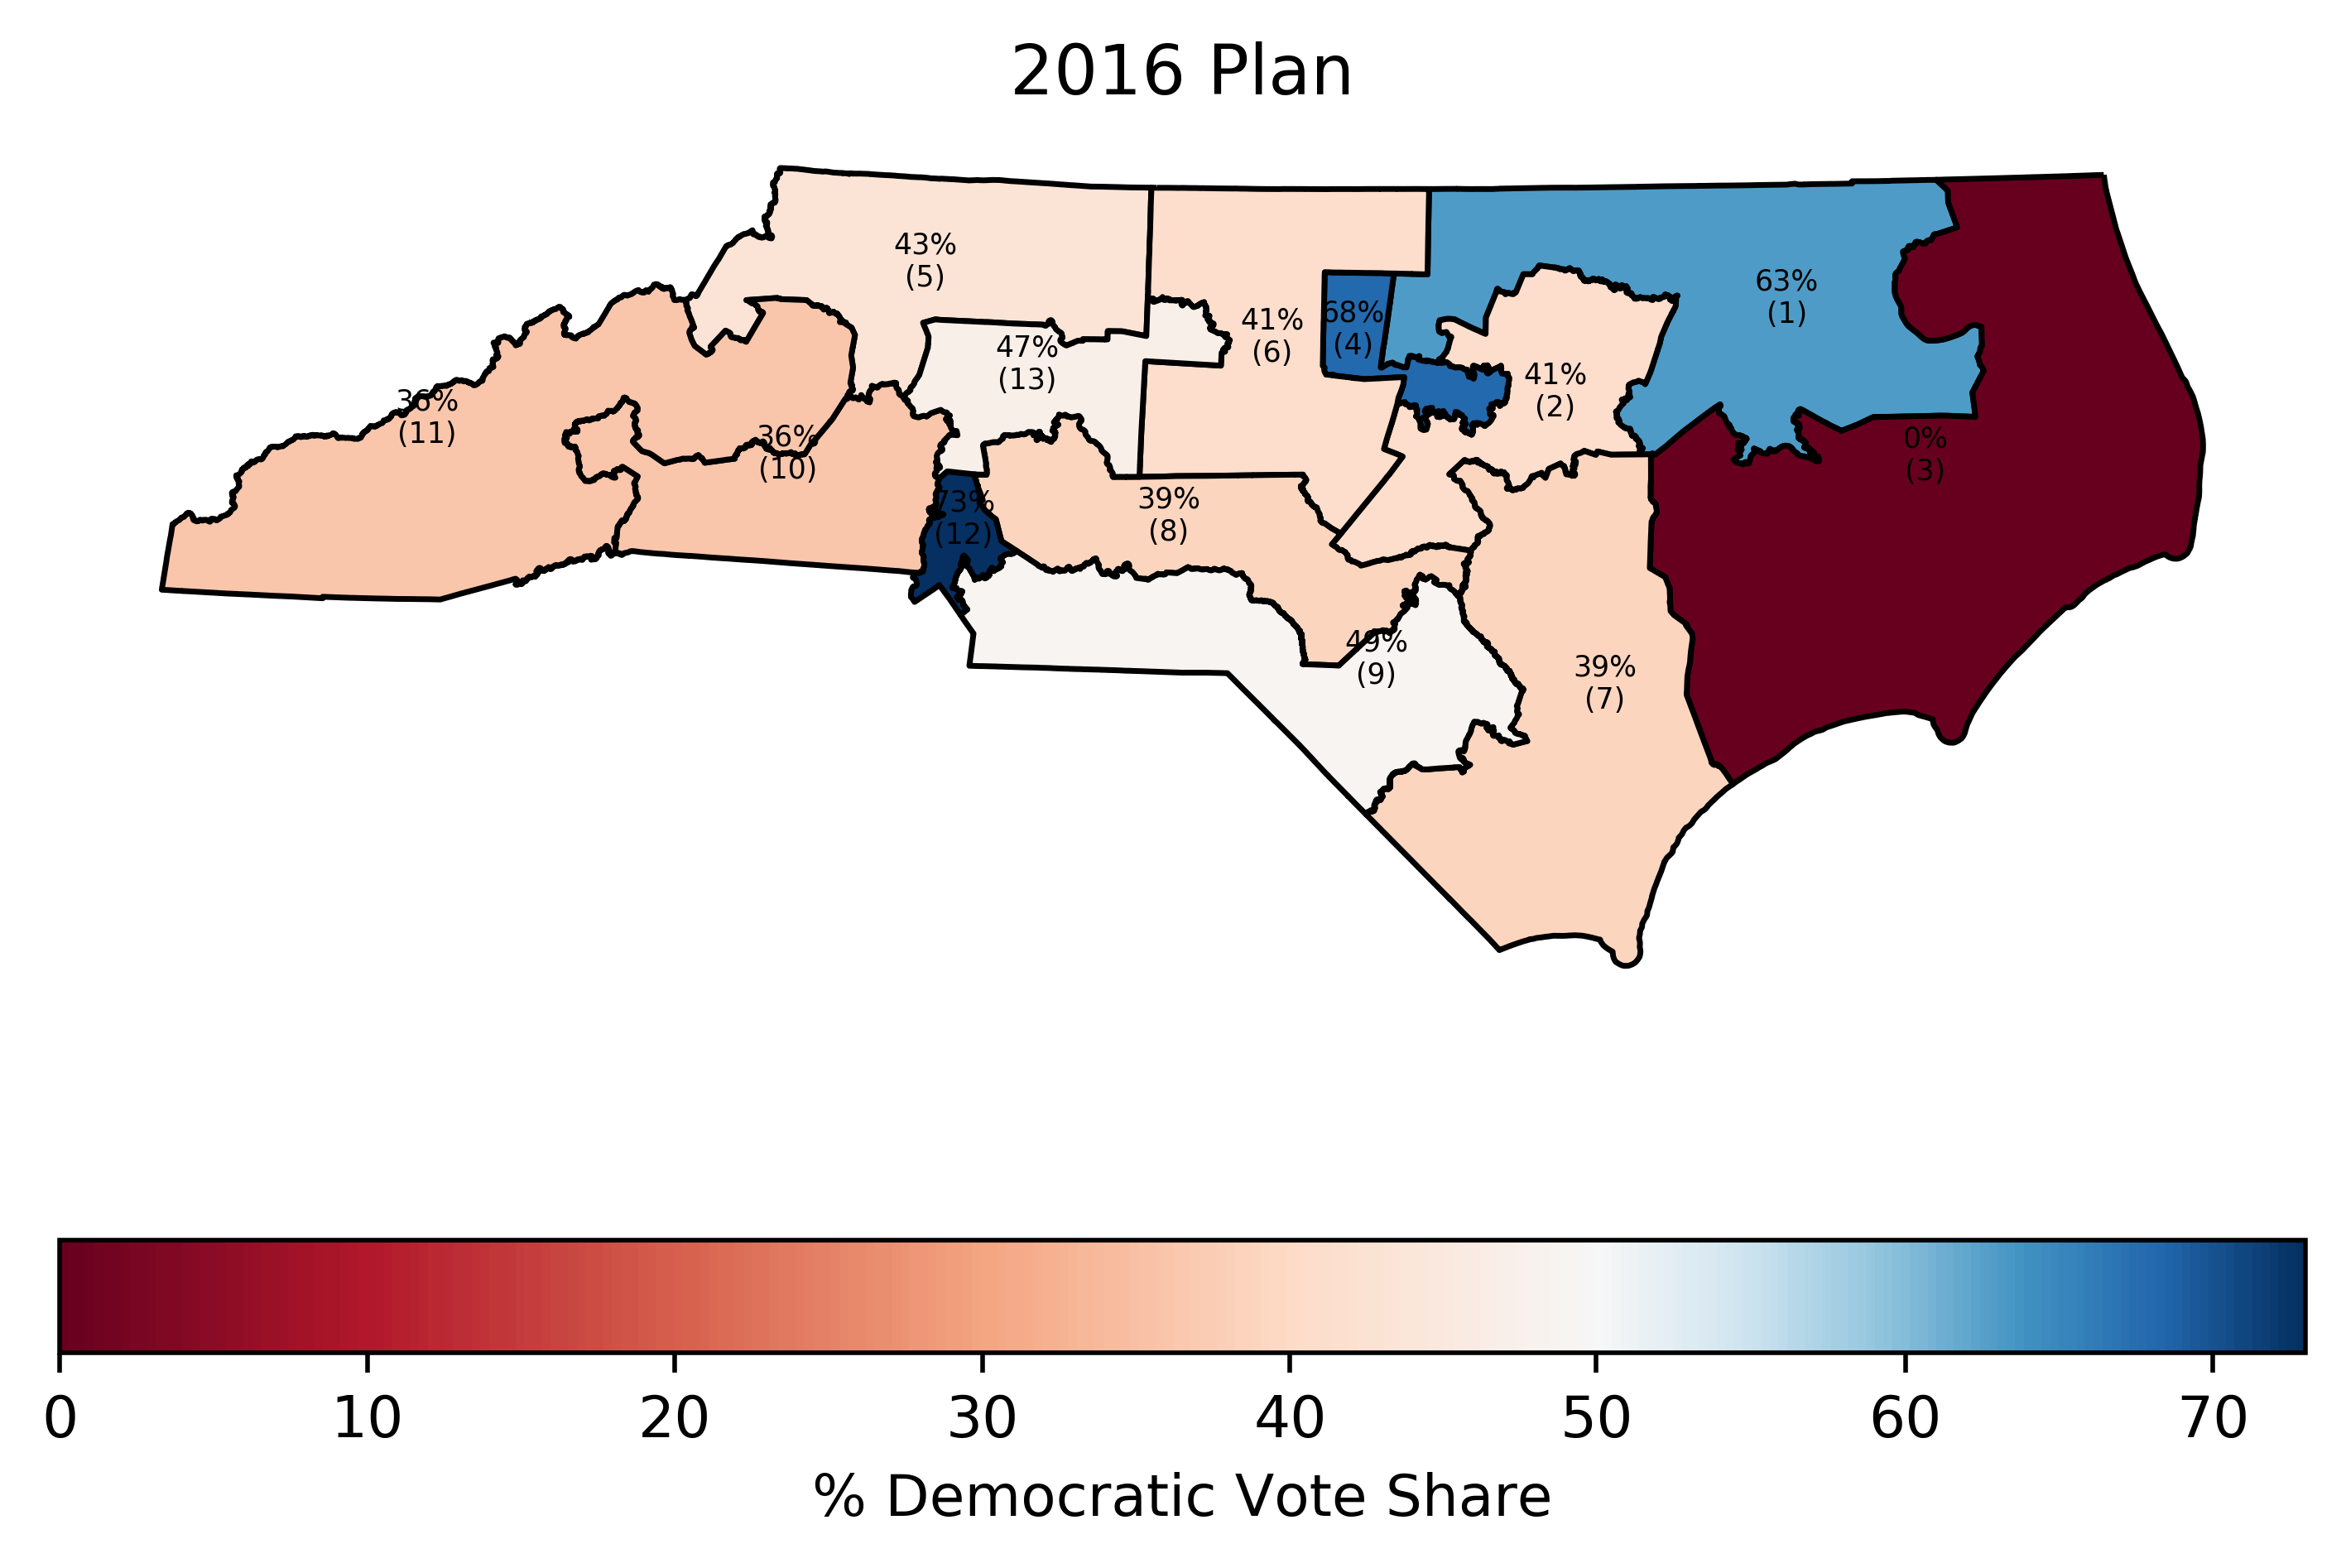

In [8]:
planName = "2016_Contingent_Congressional_Plan_Corrected"
plan = files[planName]
plan["percentDem"] = round(plan["G18DHOR"]/(plan["G18DHOR"]+plan["G18RHOR"])*100).astype(np.int64)
plan["percentDem_discrete"] = pd.cut(plan["percentDem"], bins=[0,15,25,35,45,55,65,75,85,100], labels=["0-15","15-25","25-35","35-45","45-55","55-65","65-75","75-85","85-100"])

plan['coords'] = plan['geometry'].apply(lambda x: x.representative_point().coords[:])
plan['coords'] = [coords[0] for coords in plan['coords']]

f, ax = plt.subplots(1)
ax.set_axis_off()
plan.plot(column="percentDem", ax=ax, edgecolor='black', cmap='RdBu', norm=divnorm)
for idx, row in plan.iterrows():
    label = str(row['percentDem'])+"%\n(" + str(row['District']) + ")"
    plt.annotate(s=label, xy=row['coords'], horizontalalignment='center', size=5)
plt.title("2016 Plan")
f.colorbar(cbar, ax=ax, label="% Democratic Vote Share", orientation='horizontal')
plt.show()

The following loop goes through each key in the dictionary called `files` and creates the same plot. For each one, create a colorbar centered at 50% to show the percent Democratic vote share for each district, using the 2018 US House election results by precinct. At the end of the loop, there is an option to either display the plot or save it to a PDF. To view all of the maps below, you will need to scroll through the viewing box. 

How does this work? Well, for each proposed plan every district is made up of **precincts**. A precinct is the smallest unit at which votes are officially tallied. We check which precincts a district contains in each proposed plan, and calculate the estimated results based off of the 2018 US House precinct results. It's not exact, but it gives us a good estimate of the partisan outcome for a proposed map.

Note: each district number is in parentheses beneath the "% Democratic vote" label, except for plans where districts were not labeled.

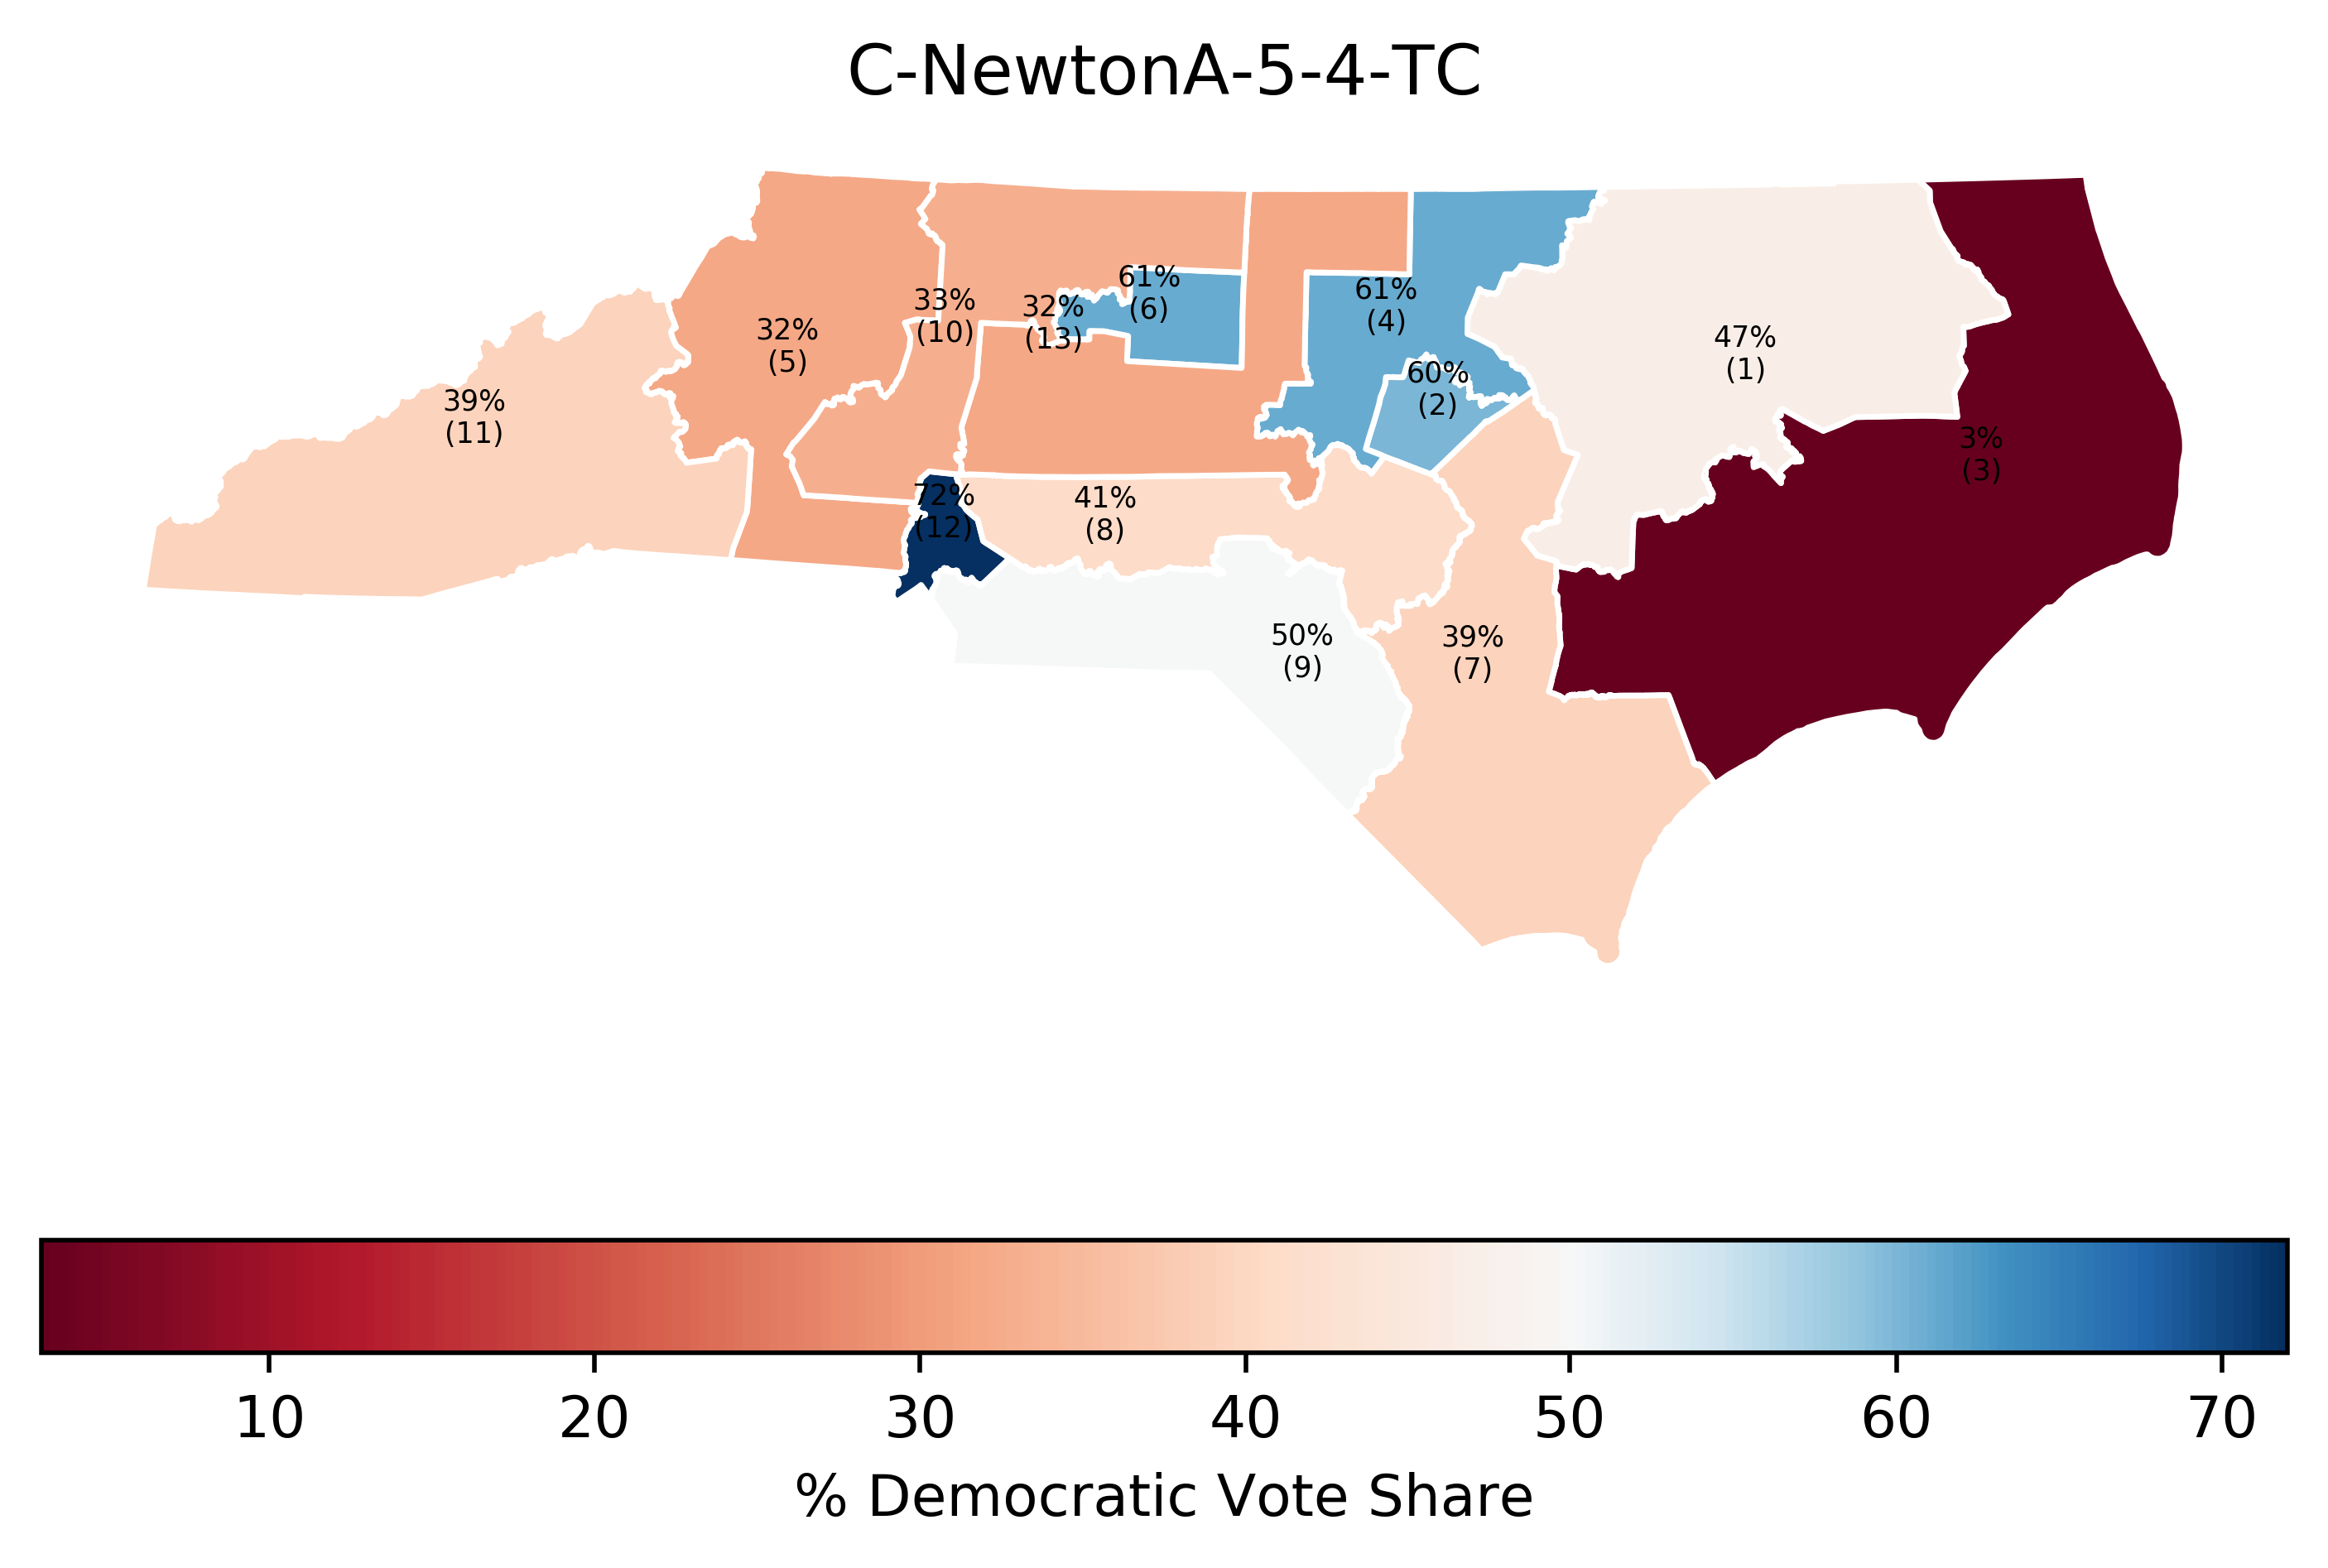

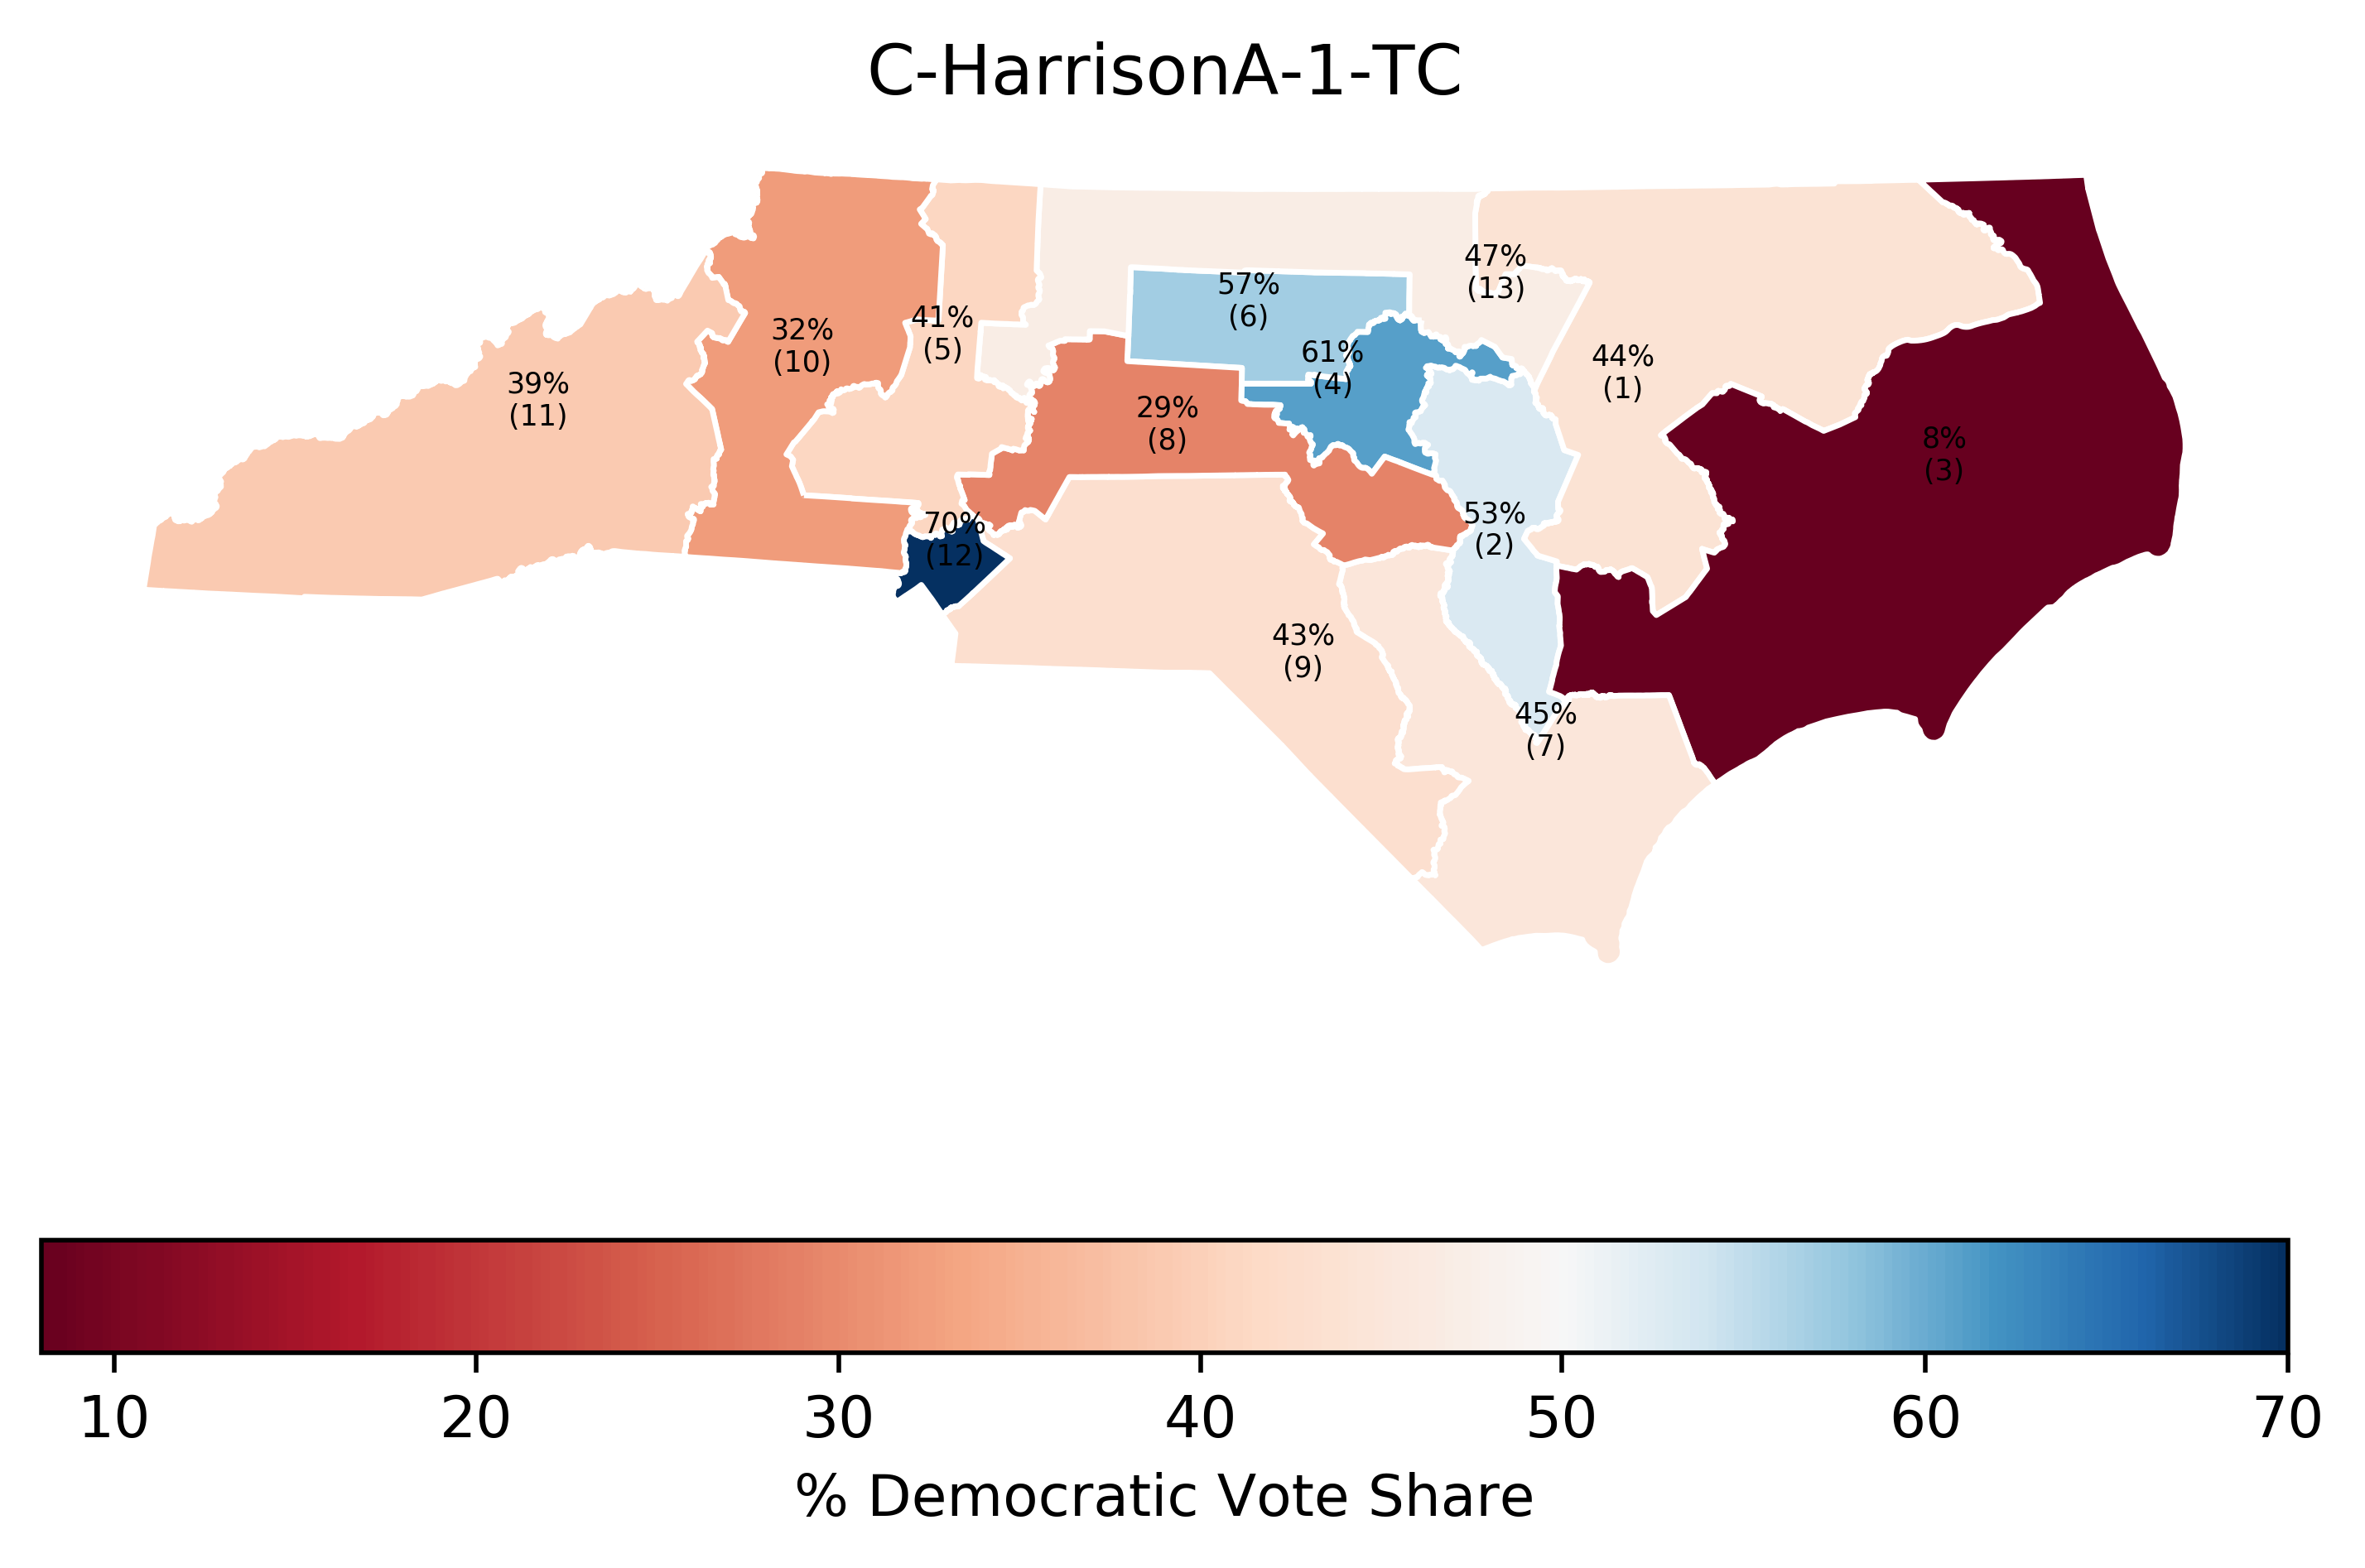

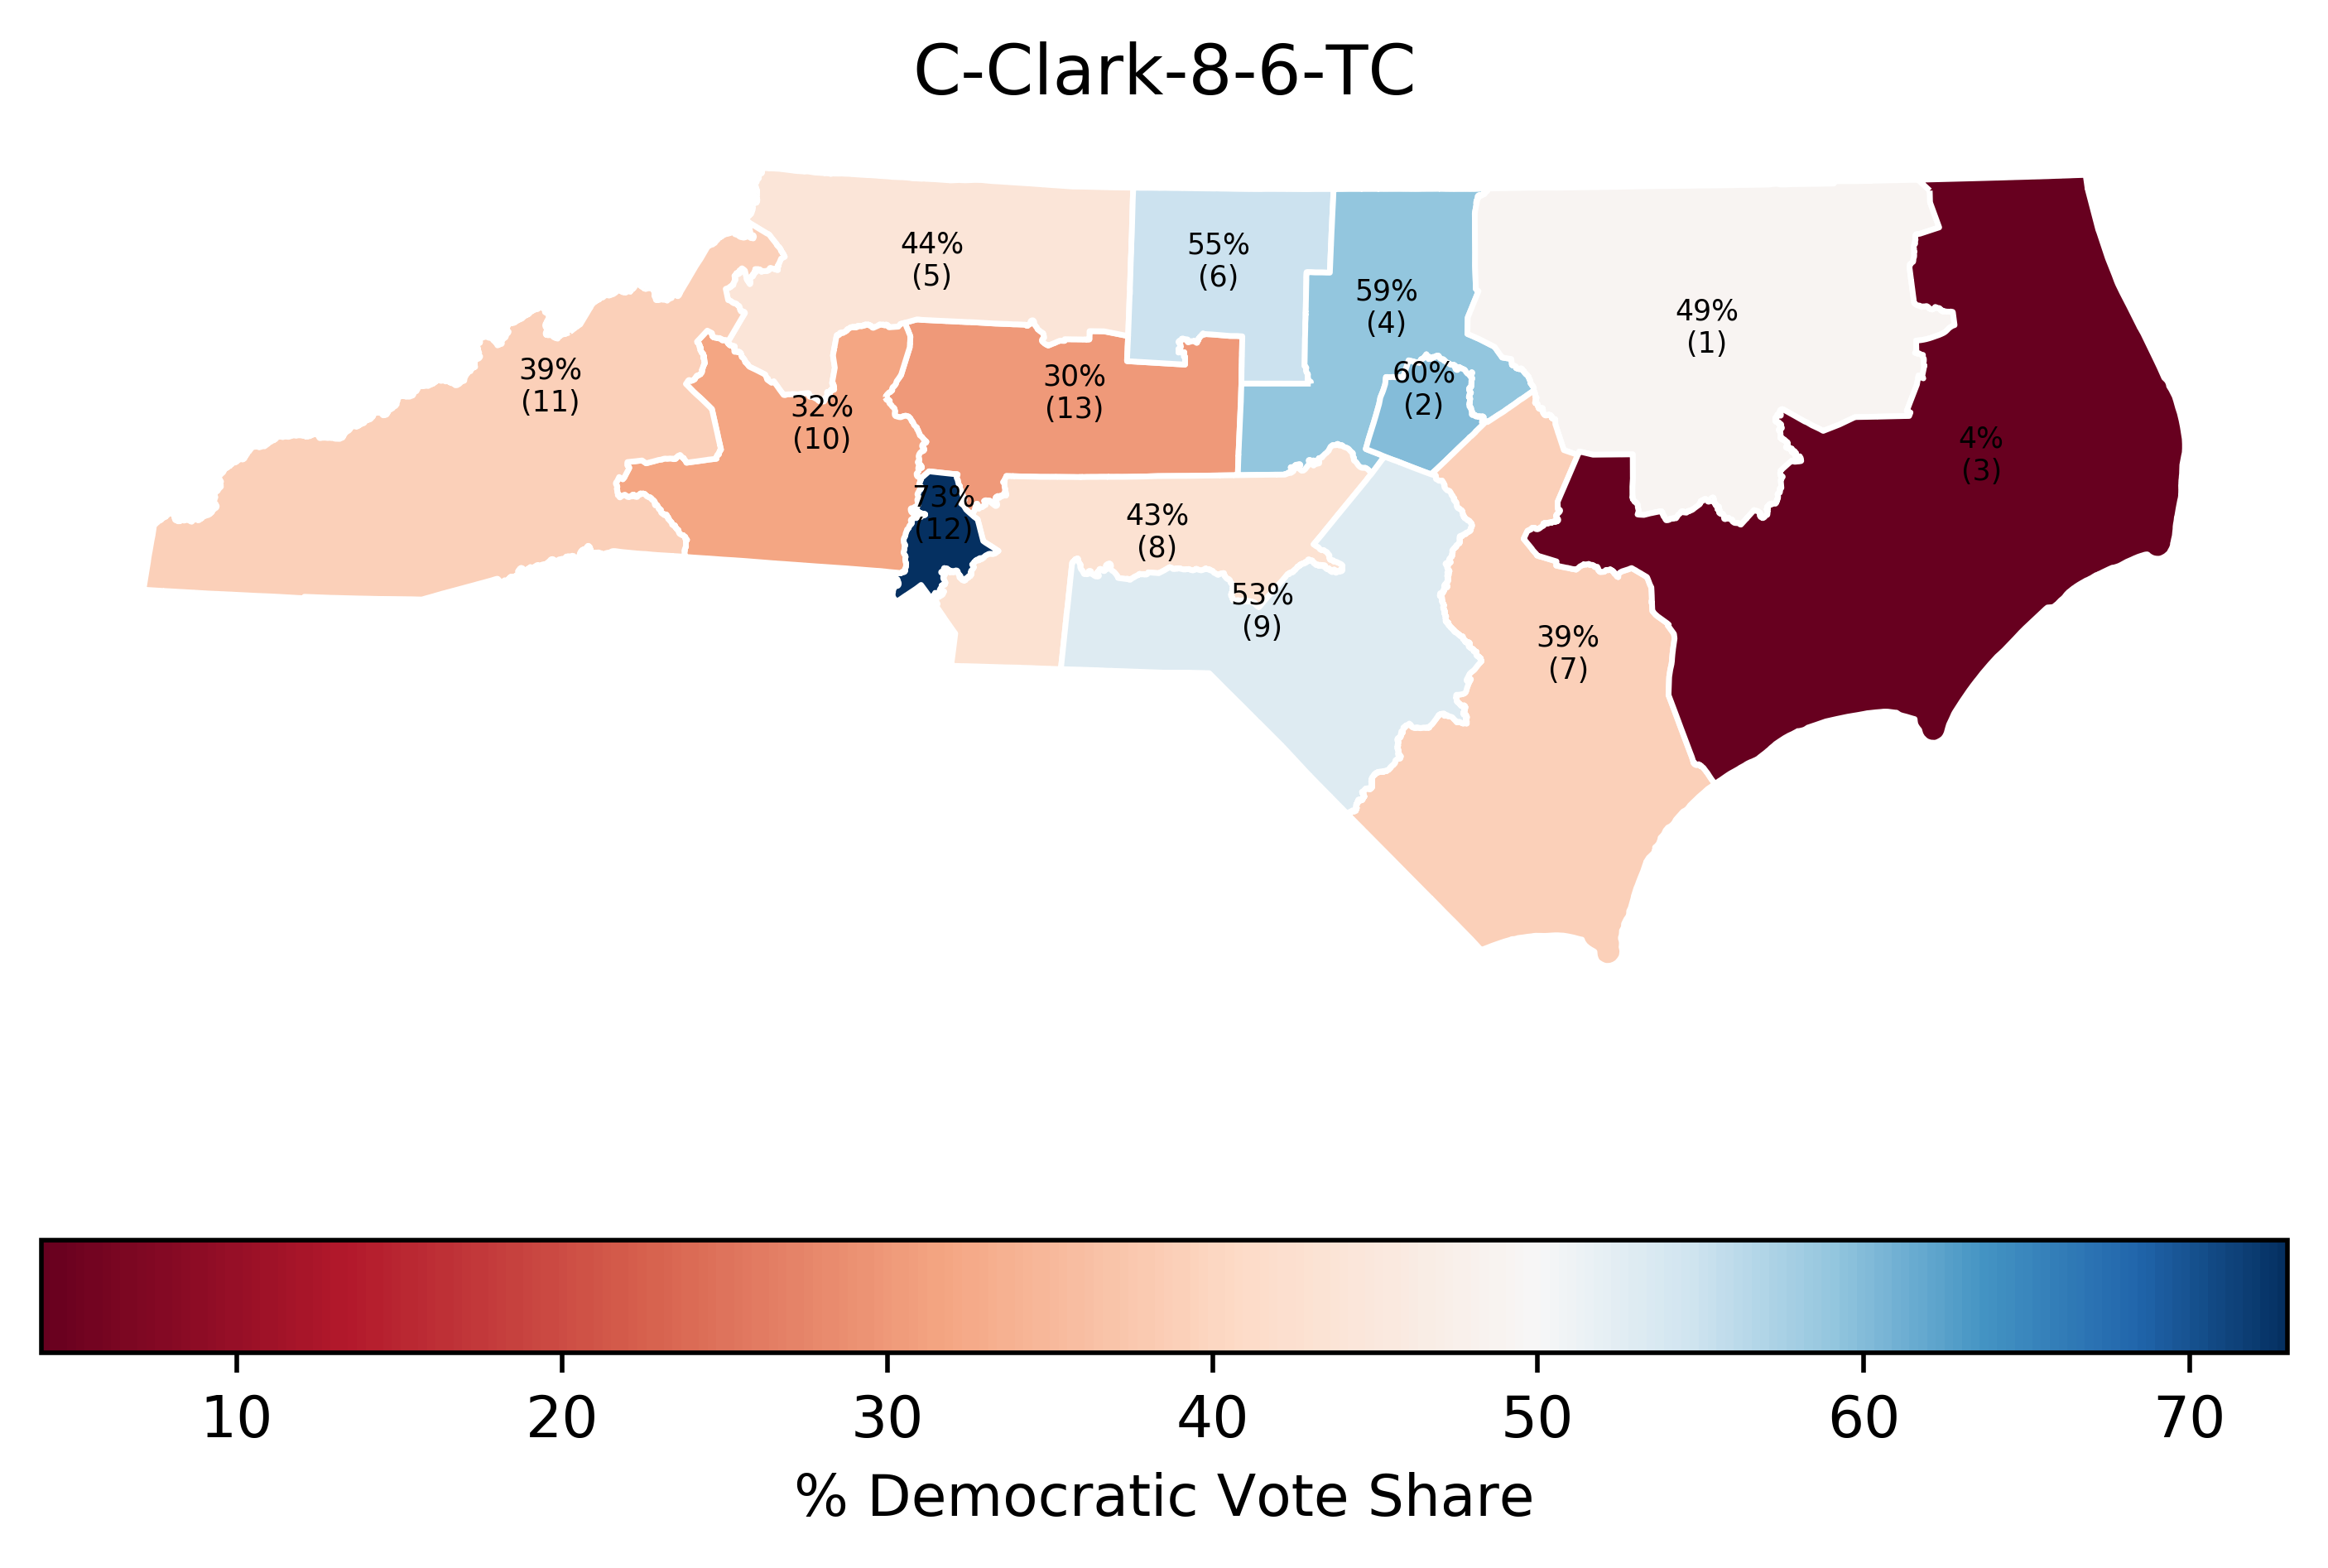

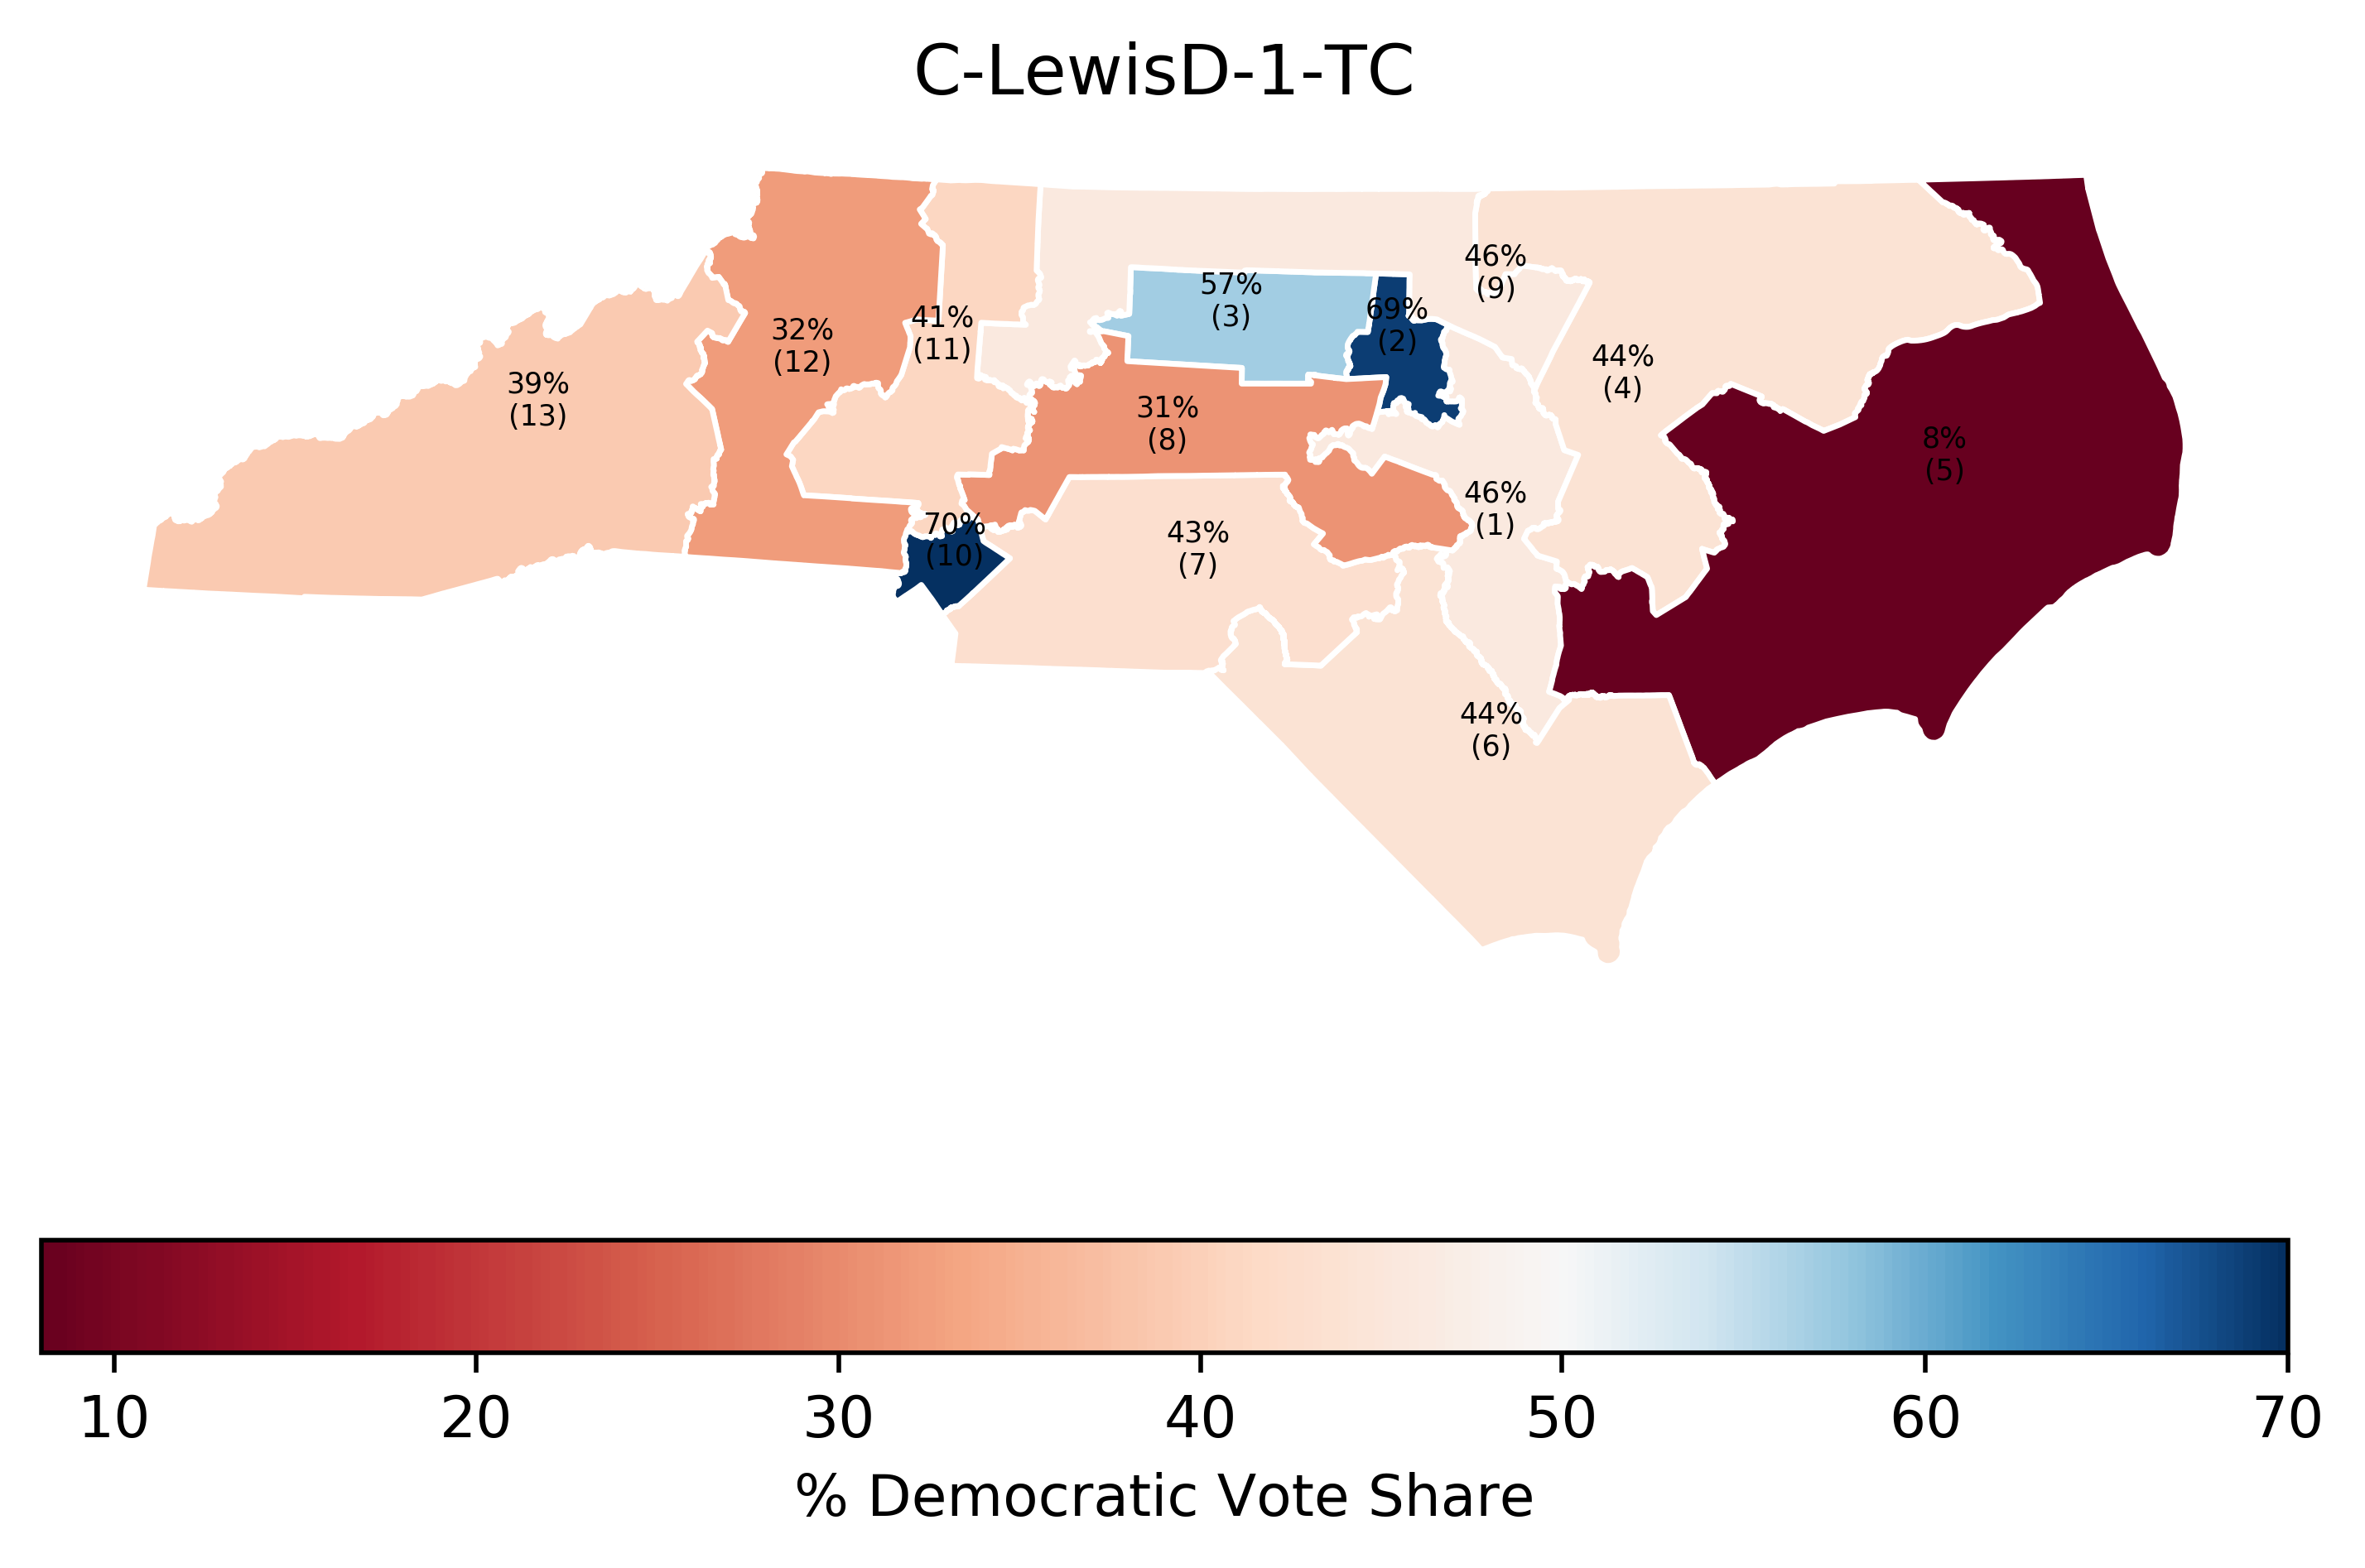

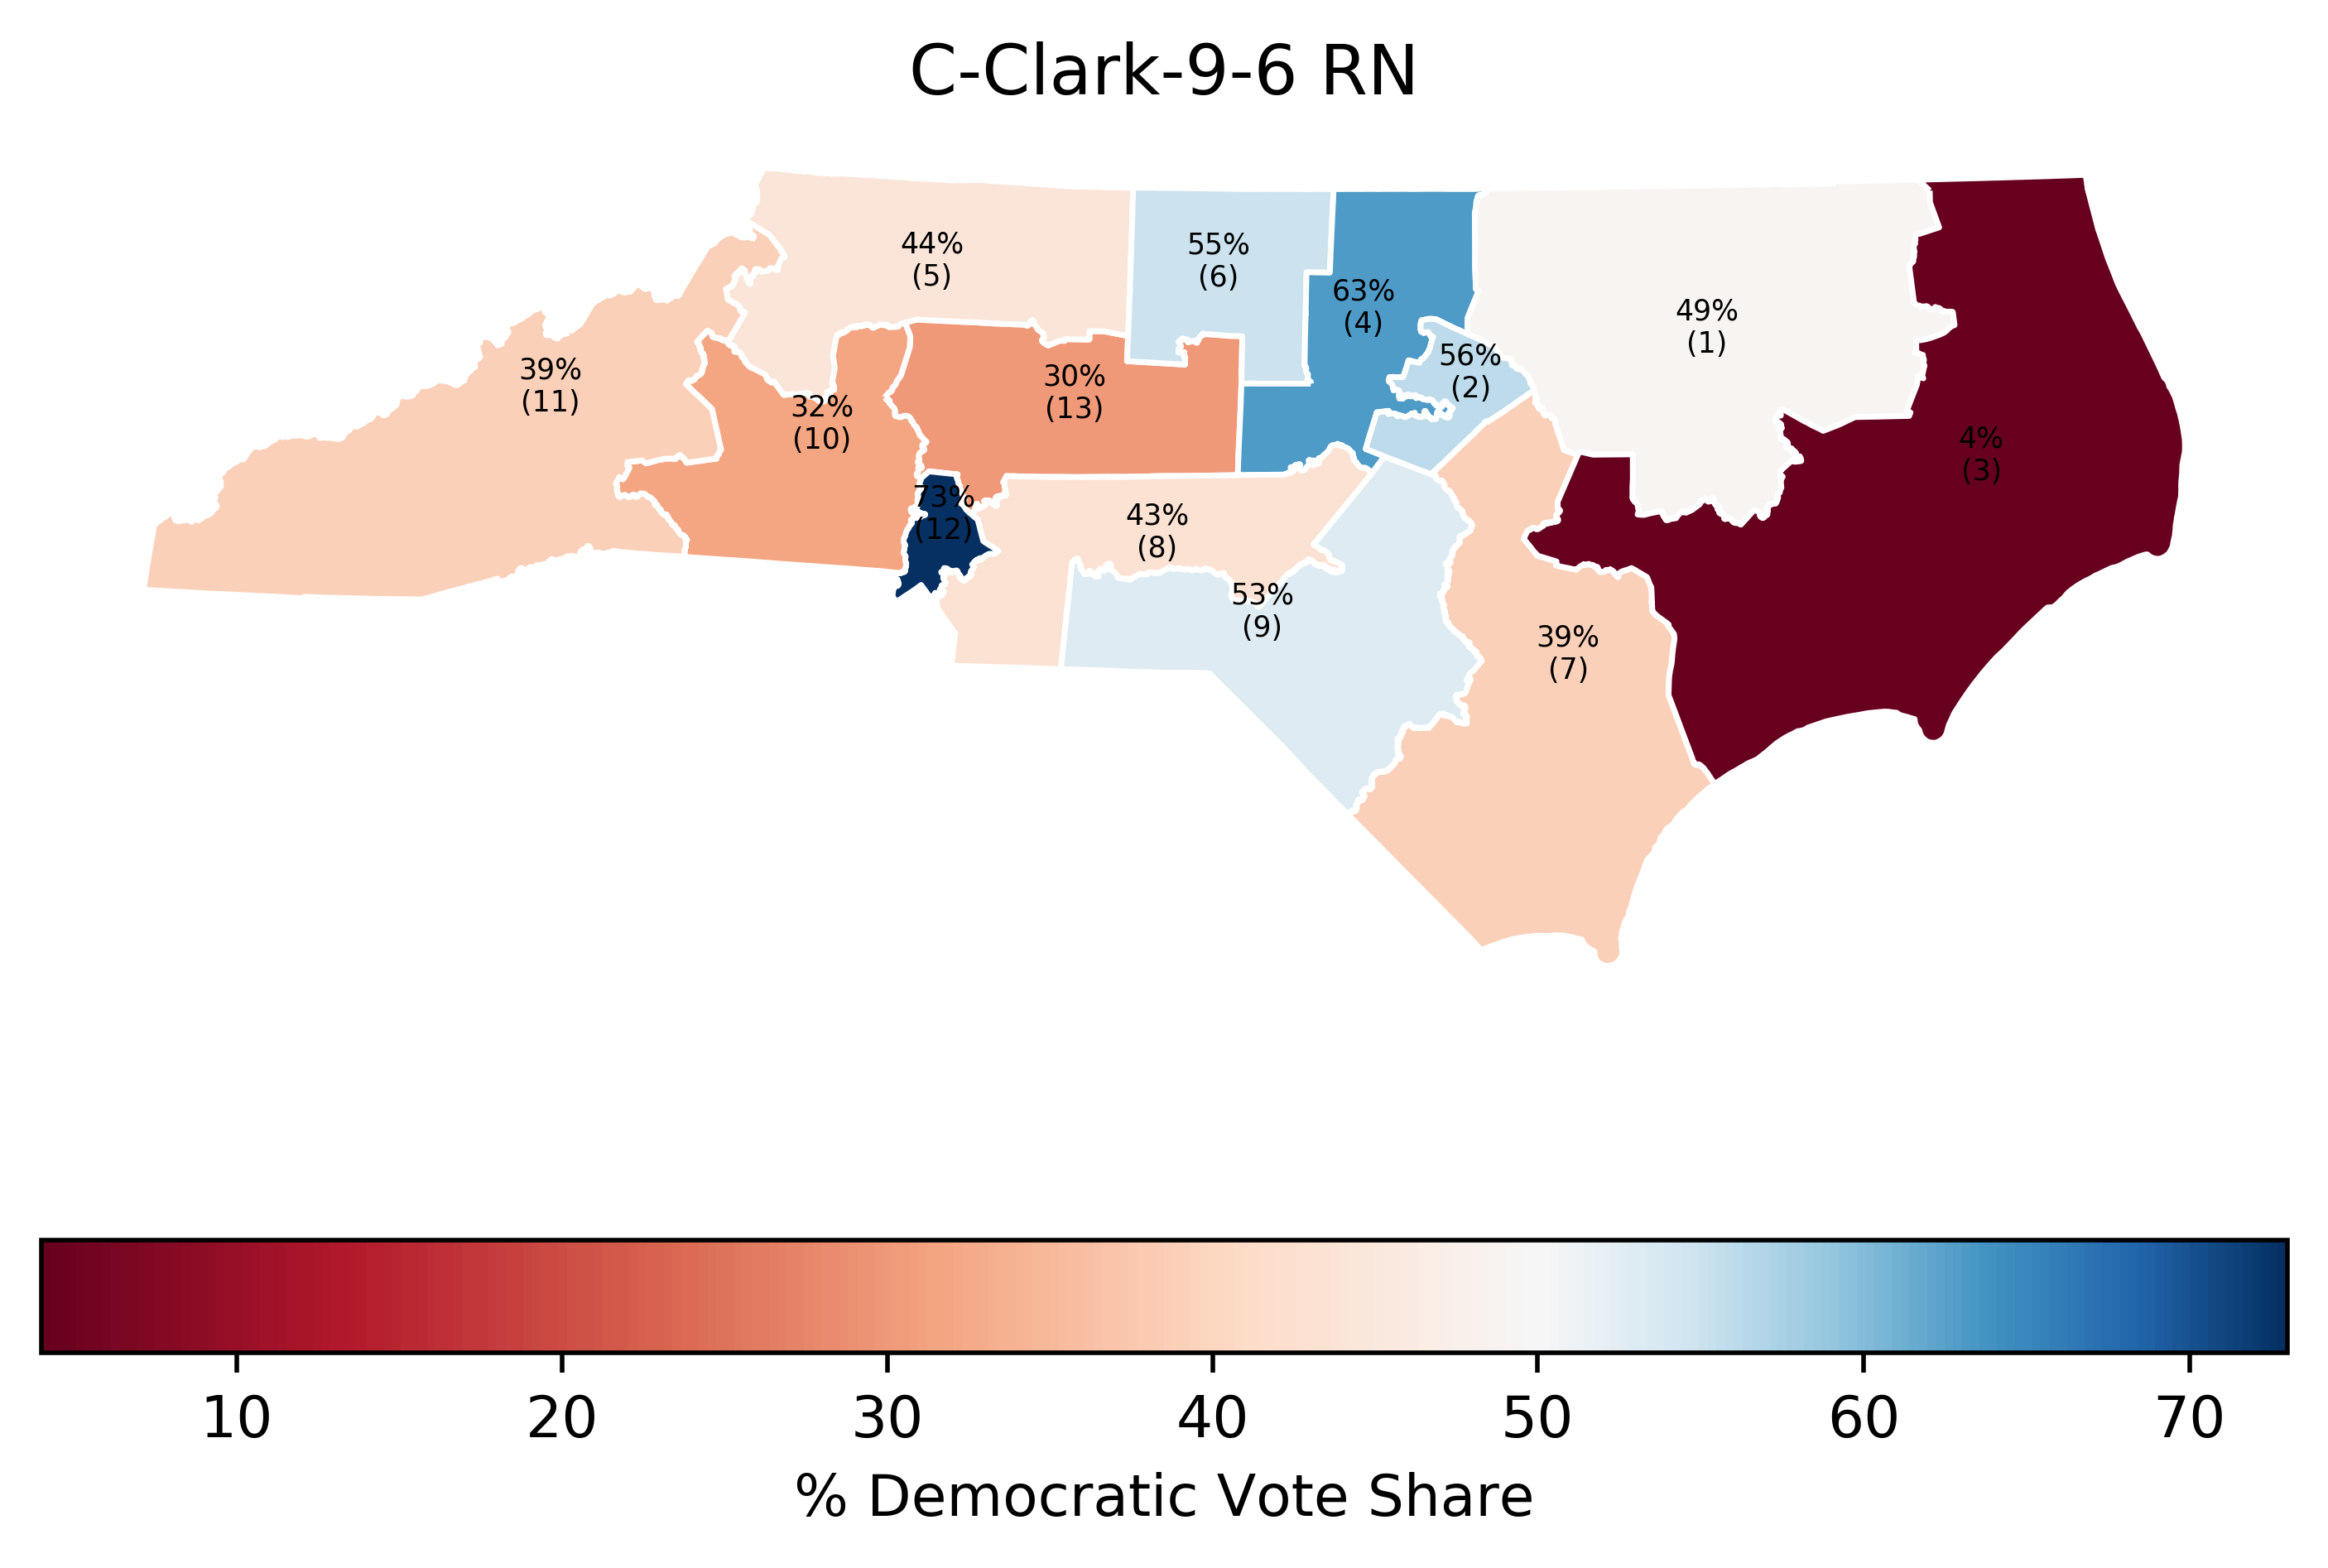

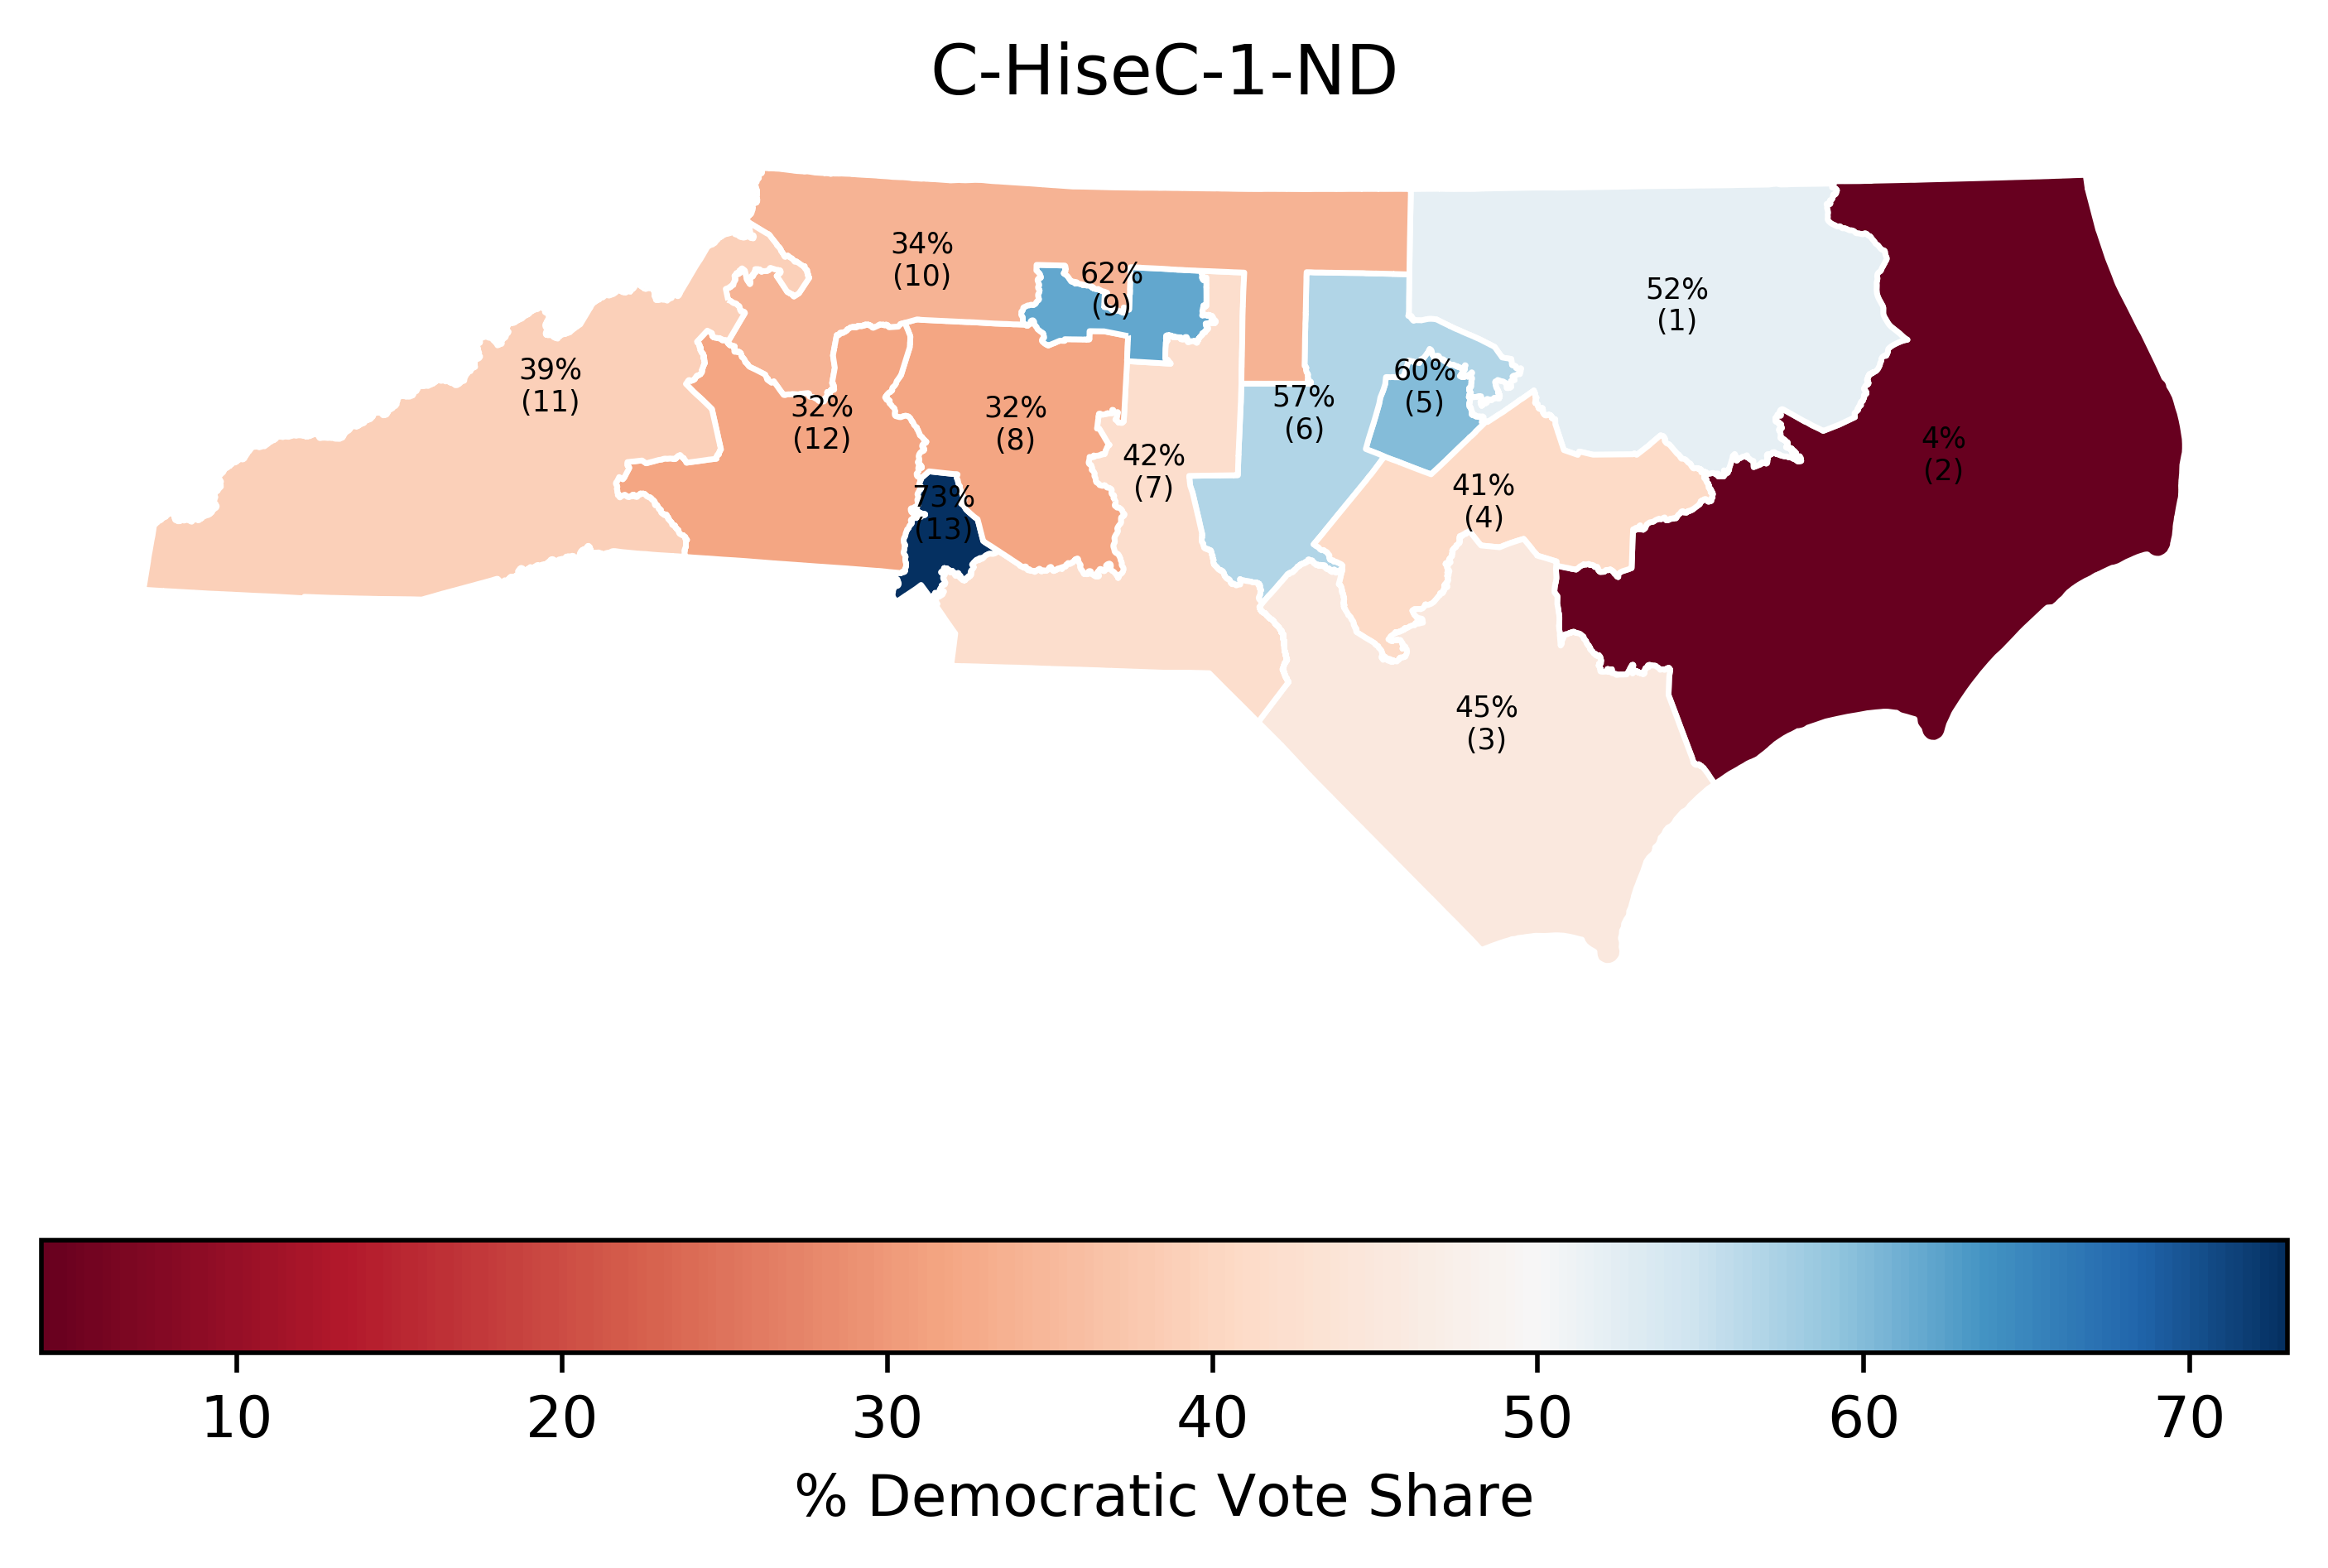

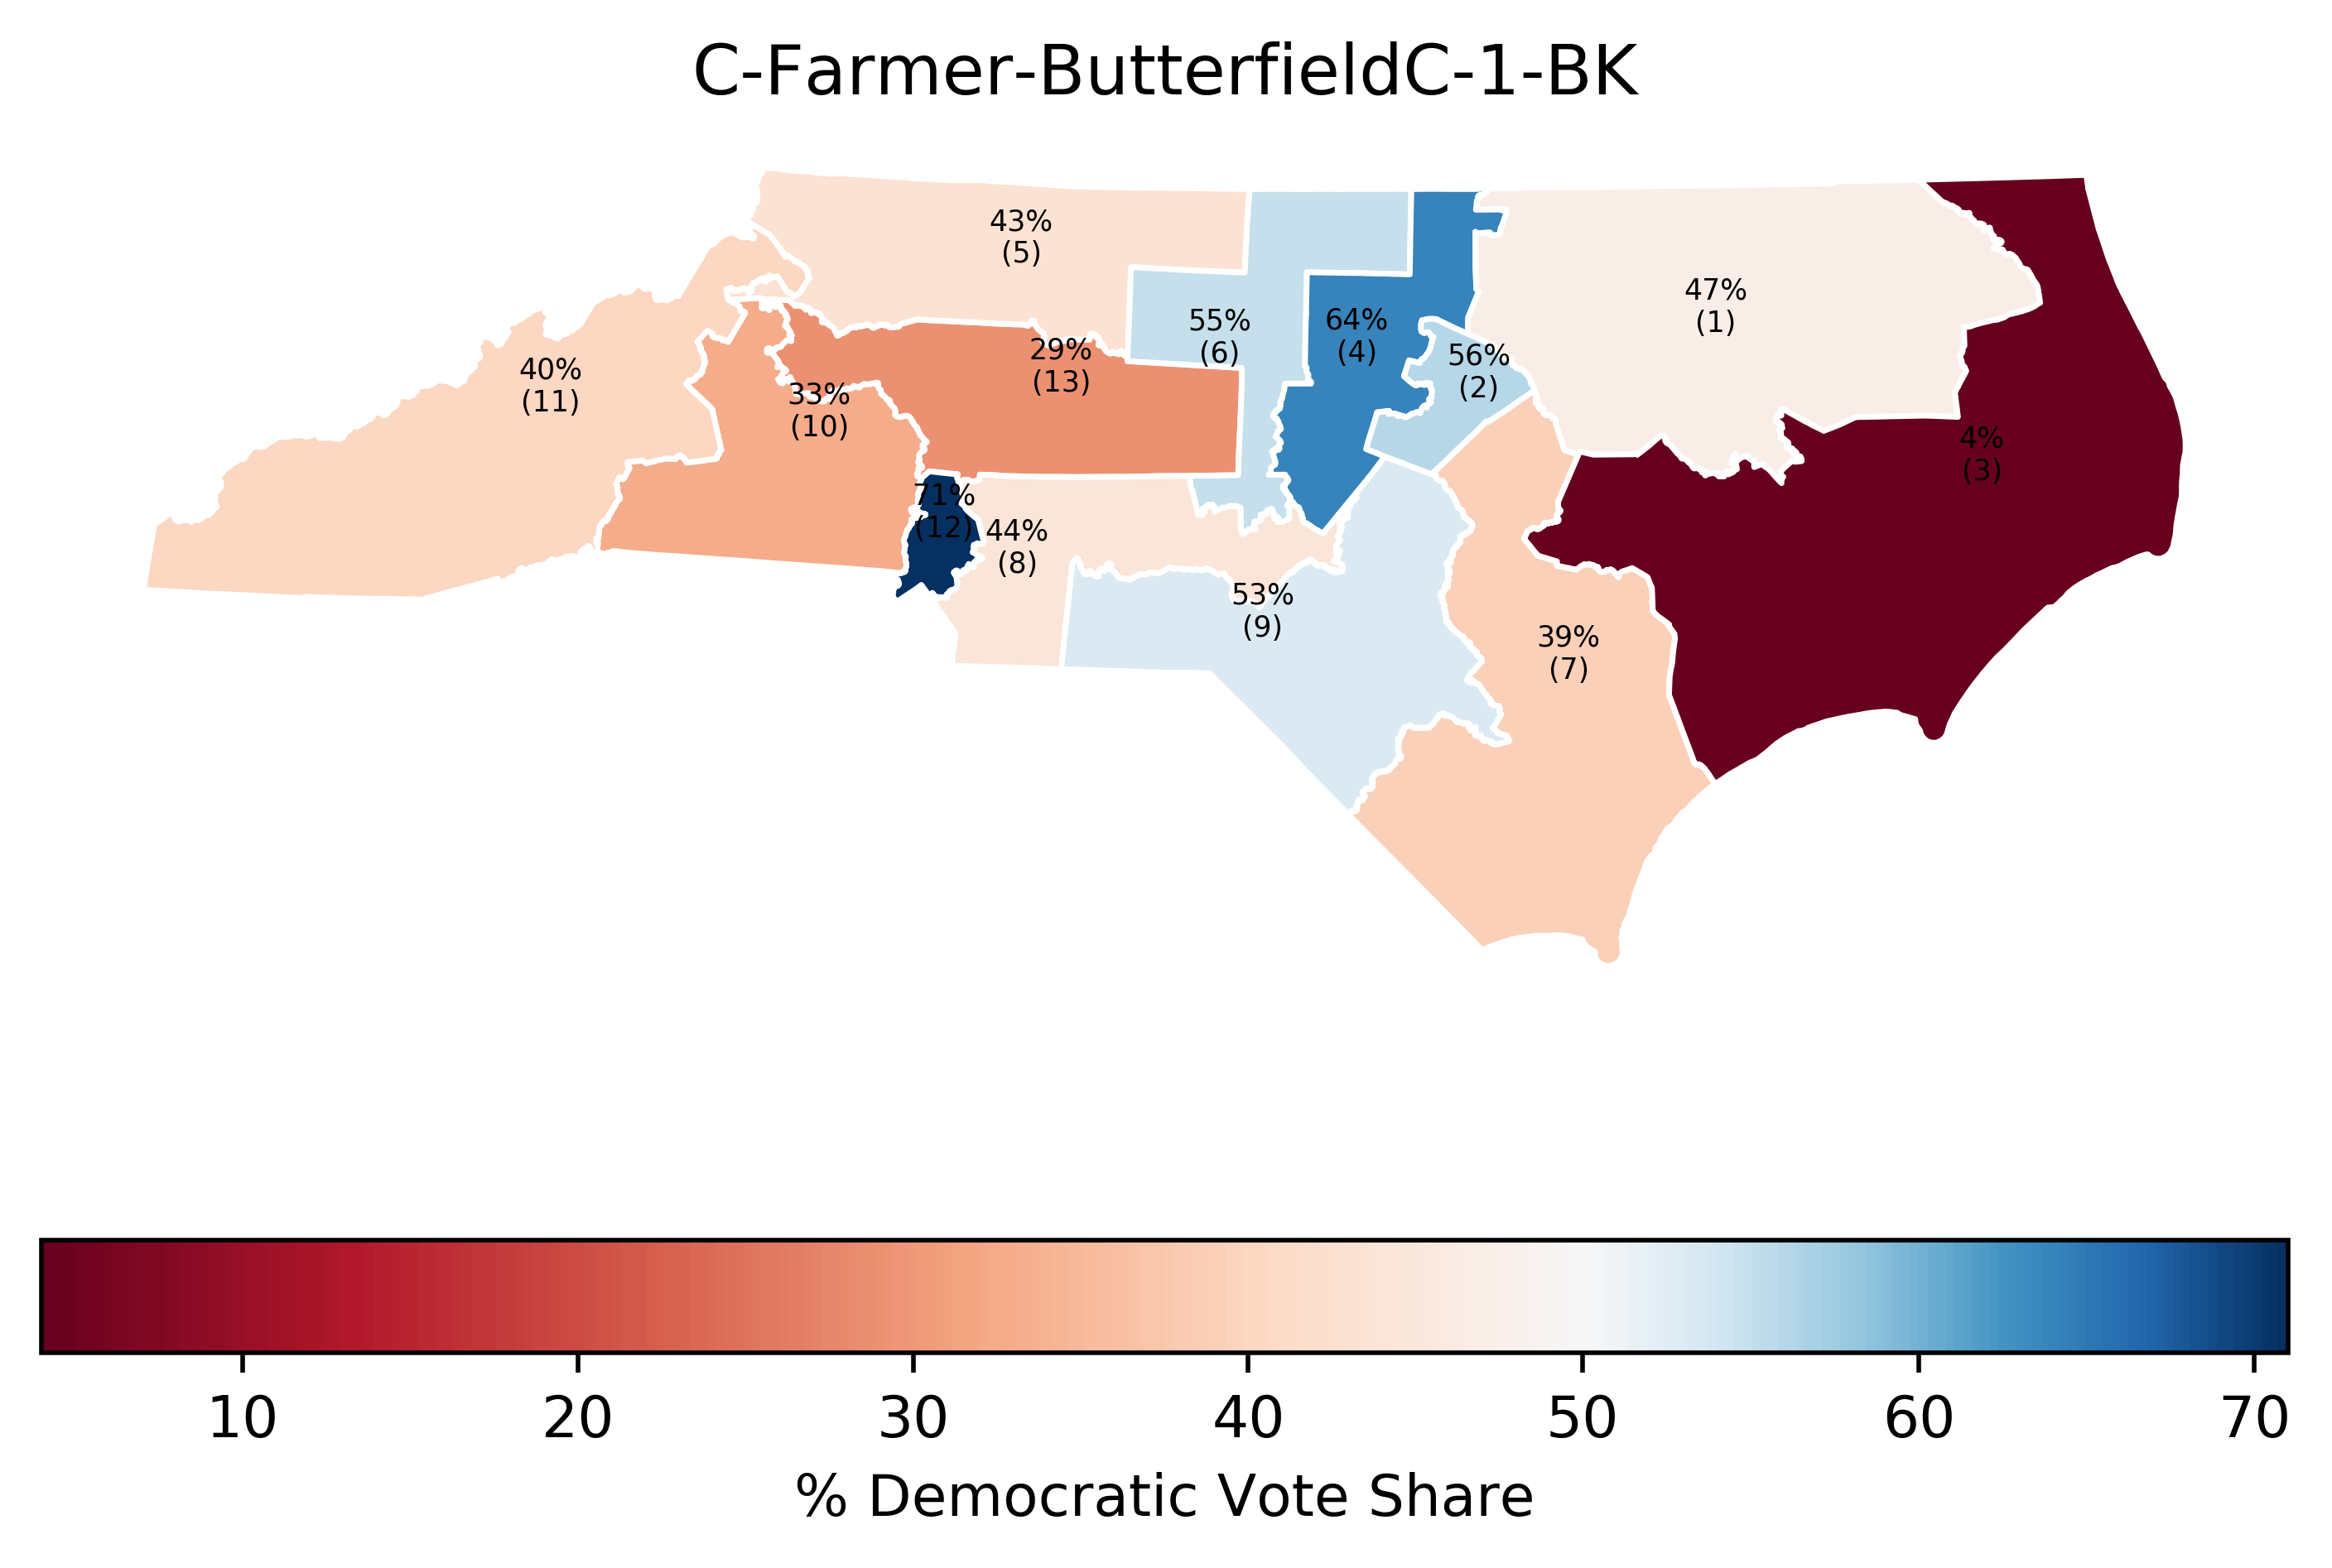

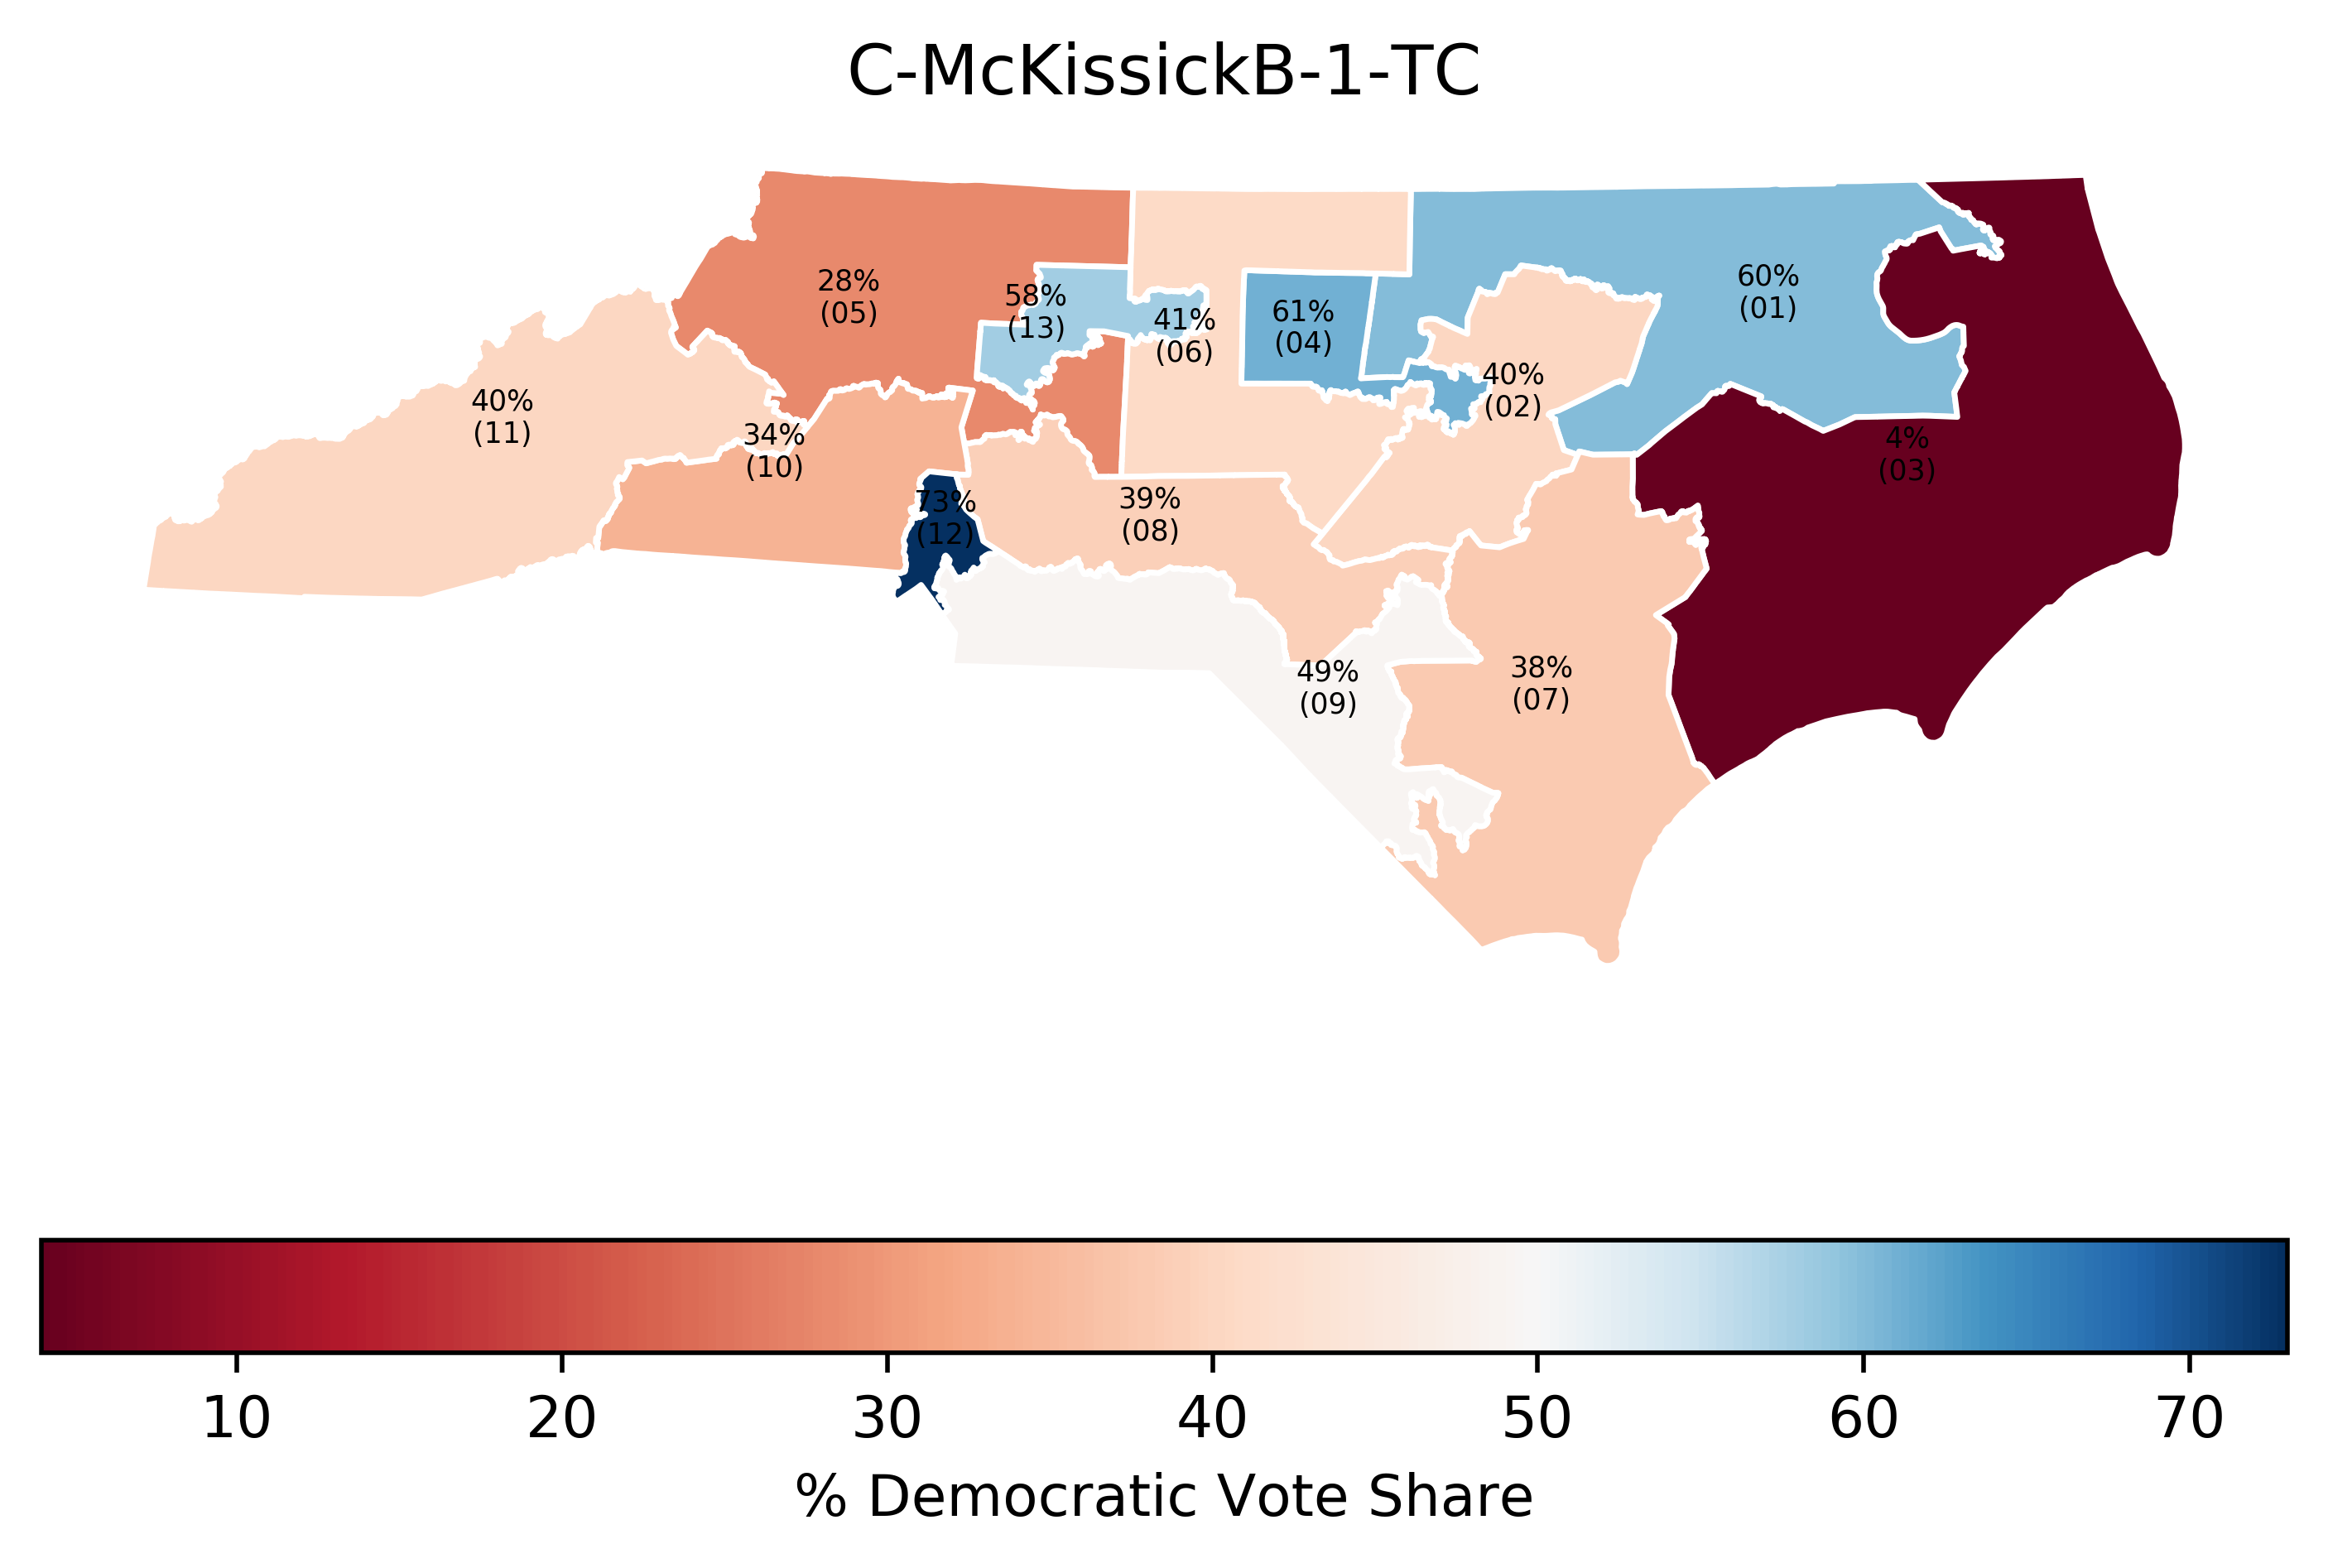

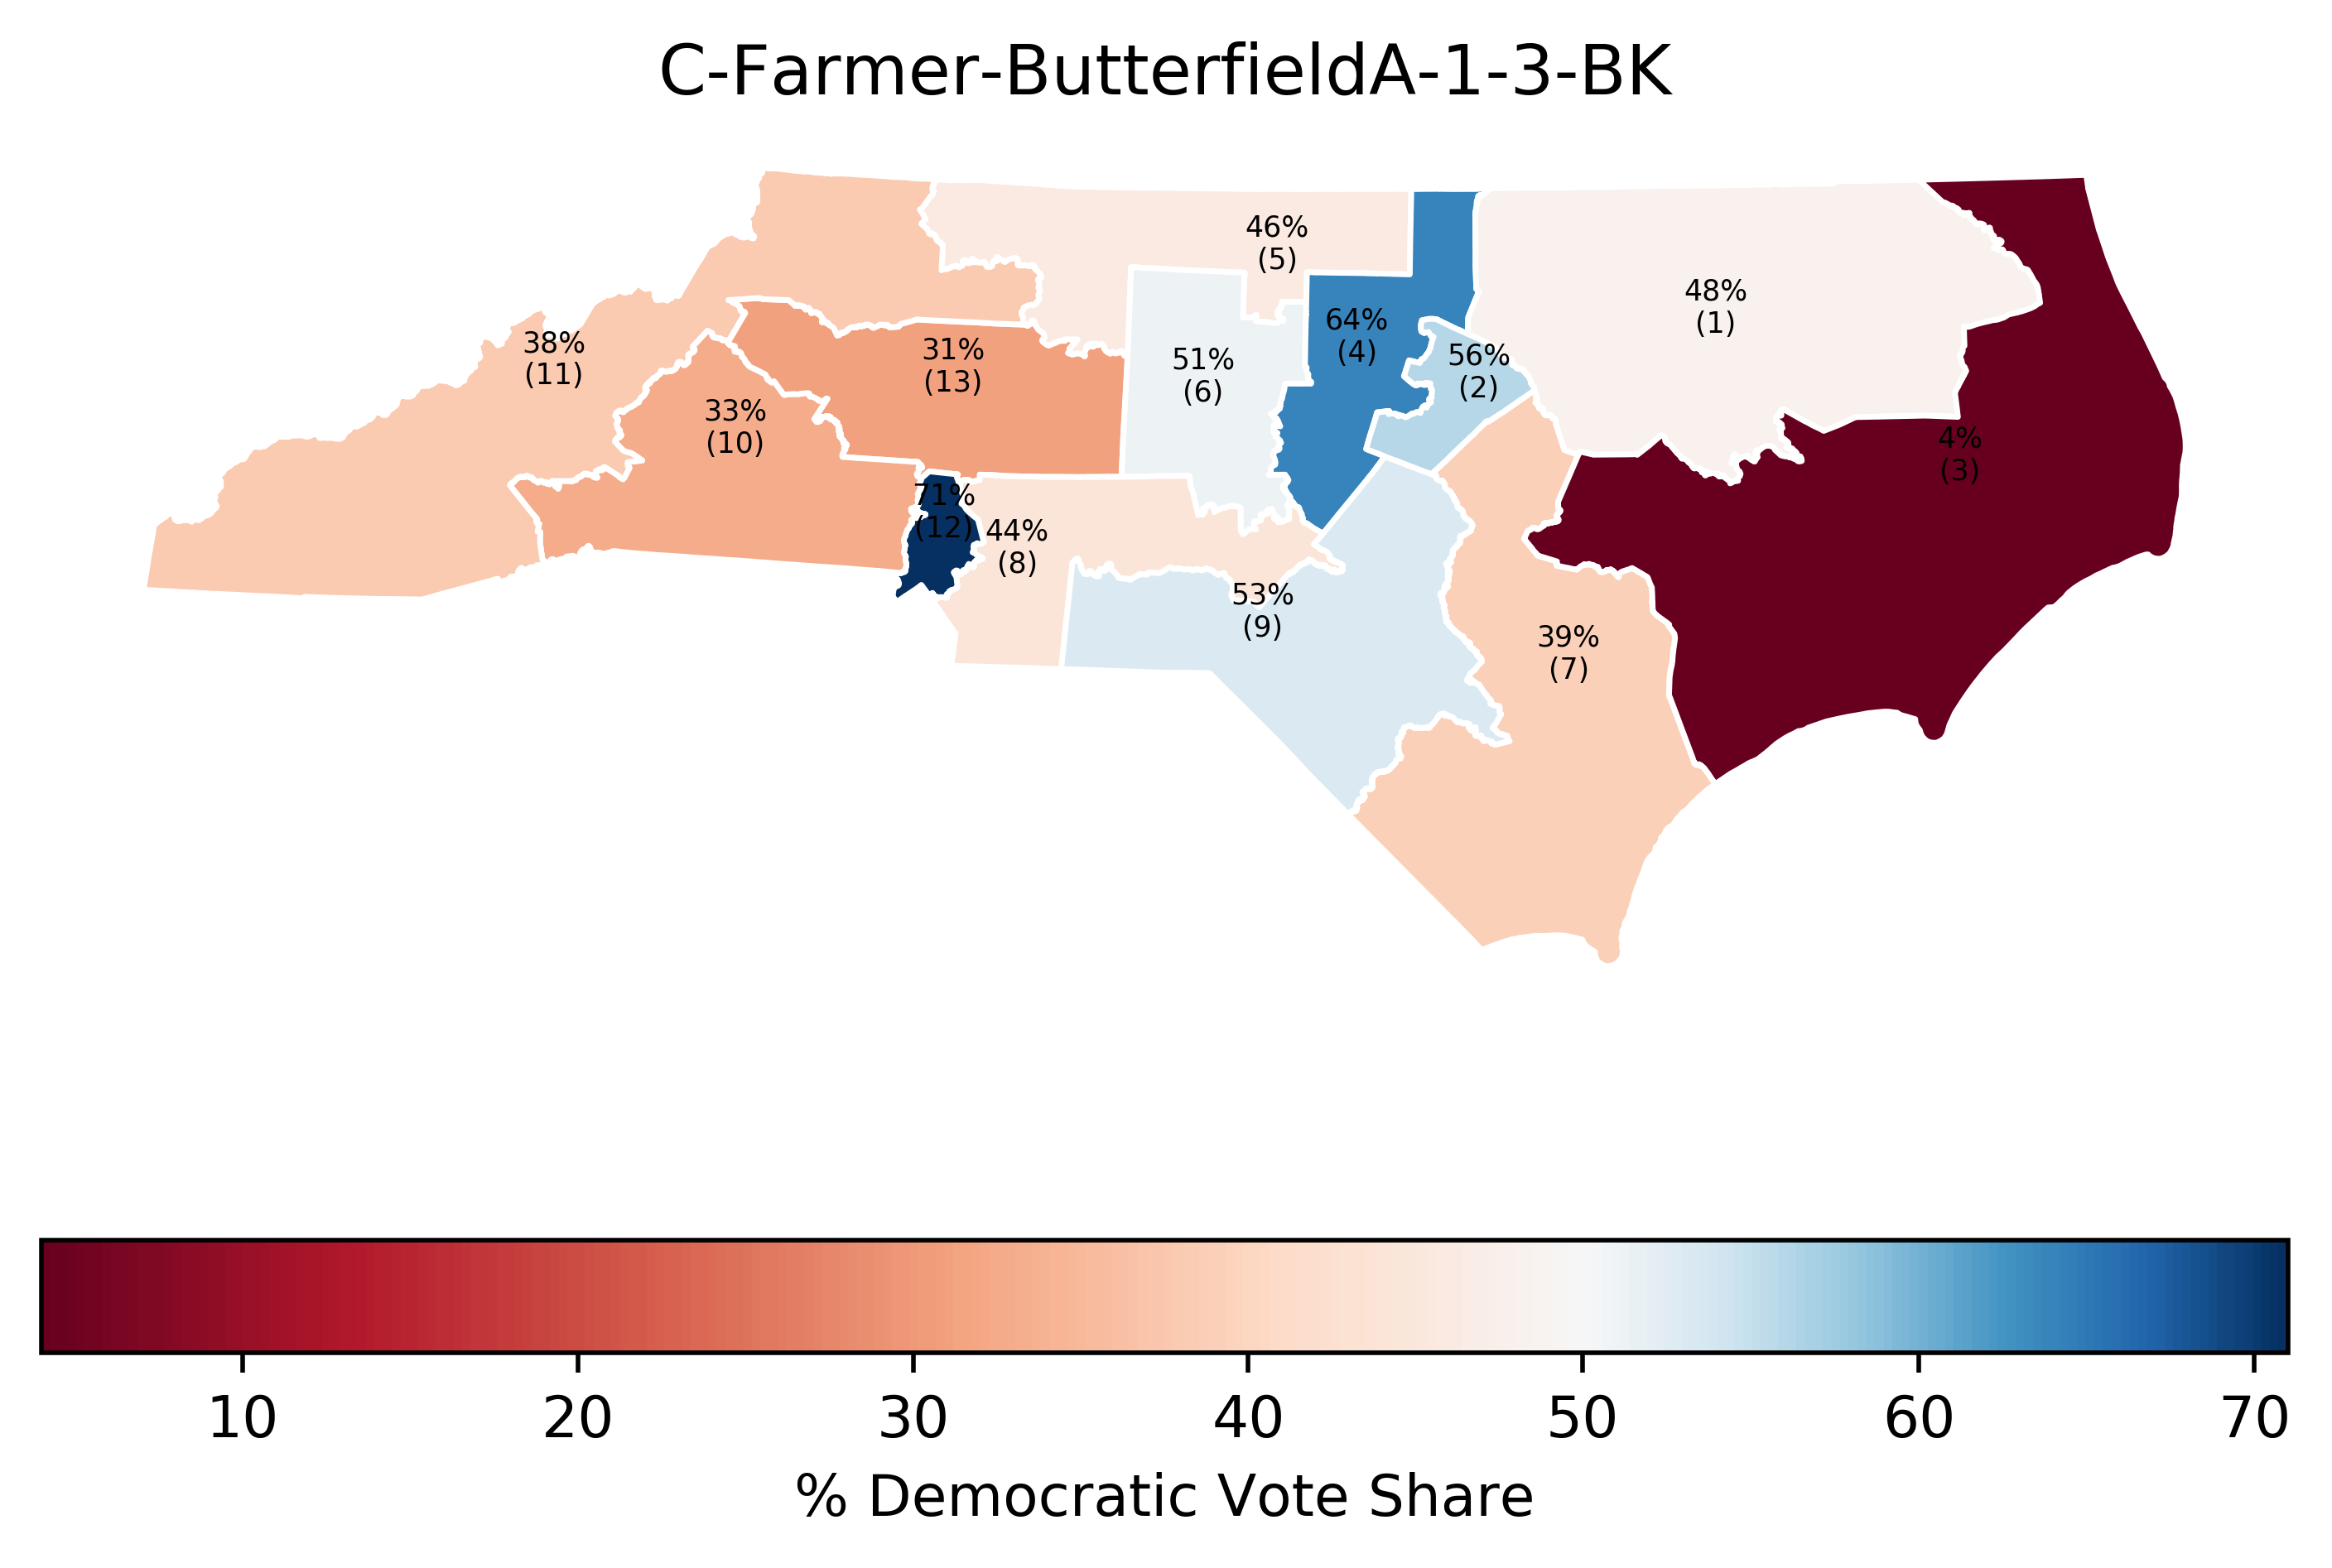

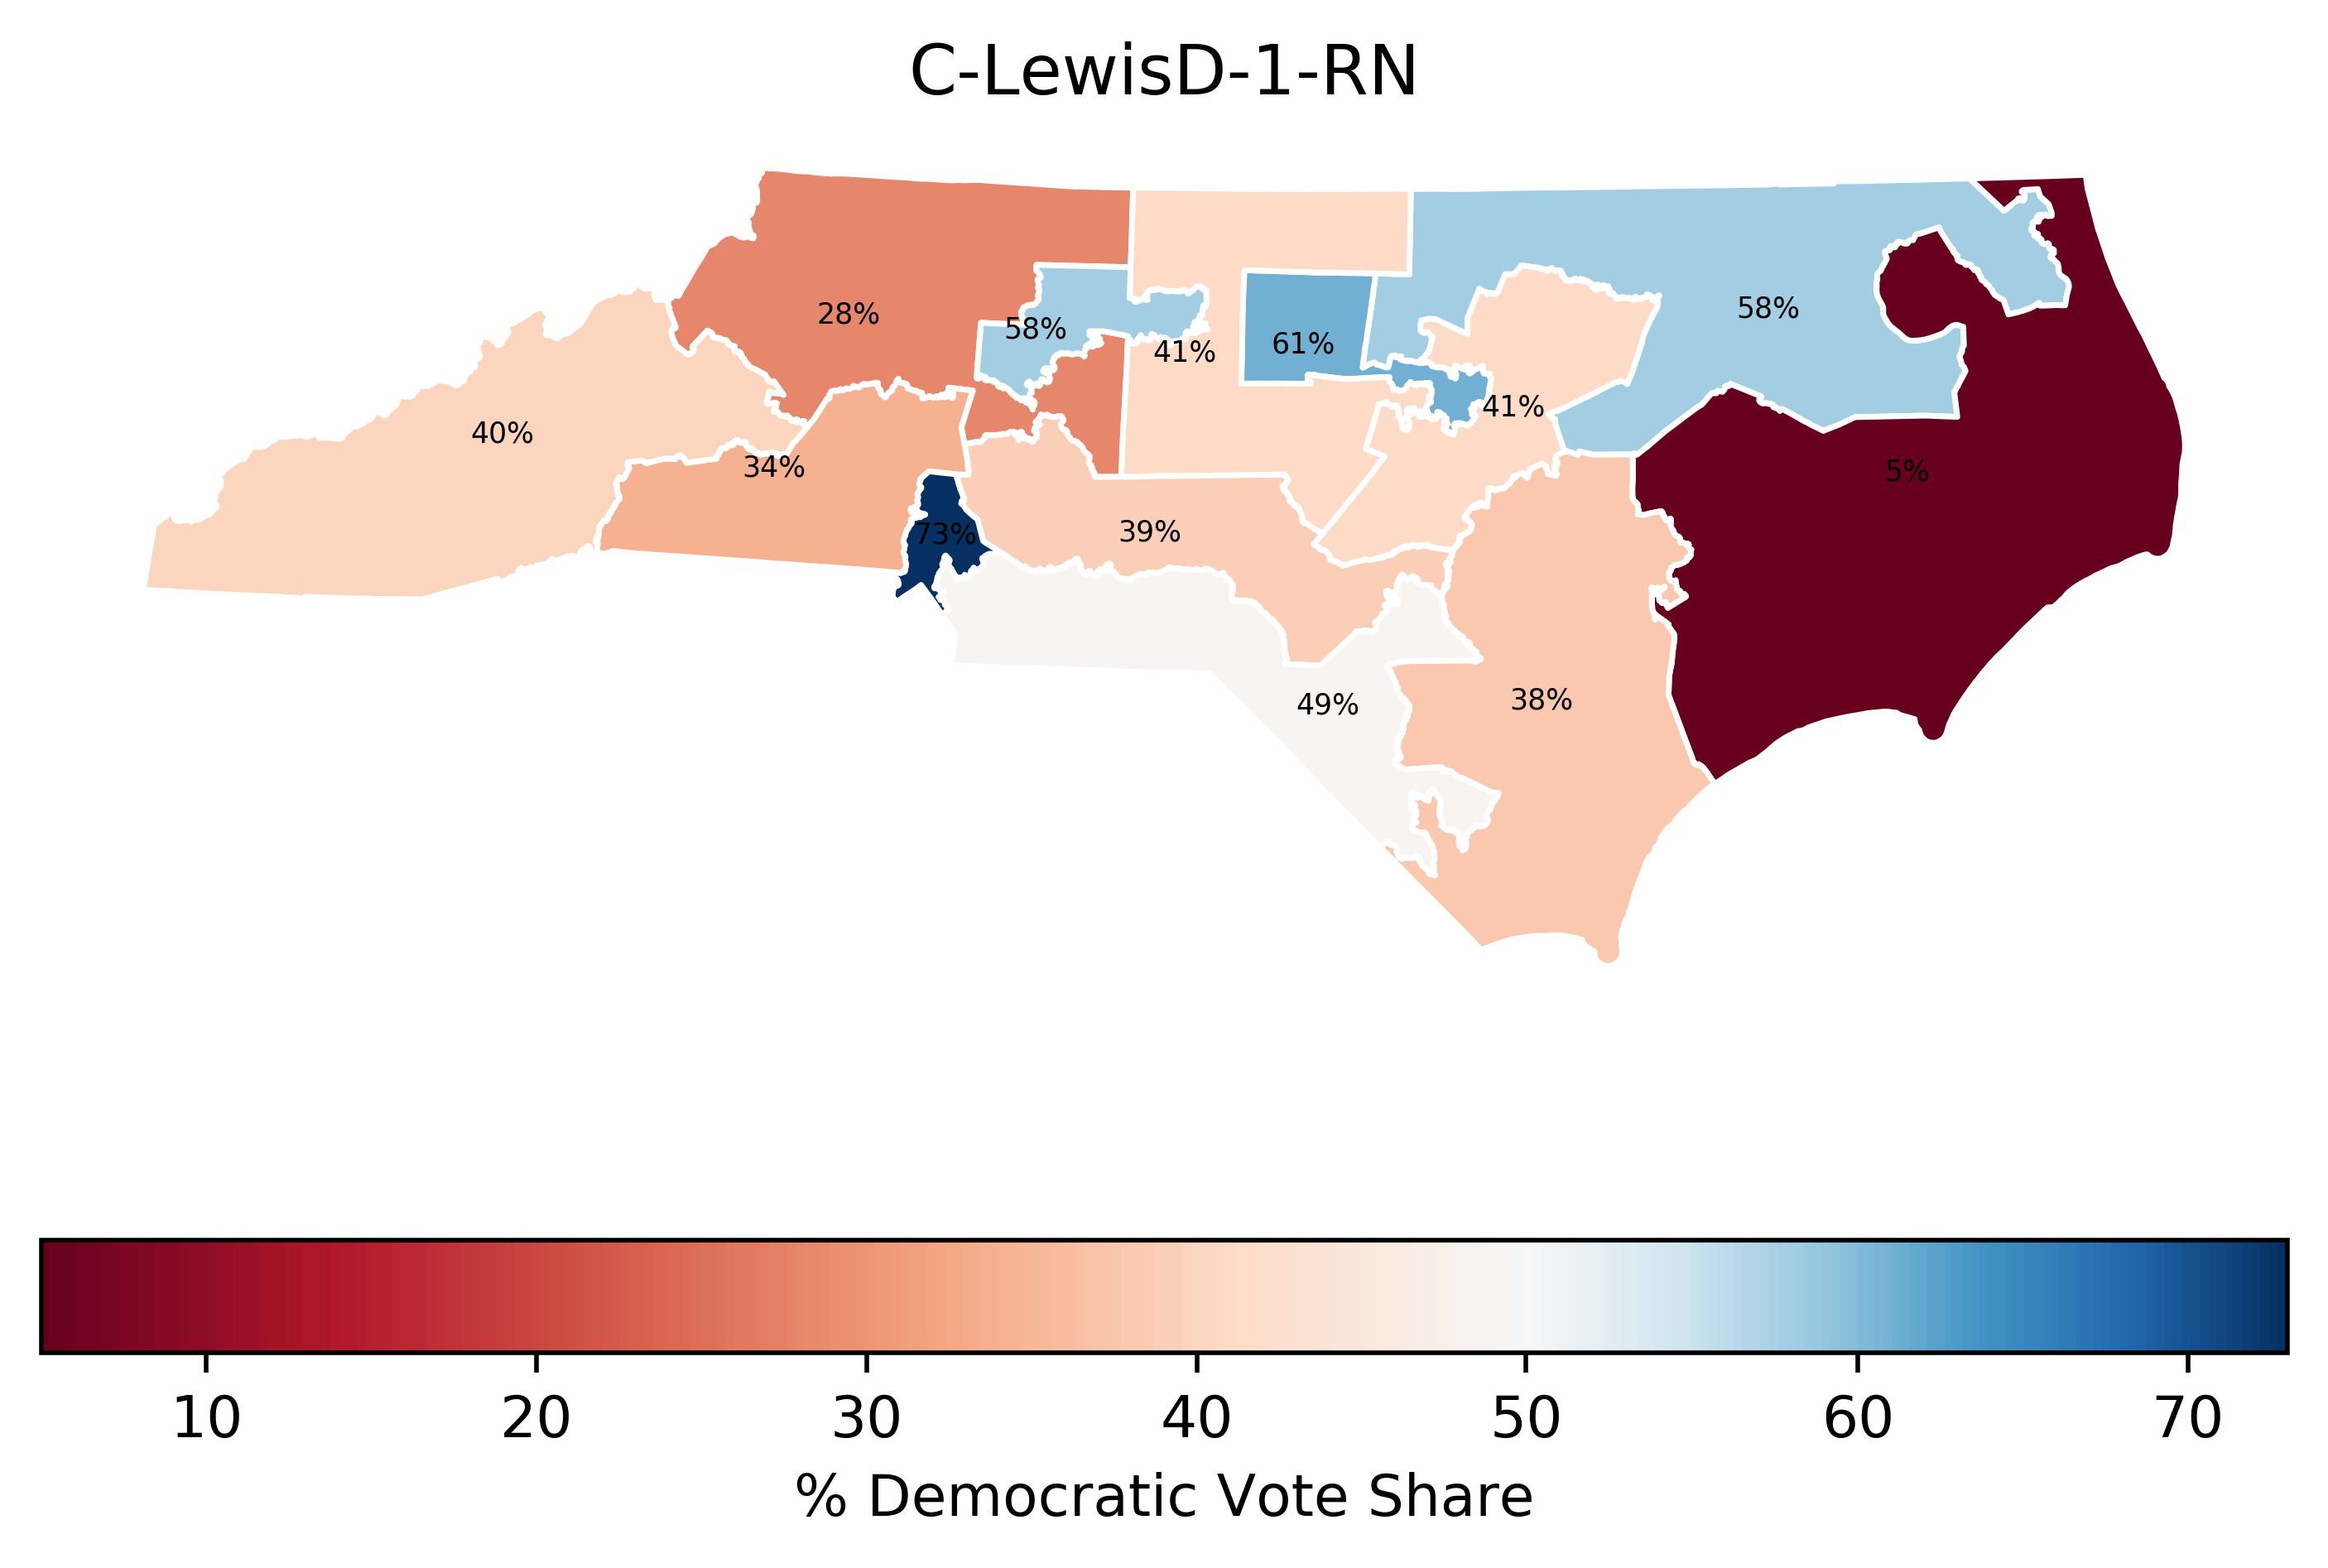

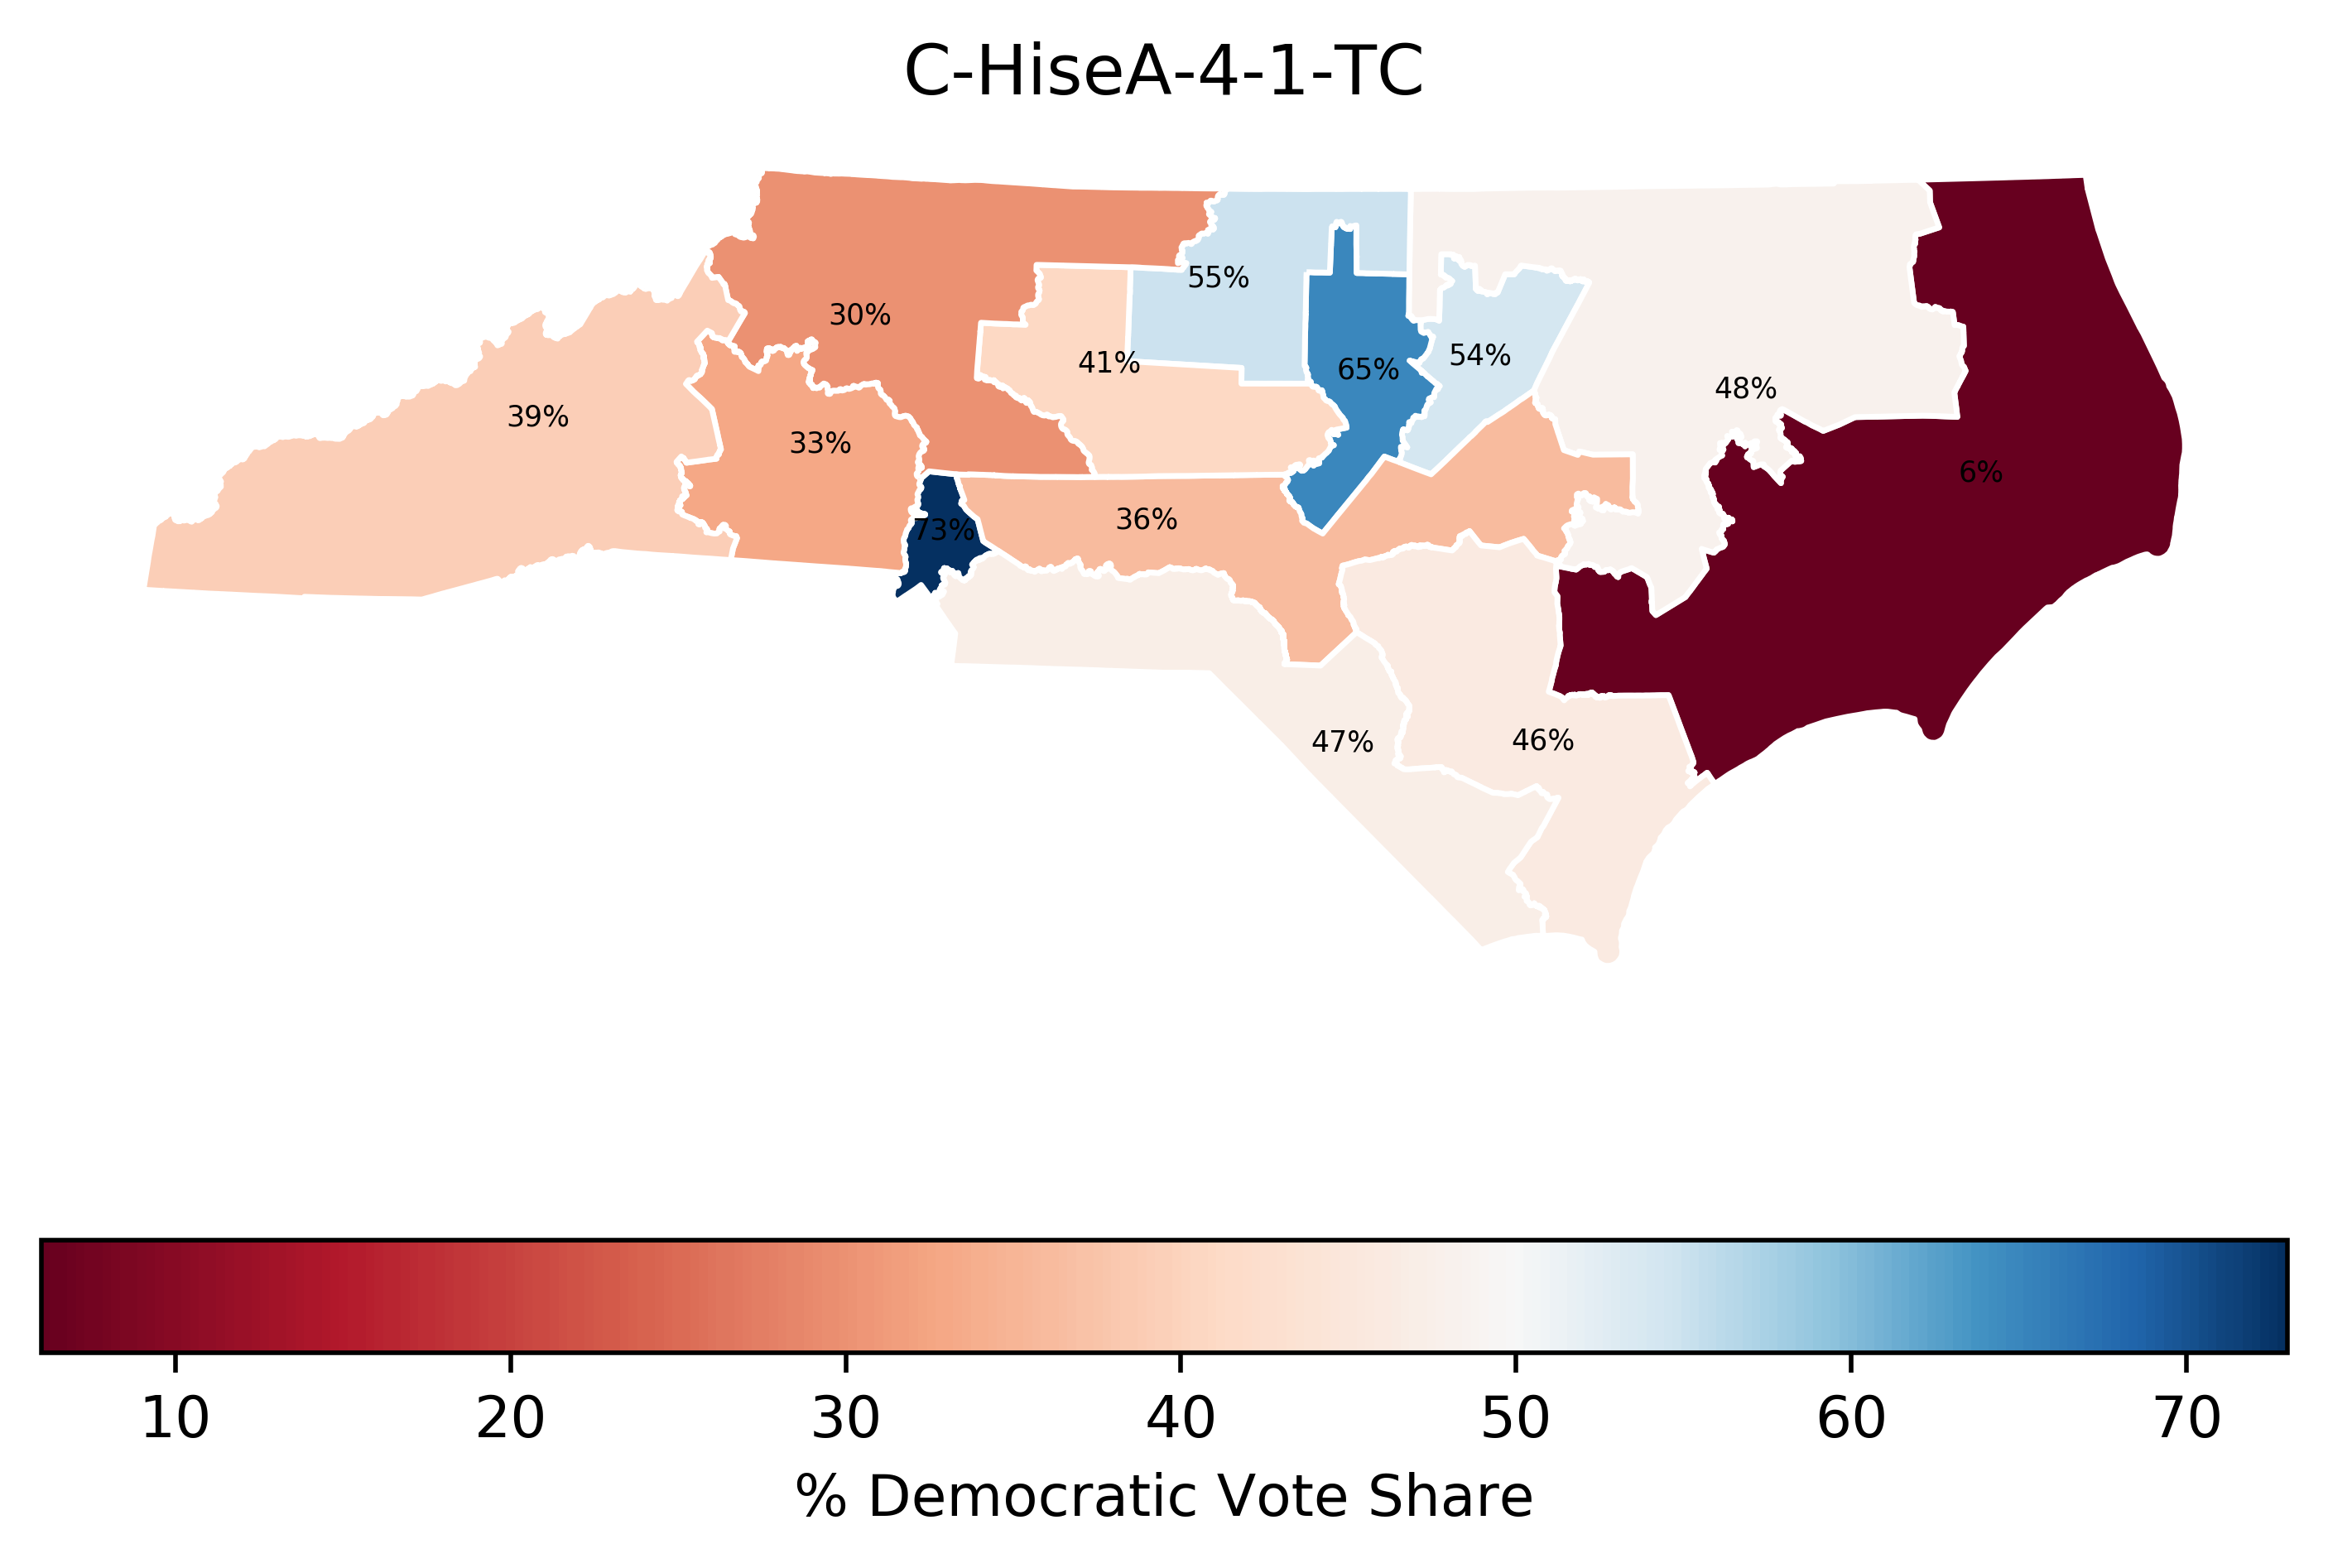

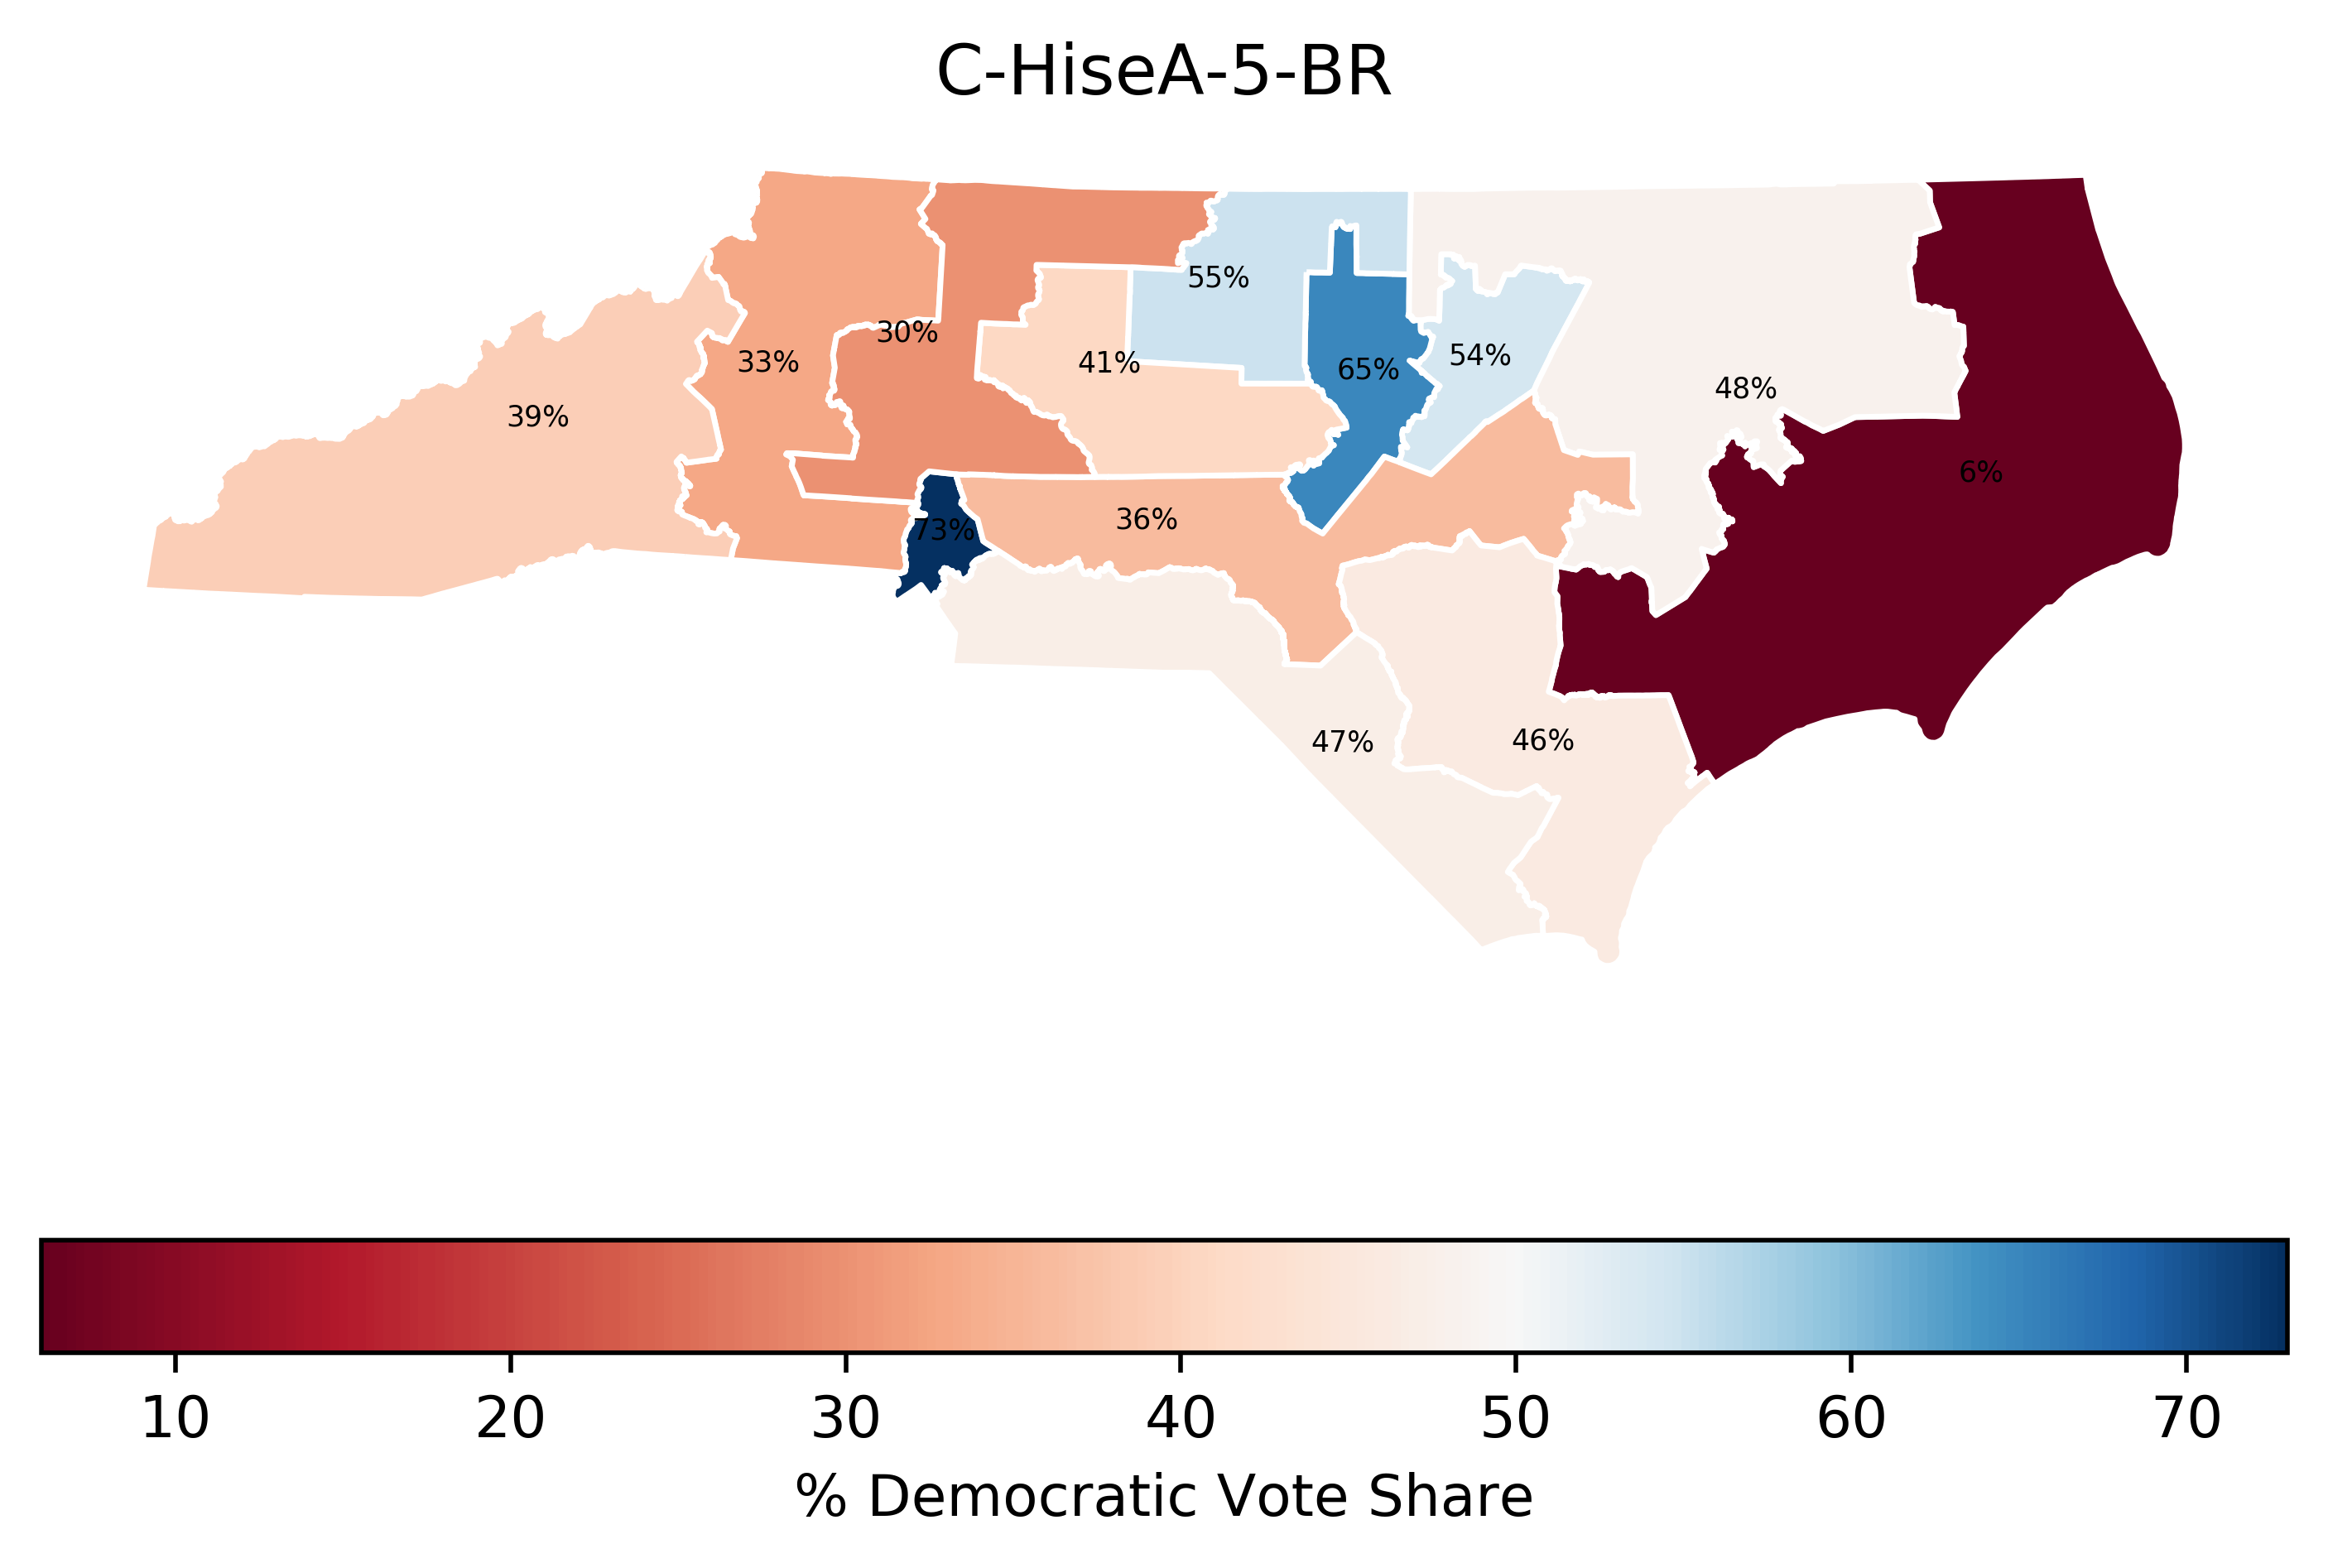

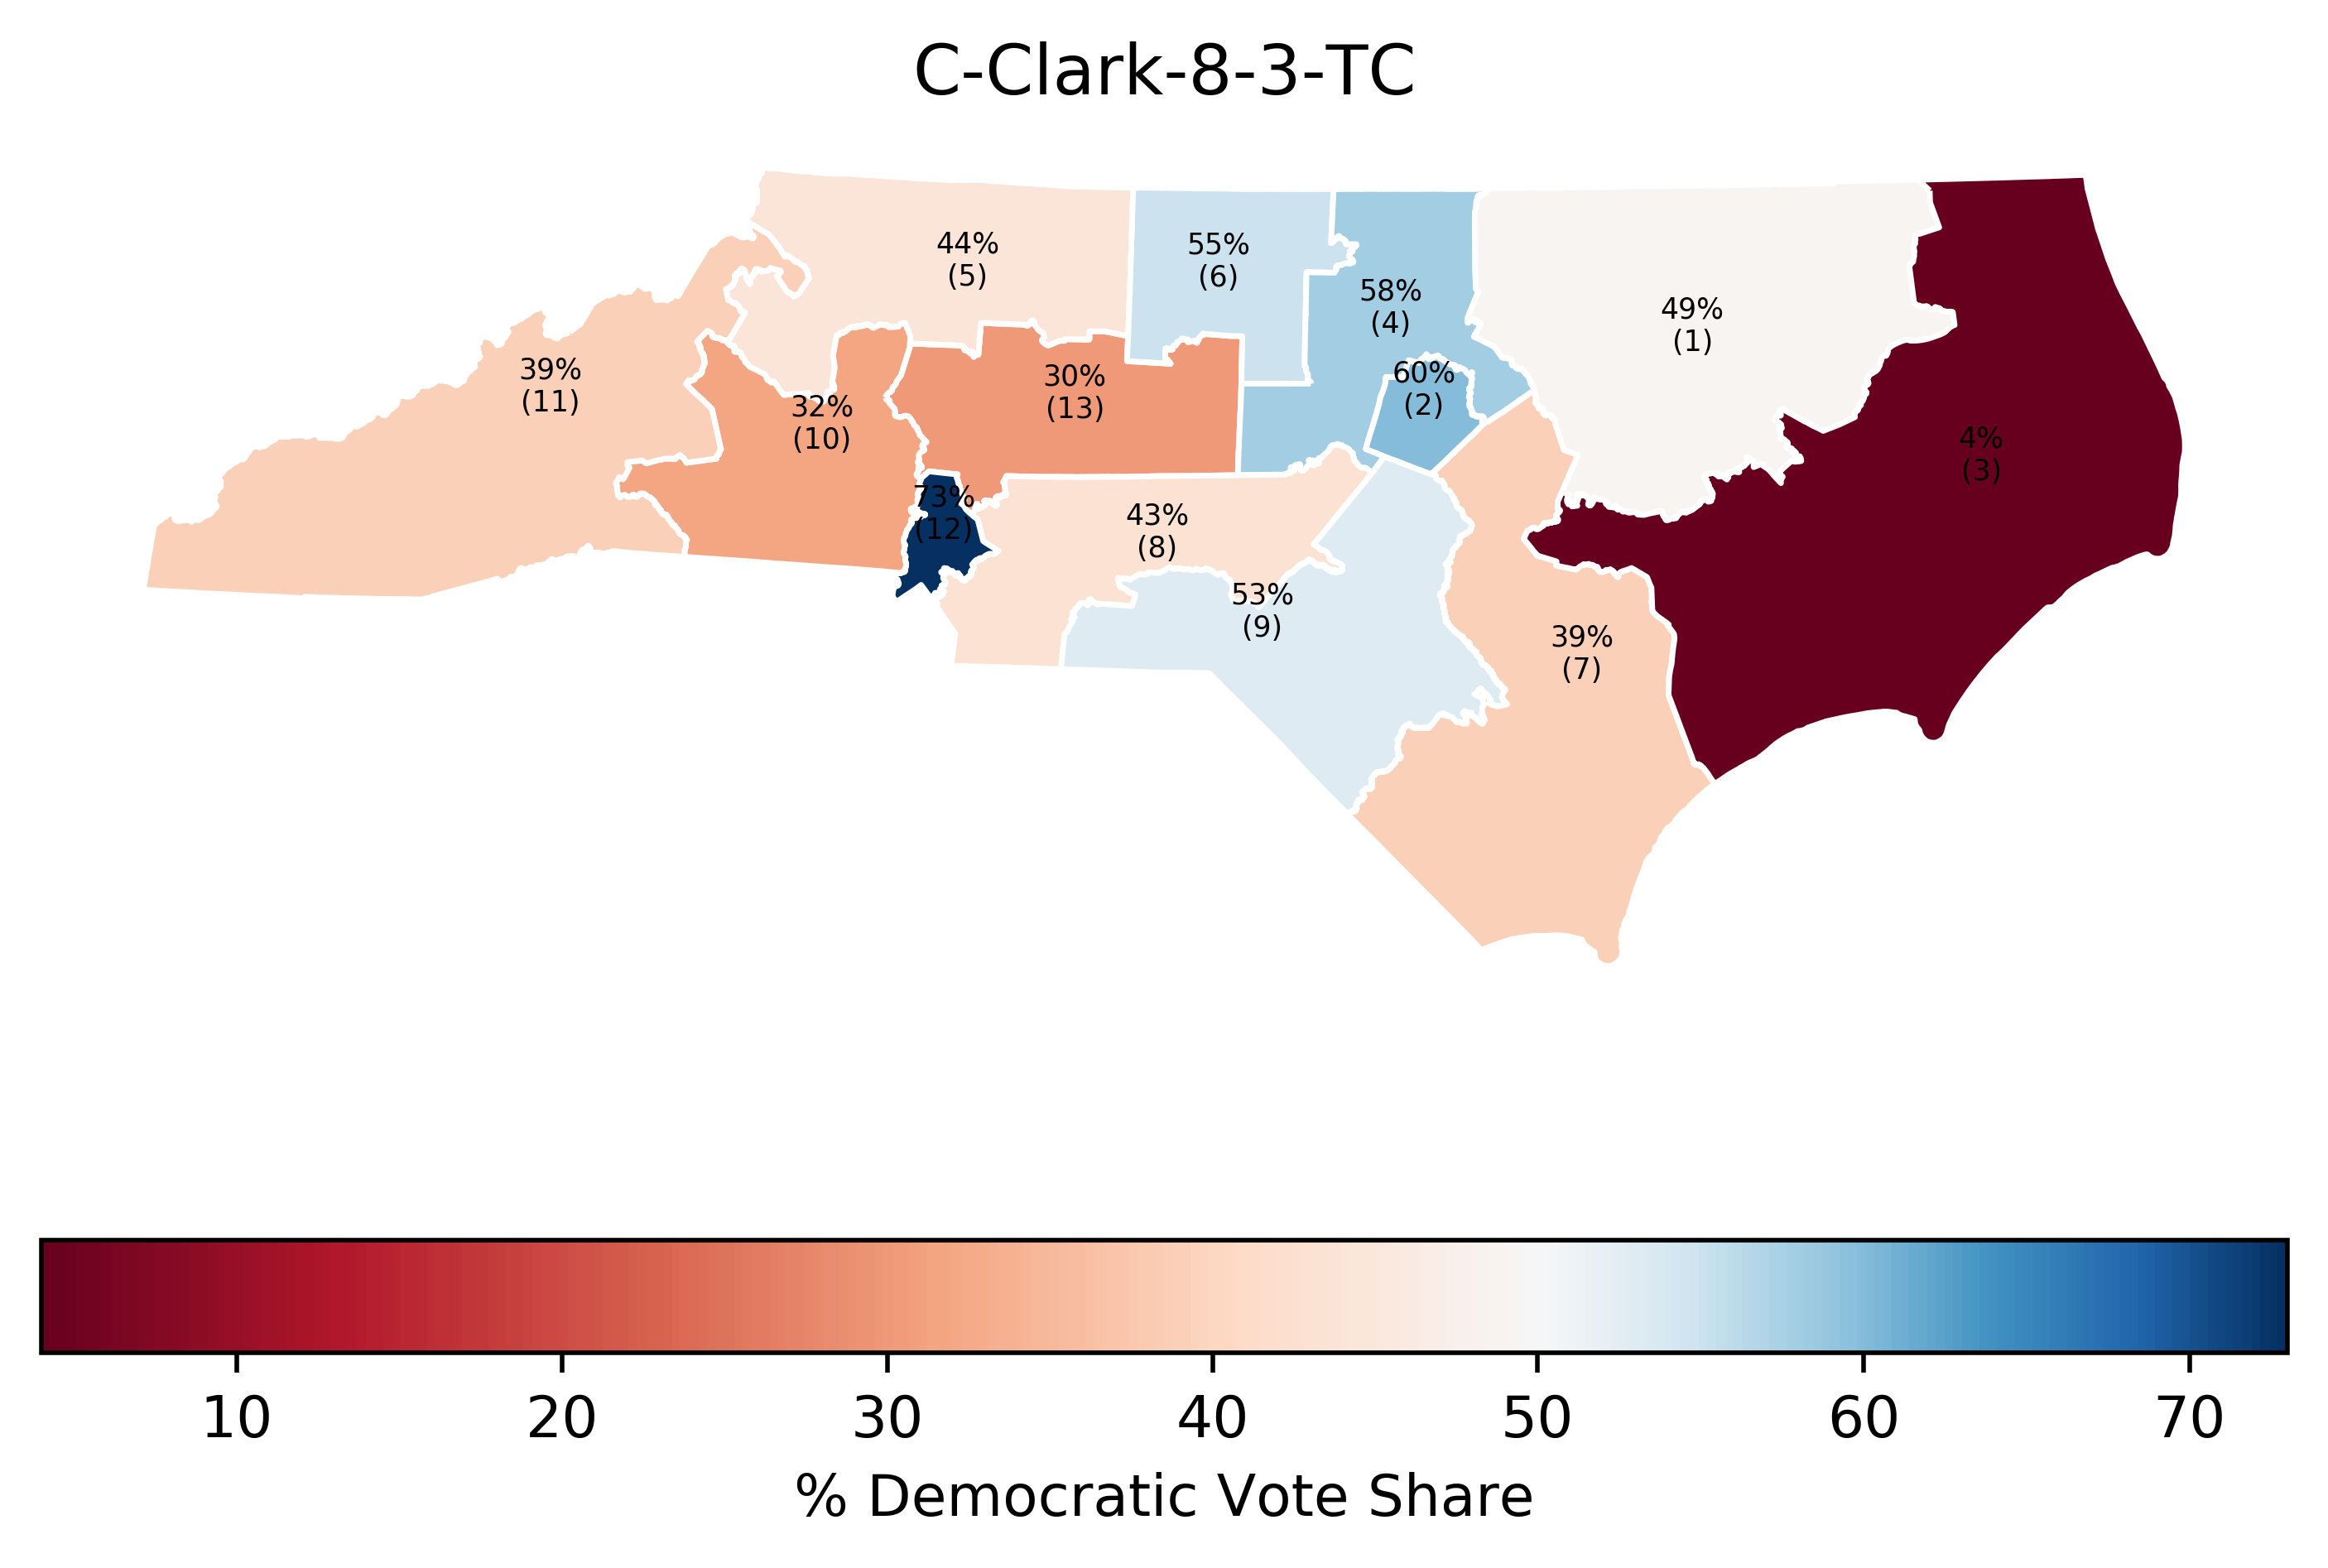

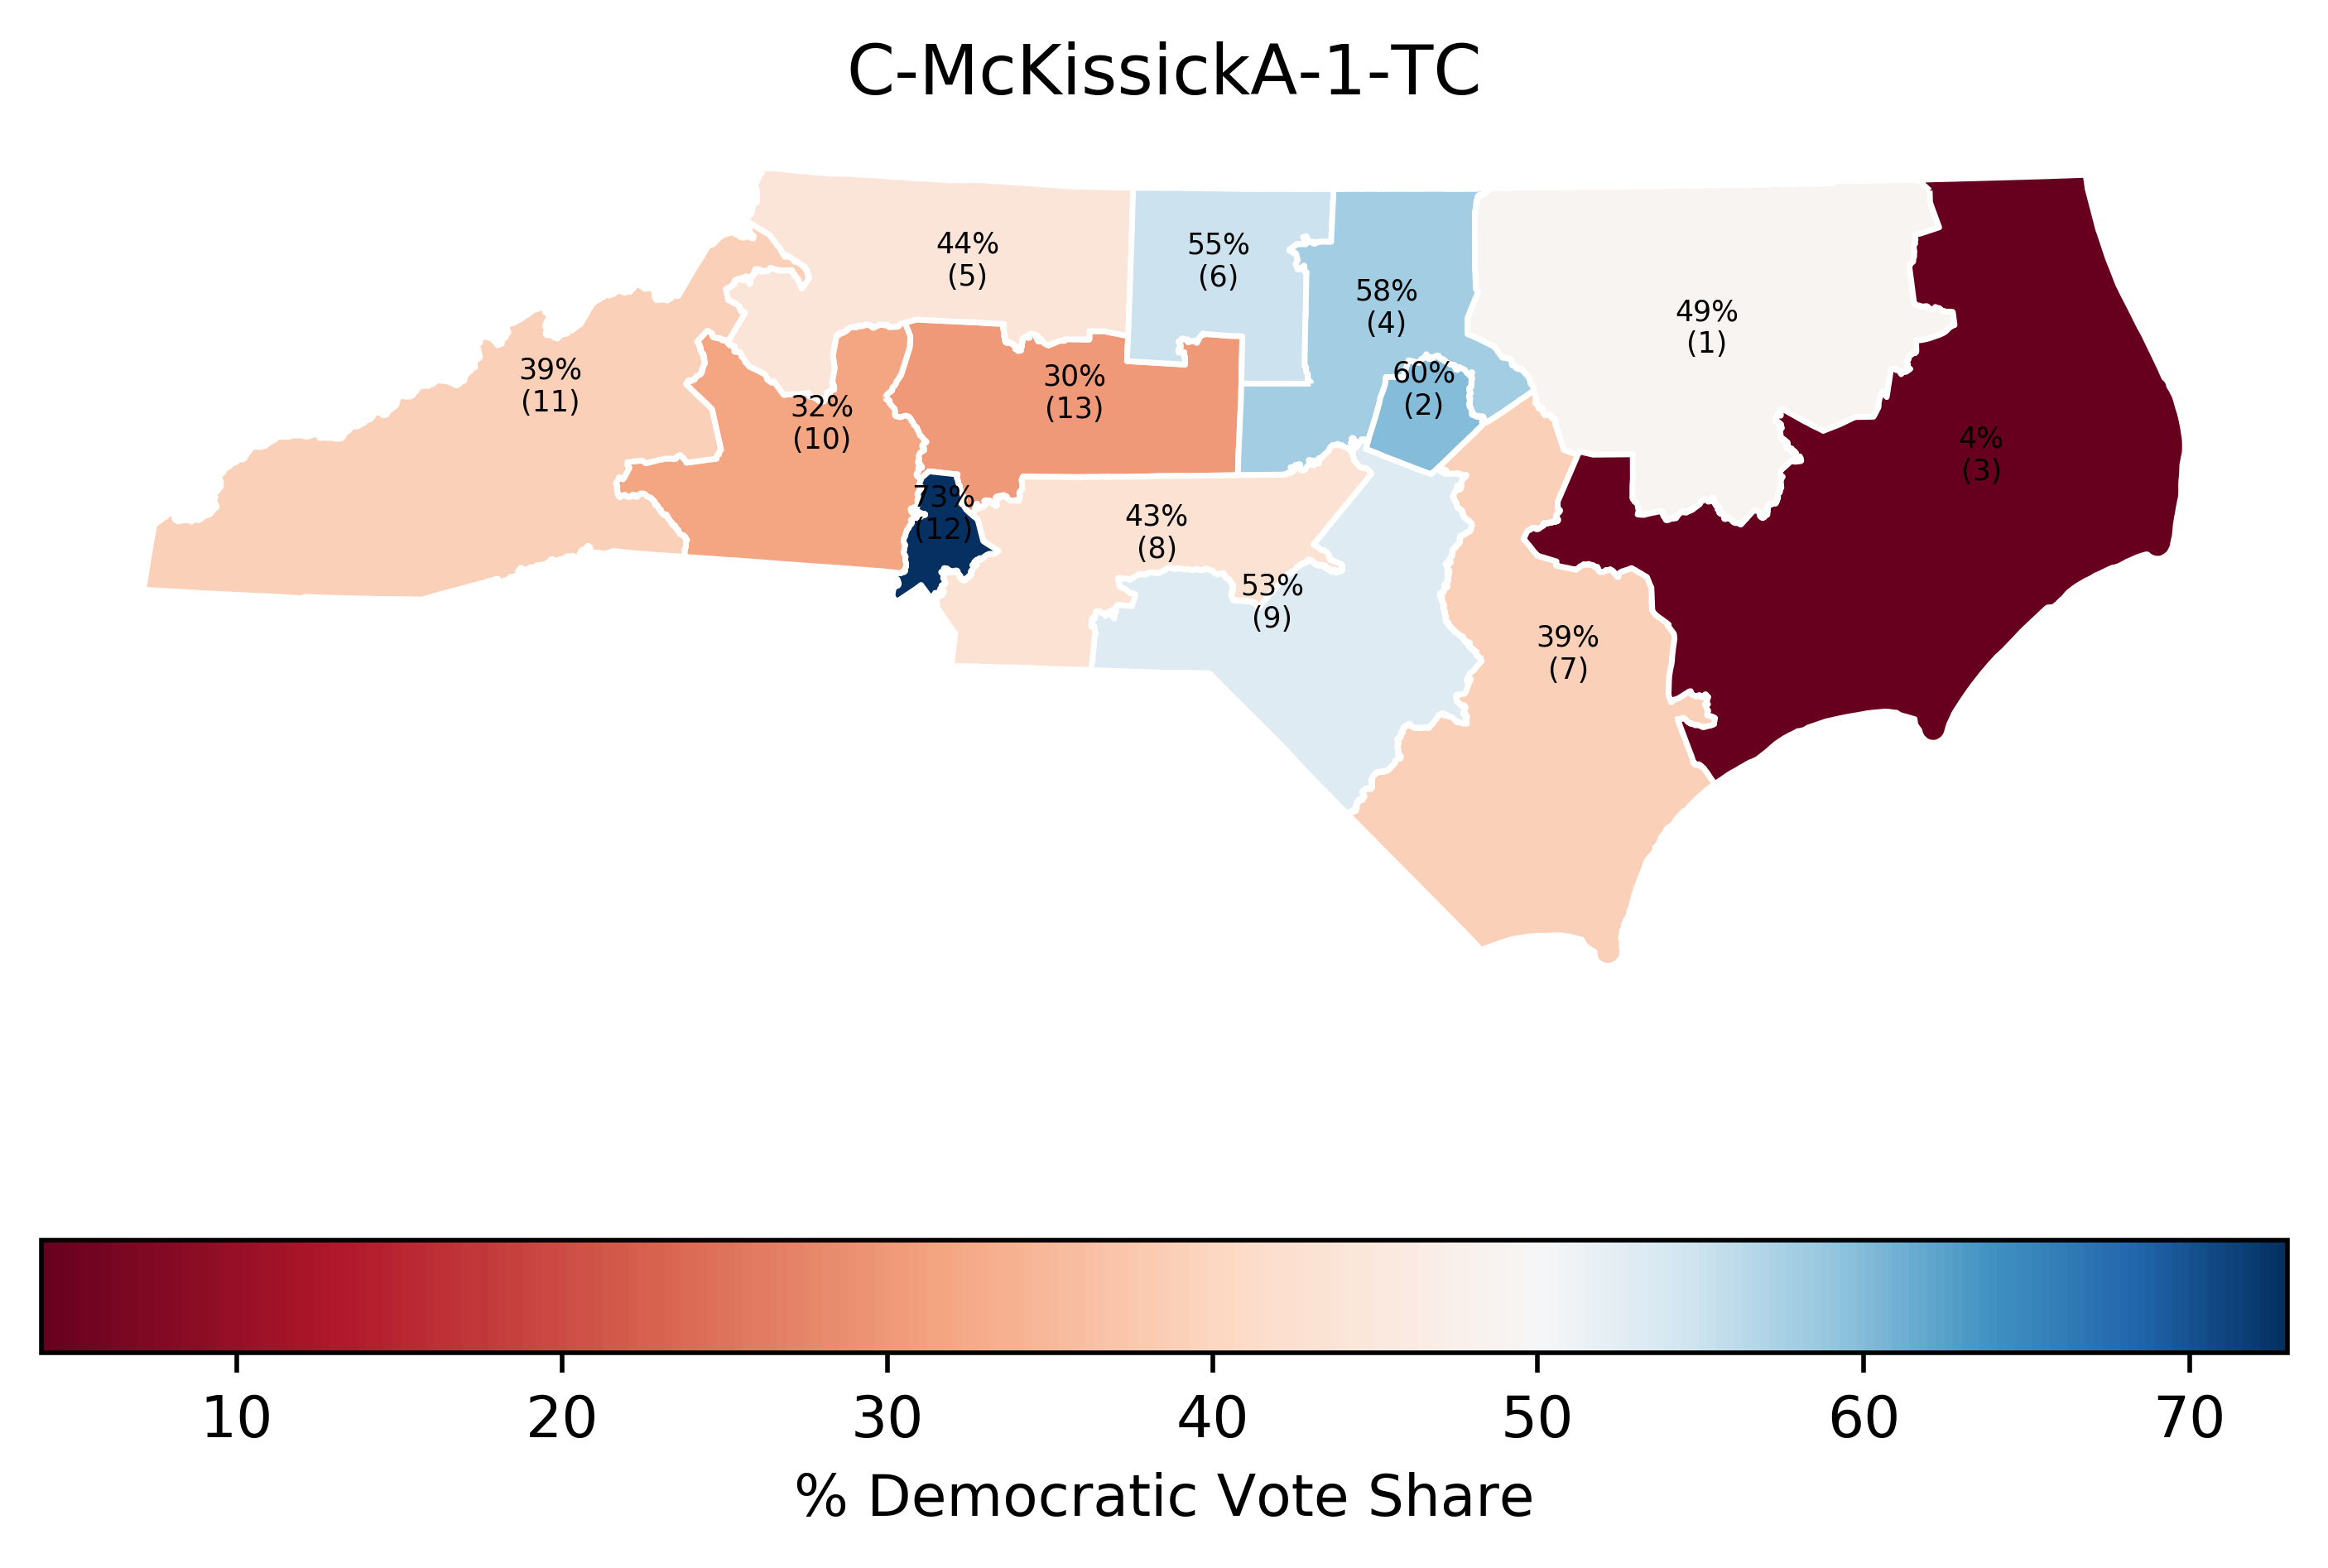

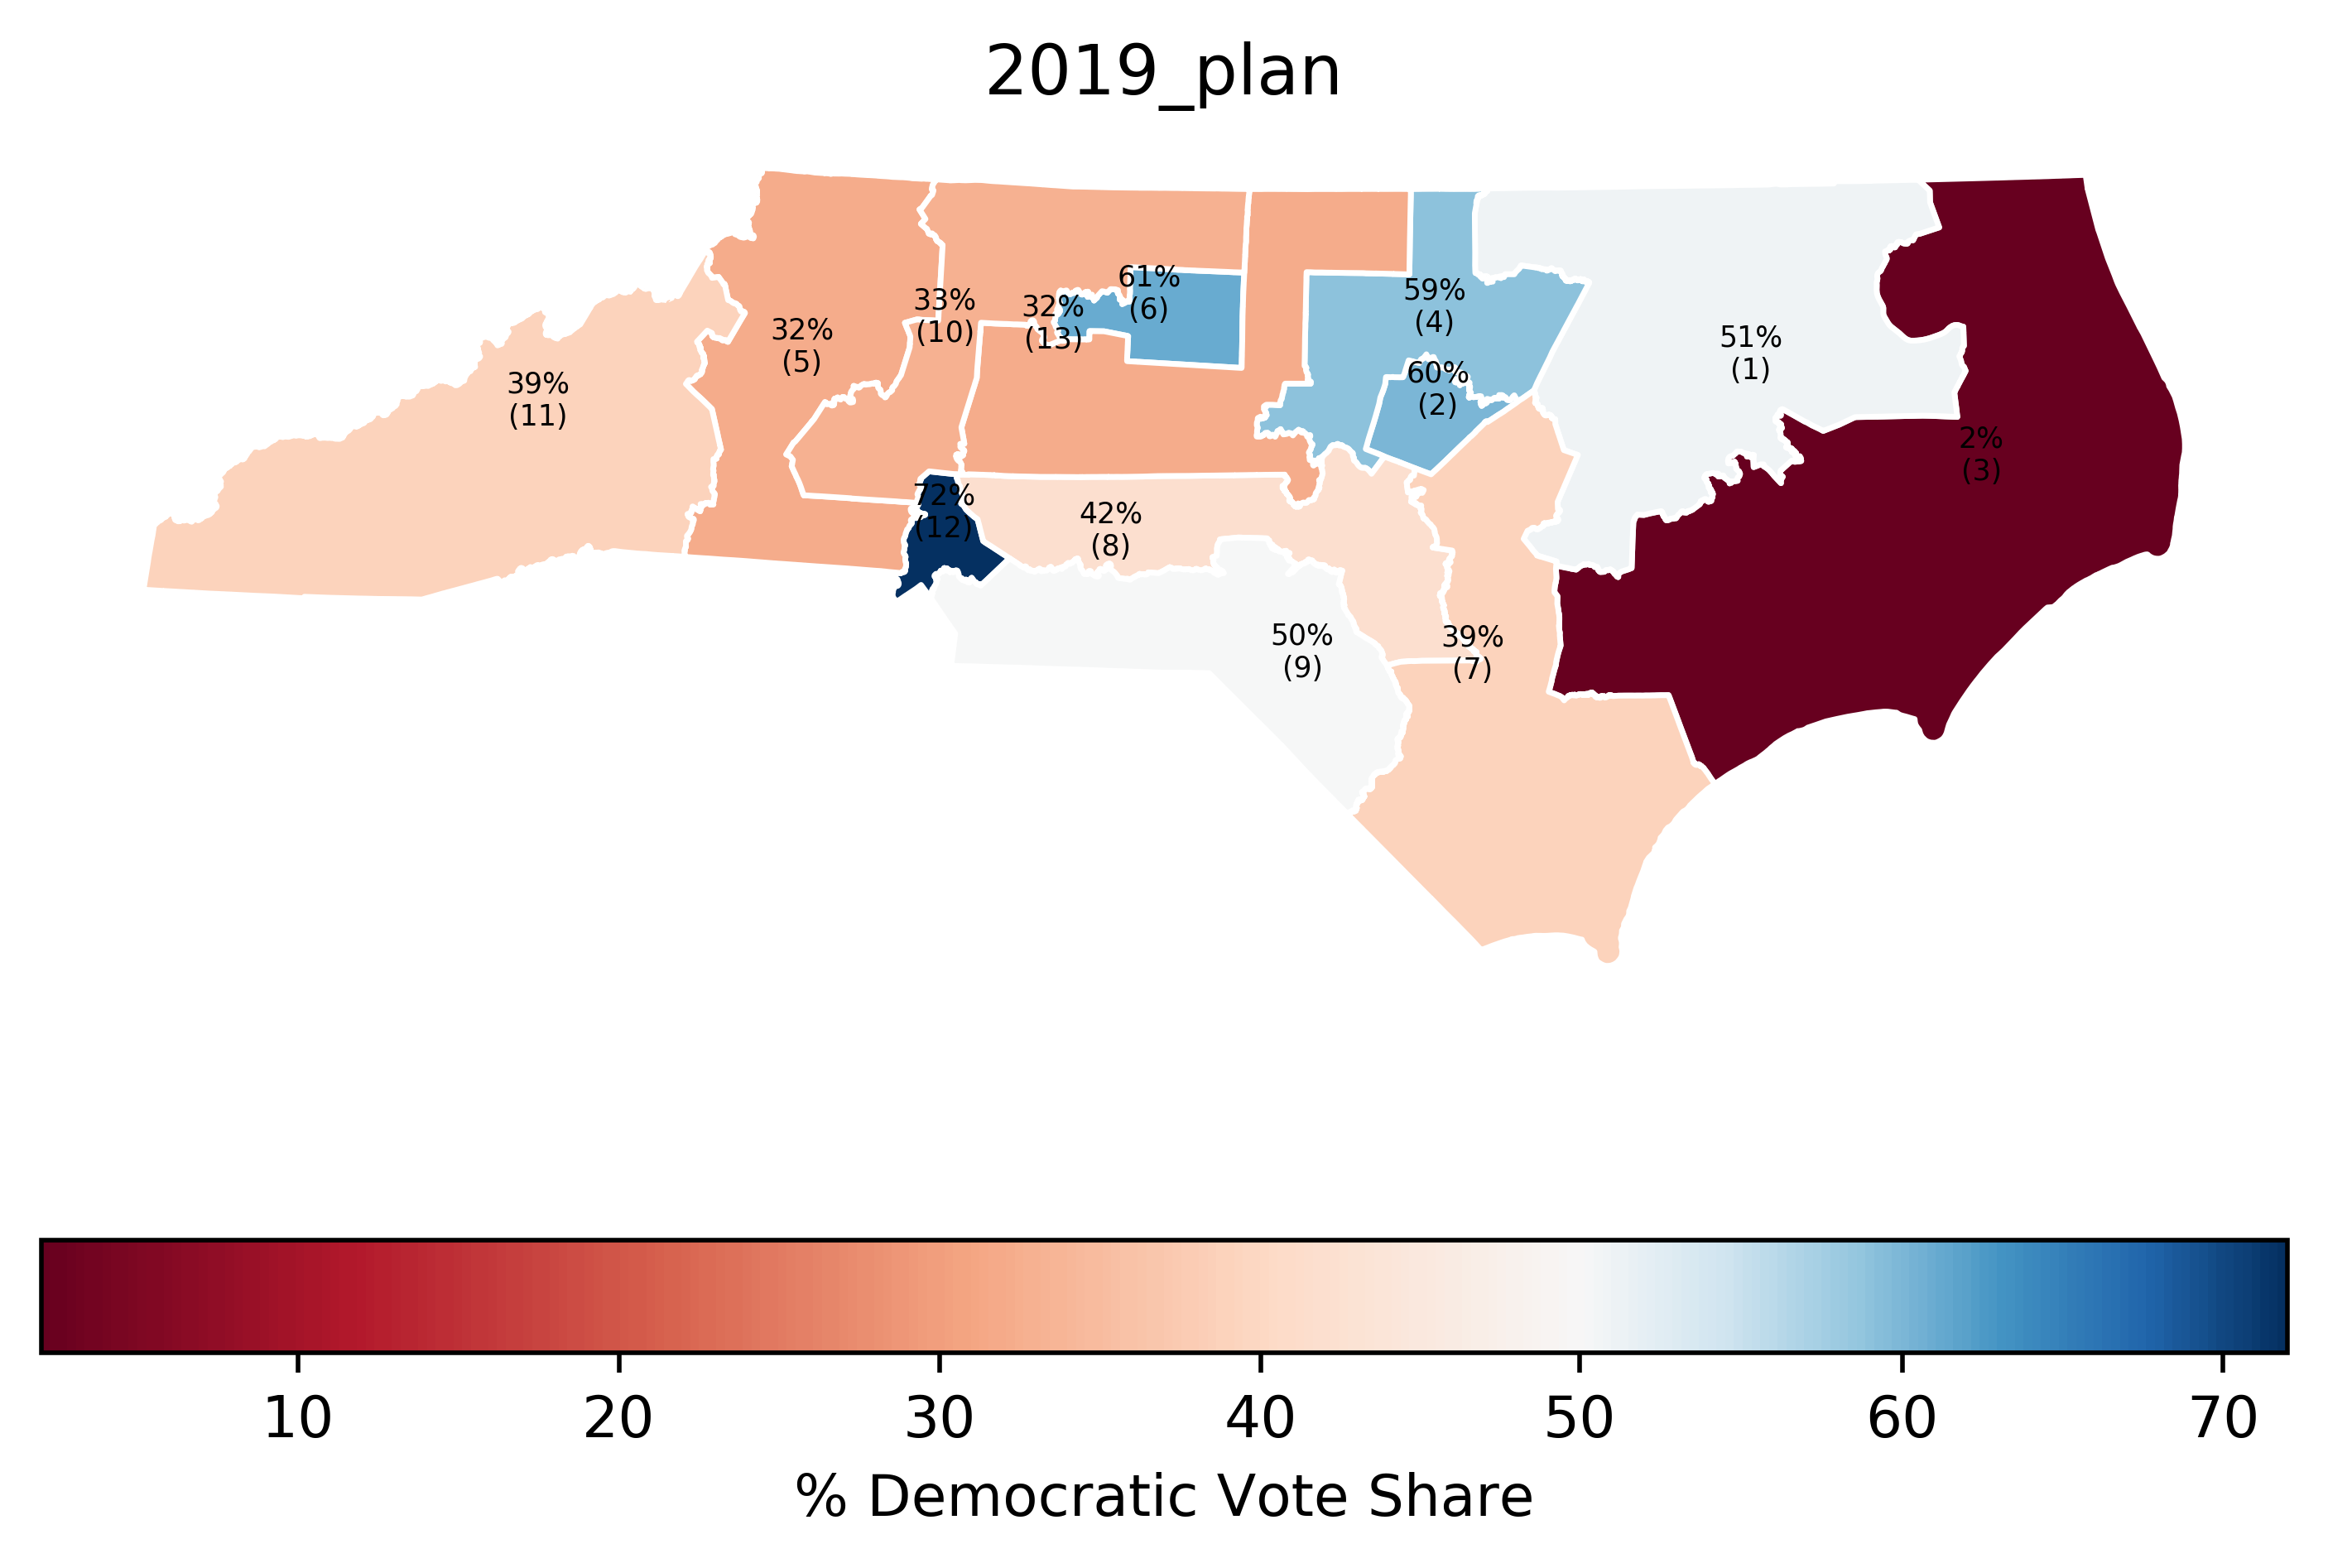

In [9]:
for key in files.keys():
    if (not key.startswith("2016")): # only the new maps
        planName = key
        plan = files[planName]
        plan["percentDem"] = round(plan["G18DHOR"]/(plan["G18DHOR"]+plan["G18RHOR"])*100).astype(np.int64)
        plan["percentDem_discrete"] = pd.cut(plan["percentDem"], bins=[0,15,25,35,45,55,65,75,85,100], labels=["0-15","15-25","25-35","35-45","45-55","55-65","65-75","75-85","85-100"])

        plan['coords'] = plan['geometry'].apply(lambda x: x.representative_point().coords[:])
        plan['coords'] = [coords[0] for coords in plan['coords']]

        f, ax = plt.subplots(1)
        ax.set_axis_off()
        plan.plot(column="percentDem", ax=ax, edgecolor='white', cmap='RdBu', norm=divnorm)
        for idx, row in plan.iterrows():
            label = ""
            try:
                label = str(row['percentDem'])+"%"+"\n(" + str(row['DISTRICT']) + ")"
            except:
                #print("An exception occurred")
                label = str(row['percentDem'])+"%"
            plt.annotate(s=label, xy=row['coords'], horizontalalignment='center', size=5)
        plt.title(planName)
        f.colorbar(cbar, ax=ax, label="% Democratic Vote Share", orientation='horizontal')
        plt.savefig("output/"+planName+".pdf", format="pdf")

If you took the option of saving each plot to a PDF, you can merge the files into one like to save just the plots in a file, run the following code to create a file named "NC congressional plots.pdf" that  contains all the maps.

In [11]:
# get list of all paths of plot pdfs
path = "output/"
x = [a for a in os.listdir(path) if a.endswith(".pdf")]
for i in range(len(x)):
    x[i] = path + x[i]
    
# merge all pdfs into one file
merger = PdfFileMerger()
for pdf in x:
    merger.append(open(pdf, 'rb'))

with open("output/NC congressional plots.pdf", "wb") as fout:
    merger.write(fout)

# Running Gerrymetrics

There isn't a universally agreed upon way to assess what a "fair" map is, but there are several measures that can be used to quantify a plan's "fairness". 

This section demonstrates how to apply various methods of quantifying gerrymandering to the proposed plans using the code implemented in [gerrymandertests](https://github.com/PrincetonUniversity/gerrymandertests). The most common tests are:

- **Mean-median difference**: a comparison of median and mean distribution. From [[Best et al.](https://www.liebertpub.com/doi/pdf/10.1089/elj.2016.0392)], "If all votes count the same, the median and mean have the same numerical value; if the median and mean differ, votes for the two major parties count differently as a consequence of being divided into districts."
    - **Equal vote weight**: Mean-median difference, but only if majority rule is violated; otherwise 0. [[Best et al.](https://www.liebertpub.com/doi/pdf/10.1089/elj.2016.0392)]
- **Declination**: reveals the difference between winning and losing a district, expressed as a fraction of 90 degrees. If declination is greater than about 0.3 in absolute value, it could indicate a partisan gerrymander. Positive values indicate a gerrymander that favors Republicans, negative indicates it favors Democrats. To understand declination, consider this graphic ([source](https://observablehq.com/@sahilchinoy/gerrymandering-the-declination-function)), created by ordering the Democratic vote shares of all the districts in increasing order along the horizontal axis and drawing lines for the "center of mass" of each party: <img src="img/declination.png" alt="declination" style="width: 400px;"/> Since the R line is relatively shallow while the line on the D side is relatively steep, the declination value of 0.48 indicates gerrymandering to favor Republicans has occurred.
    - **Buffered declination**: less sensitive in cases in which one party wins most of the votes
- **Efficiency gap (EG) & variants**: a comparison of wasted votes [[McGhee, 2014](https://onlinelibrary.wiley.com/doi/full/10.1111/lsq.12033)]. "Wasted" votes are any votes above the 50% mark for the winner, plus all votes for the loser. For example, For example, in a given district, if party A defeats party B by a 60-40 margin, party A wasted 10% of the votes cast, while all of party B’s votes were wasted. The EG would ideally be 0 in a non-gerrymandered system since both sides have the same number of wasted votes. $$EG = \frac{(total\:D \:wasted \:votes – total \:R \:wasted \:votes)}{total \:votes}$$ Check out this nice [explanation of EG](https://www.brennancenter.org/sites/default/files/legal-work/How_the_Efficiency_Gap_Standard_Works.pdf), too.
    - **Losing efficiency gap**: only counts losing votes (rather than surplus votes) as wasted
    - **Difference efficiency gap**: weight surplus votes by twice as much as losing votes. [[Nagle, 2017](https://www.liebertpub.com/doi/pdf/10.1089/elj.2016.0386)]
    - **Surplus efficiency gap**: only consider surplus votes wasted. Also called "winning efficiency." [[Cho, 2017](https://scholarship.law.upenn.edu/penn_law_review_online/vol166/iss1/2/)]
    - **Vote-centric efficiency gap**: each comparison is between the fraction of D votes that are wasted to fraction of R votes wasted, rather than a comparison between the absolute amounts. [[Nagle, 2017](https://www.liebertpub.com/doi/pdf/10.1089/elj.2016.0386)]
- **Partisan bias**: comparison of seat share at 50% of the statewide votal. This measure essentially looks at the number of seats a party would have won in a hypothetical election in which the vote was evenly split between Republicans and Democrats. In the 2018 North Carolina US House election, Democrats won 45.3% of votes and 23% of seats. In a hypothetical election in which Democrats won 50% of votes, they would have won a certain percent of seats. Partisan bias is the difference between this hypothetical percent of seats and an even split in seats.

See [Warrington, 2018](https://arxiv.org/abs/1805.12572) for more details and comparison of these metrics. Warrington concludes three main points:
1. "None of the “wasted-votes” variations of the efficiency gap appear to markedly improve upon it."
2. "Two of the other most widely cited measures, partisan bias and the mean-median difference, struggle in a number of ways."
3. "The recently proposed declination measure performs robustly on the entire slate of elections we consider in this article and is therefore our recommendation for a general-purpose measure."

None of these measures are perfect, but can still be useful.

In [12]:
from collections import defaultdict
import gerrymetrics as g

metric_dict = {'t_test_diff':            g.t_test_diff,
               'mean_median_diff':       g.mean_median,
               'declination':            g.declination,
               'declination_buffered':   g.bdec,
               'efficiency_gap':         g.EG,
               'loss_gap':               g.EG_loss_only,
               'difference_gap':         g.EG_difference,
               'surplus_gap':            g.EG_surplus_only,
               'vote_centric_gap':       g.EG_vote_centric,
               'partisan_bias':          g.partisan_bias,
               'equal_vote_weight_bias': g.equal_vote_weight}

# impute uncontested races at a voteshare of 0 or 1; in other words, don't impute them
impute_val = 1

I'll make a dataframe with three columns:
- Plan name
- D voteshare: a list of the voteshares for each district
- District Numbers: a list of district numbers
- Dseats: number of Democratic seats won

where each row is a different plan.

Next we can calculate the overall D voteshare for this election:

In [13]:
plan = files[planName]
plan = pd.DataFrame(plan) # convert back to dataframe
plan["D Voteshare"] = round(plan["G18DHOR"]/(plan["G18DHOR"]+plan["G18RHOR"]),4)
totalRvotes = plan[['G18RHOR']].sum()[0]
totalDvotes = plan[['G18DHOR']].sum()[0]
voteshare = totalDvotes/(totalDvotes+totalRvotes)
voteshare

0.45267329641793236

In [14]:
voteshareDF = pd.DataFrame(columns=['Plan', 'D Voteshare', 'District Numbers', 'Dseats'])
i = 0

for key in files.keys():
    planName = key
    plan = files[planName]
    plan = pd.DataFrame(plan) # convert back to dataframe
    plan["D Voteshare"] = round(plan["G18DHOR"]/(plan["G18DHOR"]+plan["G18RHOR"]),4) # calculate voteshare per district
    try:
        plan = plan[['DISTRICT','D Voteshare']]
    except: # if no DISTRICT column, create arbitrary district numbers from index
        plan["DISTRICT"] = plan.index
        plan = plan[['DISTRICT','D Voteshare']]
    
    DVoteshareList = plan['D Voteshare'].tolist() # create list of district voteshares
    districtList = plan['DISTRICT'].tolist() # create list of district number
    
    # get number of D seats won
    Dseats = 0
    for i in DVoteshareList: 
        if (i > .5):
            Dseats = Dseats + 1

    voteshareDF.loc[i] = [planName] + [DVoteshareList] + [districtList] + [Dseats]
        
    i = i+1

voteshareDF = voteshareDF.reset_index(drop=True)

In [15]:
voteshareDF

Plan  \
0                              C-NewtonA-5-4-TC   
1                                     2019_plan   
2                                C-Clark-9-6 RN   
3                             C-McKissickA-1-TC   
4                    C-Farmer-ButterfieldC-1-BK   
5                                 C-LewisD-1-RN   
6                  C-Farmer-ButterfieldA-1-3-BK   
7                                  C-HiseA-5-BR   
8  2016_Contingent_Congressional_Plan_Corrected   

                                         D Voteshare  \
0  [0.7197, 0.5968, 0.0309, 0.4734, 0.6135, 0.413...   
1  [0.7197, 0.5968, 0.0238, 0.5135, 0.5855, 0.417...   
2  [0.3013, 0.4376, 0.5471, 0.6277, 0.5598, 0.490...   
3  [0.3015, 0.4352, 0.5477, 0.5836, 0.5975, 0.489...   
4  [0.2876, 0.429, 0.5501, 0.6416, 0.5609, 0.4741...   
5  [0.5758, 0.4091, 0.0451, 0.6113, 0.2825, 0.414...   
6  [0.3124, 0.4603, 0.5086, 0.6422, 0.5609, 0.477...   
7  [0.7274, 0.541, 0.0572, 0.4784, 0.6482, 0.358,...   
8  [0.6325, 0.4114, 0.0001, 0.6803, 0.4267, 0.413...   

                              District Numbers Dseats  
0  [12, 2, 3, 1, 4, 8, 7, 9, 6, 13, 5, 10, 11]      4  
1  [12, 2, 3, 1, 4, 8, 7, 9, 6, 13, 5, 10, 11]      5  
2  [13, 5, 6, 4, 2, 1, 7, 3, 8, 9, 12, 10, 11]      5  
3  [13, 5, 6, 4, 2, 1, 7, 3, 8, 9, 12, 10, 11]      5  
4  [13, 5, 6, 4, 2, 1, 7, 3, 8, 9, 12, 10, 11]      5  
5   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]      4  
6  [13, 5, 6, 4, 2, 1, 7, 3, 8, 9, 12, 10, 11]      5  
7   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]      4  
8   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]      3

In [16]:
# column names for results data frame
cols = list(metric_dict.keys())
cols.insert(0, "Plan")
cols.insert(1, "Dseats")

# initial empty results data frame
results = pd.DataFrame(columns=cols)

In [17]:
for index, row in voteshareDF.iterrows():
    vs = row['D Voteshare']
    vs = np.array(list(vs))
    metrics_out = []
    i = 0
    for metric, f in metric_dict.items():
        metrics_out.insert(i, round(f(vs), 4))
        i = i+1

    metrics_out
    results.loc[index] = [row['Plan']] + [row['Dseats']] + metrics_out

In [18]:
results

Plan Dseats  t_test_diff  \
0                              C-NewtonA-5-4-TC      4      -0.0126   
1                                     2019_plan      5      -0.0583   
2                                C-Clark-9-6 RN      5      -0.0508   
3                             C-McKissickA-1-TC      5      -0.0521   
4                    C-Farmer-ButterfieldC-1-BK      5      -0.0523   
5                                 C-LewisD-1-RN      4      -0.0251   
6                  C-Farmer-ButterfieldA-1-3-BK      5      -0.0556   
7                                  C-HiseA-5-BR      4      -0.0215   
8  2016_Contingent_Congressional_Plan_Corrected      3       0.0524   

   mean_median_diff  declination  declination_buffered  efficiency_gap  \
0            0.0256       0.2020                0.0729          0.0710   
1            0.0221       0.0076               -0.0436         -0.0049   
2            0.0084       0.0139               -0.0358          0.0074   
3            0.0103       0.0106               -0.0383          0.0063   
4            0.0039       0.0122               -0.0376          0.0050   
5            0.0254       0.1741                0.0501          0.0613   
6           -0.0155      -0.0014               -0.0466          0.0049   
7           -0.0181       0.1717                0.0506          0.0725   
8            0.0296       0.4332                0.2173          0.1548   

   loss_gap  difference_gap  surplus_gap  vote_centric_gap  partisan_bias  \
0    0.1316          0.0103      -0.0607            0.2672         0.0385   
1    0.0552         -0.0651      -0.0602            0.1121         0.0385   
2    0.0614         -0.0466      -0.0540            0.1242         0.0385   
3    0.0609         -0.0482      -0.0545            0.1232         0.0385   
4    0.0602         -0.0501      -0.0552            0.1219         0.0385   
5    0.1268         -0.0042      -0.0655            0.2580         0.1154   
6    0.0601         -0.0504      -0.0552            0.1218        -0.0385   
7    0.1324          0.0126      -0.0599            0.2686        -0.0385   
8    0.2120          0.0976      -0.0572            0.4297         0.1154   

  equal_vote_weight_bias  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
5                      0  
6                      0  
7                      0  
8                      0

Note that since the equal vote weight bias is 0 in all plans, this means majority rule is never violated. Also, all of the declination values, except for the `C-Farmer-ButterfieldA-1-3-BK` plan are positive, meaning favoring Republicans. However, the declination for the 2019 plan (.008) is significantly lower than the 2016 plan (.433).

Now let's make a dataframe of the percentiles of each column:

In [19]:
# column names for results data frame
cols = list(metric_dict.keys())
cols.insert(0, "Plan")
cols.insert(1, "Dseats")

# initial empty results data frame
percentiles = pd.DataFrame(columns=cols)

In [20]:
for r in range(1, len(cols)):
    percentiles[cols[r]] = [stats.percentileofscore(results[cols[r]].values, i) for i in results[cols[r]].values]
    percentiles[cols[r]] = percentiles[cols[r]].astype("int64") # round to nearest integer

percentiles['Plan'] = results['Plan']
percentiles

Plan  Dseats  t_test_diff  \
0                              C-NewtonA-5-4-TC      33           88   
1                                     2019_plan      77           11   
2                                C-Clark-9-6 RN      77           55   
3                             C-McKissickA-1-TC      77           44   
4                    C-Farmer-ButterfieldC-1-BK      77           33   
5                                 C-LewisD-1-RN      33           66   
6                  C-Farmer-ButterfieldA-1-3-BK      77           22   
7                                  C-HiseA-5-BR      33           77   
8  2016_Contingent_Congressional_Plan_Corrected      11          100   

   mean_median_diff  declination  declination_buffered  efficiency_gap  \
0                88           88                    88              77   
1                66           22                    22              11   
2                44           55                    55              55   
3                55           33                    33              44   
4                33           44                    44              33   
5                77           77                    66              66   
6                22           11                    11              22   
7                11           66                    77              88   
8               100          100                   100             100   

   loss_gap  difference_gap  surplus_gap  vote_centric_gap  partisan_bias  \
0        77              77           22                77             55   
1        11              11           33                11             55   
2        55              55          100                55             55   
3        44              44           88                44             55   
4        33              33           72                33             55   
5        66              66           11                66             94   
6        22              22           72                22             16   
7        88              88           44                88             16   
8       100             100           55               100             94   

   equal_vote_weight_bias  
0                      55  
1                      55  
2                      55  
3                      55  
4                      55  
5                      55  
6                      55  
7                      55  
8                      55

The percentile is a measure indicating the value below which a given percentage of observations in a group of observations falls. Some key takeaways from the above tables:
- __Mean-median difference__: 66% of the plans' scores fall below the `mean_median_diff` score of the 2019 plan. 
- __Efficiency gap__: only 11% of the plans had a smaller efficiency gap than the 2019 plan (recall: a lower efficiency gap means a more fair plan).
- __Partisan bias__: The 2019 plan had the same partisan bias as 4 of the other proposed plans. In addition to the 2019 plan, 4 of the proposed plans had a partisan bias of 0.0385. Only one other proposed plan—and the 2016 plan—had a higher partisan bias. 2 of the plans actually had a negative partisan bias (-0.0385). 
- __Declination__: 22% of the plans had a smaller declination than the 2019 plan. 
- The 2016 plan has values in the 100th percentile for 8 of the 11 tests, meaning that for these 8 tests, 100% of the other plans scored less extreme than the 2016 plan. These 8 tests include mean-median difference, efficiency gap, and declination.
- The newly enacted plan is estimated to win 5 D seats, as were 4 of the other proposed plans. This is 2 more D seats than were won in 2018 (using the 2016 plan). 

# Additional analysis

In the following example, we focus on one particular map, C-Clark-9-6 RN, and look at predicted vote share for each of these districts. Instead of a gradient for the % democratic vote share, I draw a cut off line at 50% to show which party each district is predicted to win.

In [21]:
planName = "C-Clark-9-6 RN"
plan = files[planName]
plan['DISTRICT'] = pd.to_numeric(plan['DISTRICT'])
plan = plan.sort_values(by="DISTRICT")
plan["totVotes"] = plan["G18CHOR"] + plan["G18DHOR"] + plan["G18GHOR"] + plan["G18LHOR"] + plan["G18RHOR"] + plan["G18UnaHOR"]
plan["percentDem"] = round(plan["G18DHOR"]/plan["totVotes"]*100).astype(np.int64)
plan["percentDem_discrete"] = pd.cut(plan["percentDem"], bins=[0,15,25,35,45,55,65,75,85,100], labels=["0-15","15-25","25-35","35-45","45-55","55-65","65-75","75-85","85-100"])
plan["predicted_outcome"] = [54.2,57.7,36.8,67.8,39.7,53.2,39,37.4,50.5,29.6,40.4,68,28.3]
plan['predicted_outcome_discrete'] = np.where(plan['predicted_outcome']>50, 1, 0)

Here I also wanted to add a star on four major NC cities.

In [23]:
from shapely.geometry import Point

In [24]:
# When entering the lat and long, must convert from the 
# standard EPSG:4326 (world) to EPSG:2264 (north carolina)
# using https://epsg.io/transform#s_srs=4326&t_srs=2264&x=-79.7662350&y=36.0446590
cities = pd.DataFrame(
    {'City': ['Raleigh', 'Winston-Salem', 'Charlotte', 'Greensboro'],
     #'Latitude': [35.787743, 36.099861, 35.227085, 36.044659], # original values before conversion
     #'Longitude': [-78.644257, -80.244217, -80.843124, -79.766235]})
     'Latitude': [741824.09942807, 857554.28686612, 542683.74598832, 836029.61056668],
     'Longitude': [2105505.26701455, 1632426.44441380, 1449613.12898106, 1773475.77697019]})

geometry = [Point(xy) for xy in zip(cities['Longitude'], cities['Latitude'])]
cities_gdf = gpd.GeoDataFrame(cities, geometry=geometry, crs = {'init' :'epsg:2264'})

In [25]:
import matplotlib as mpl
thiscmap = mpl.colors.ListedColormap(['red', 'blue'])
bounds = [0,50,100]
norm = mpl.colors.BoundaryNorm(bounds, thiscmap.N)

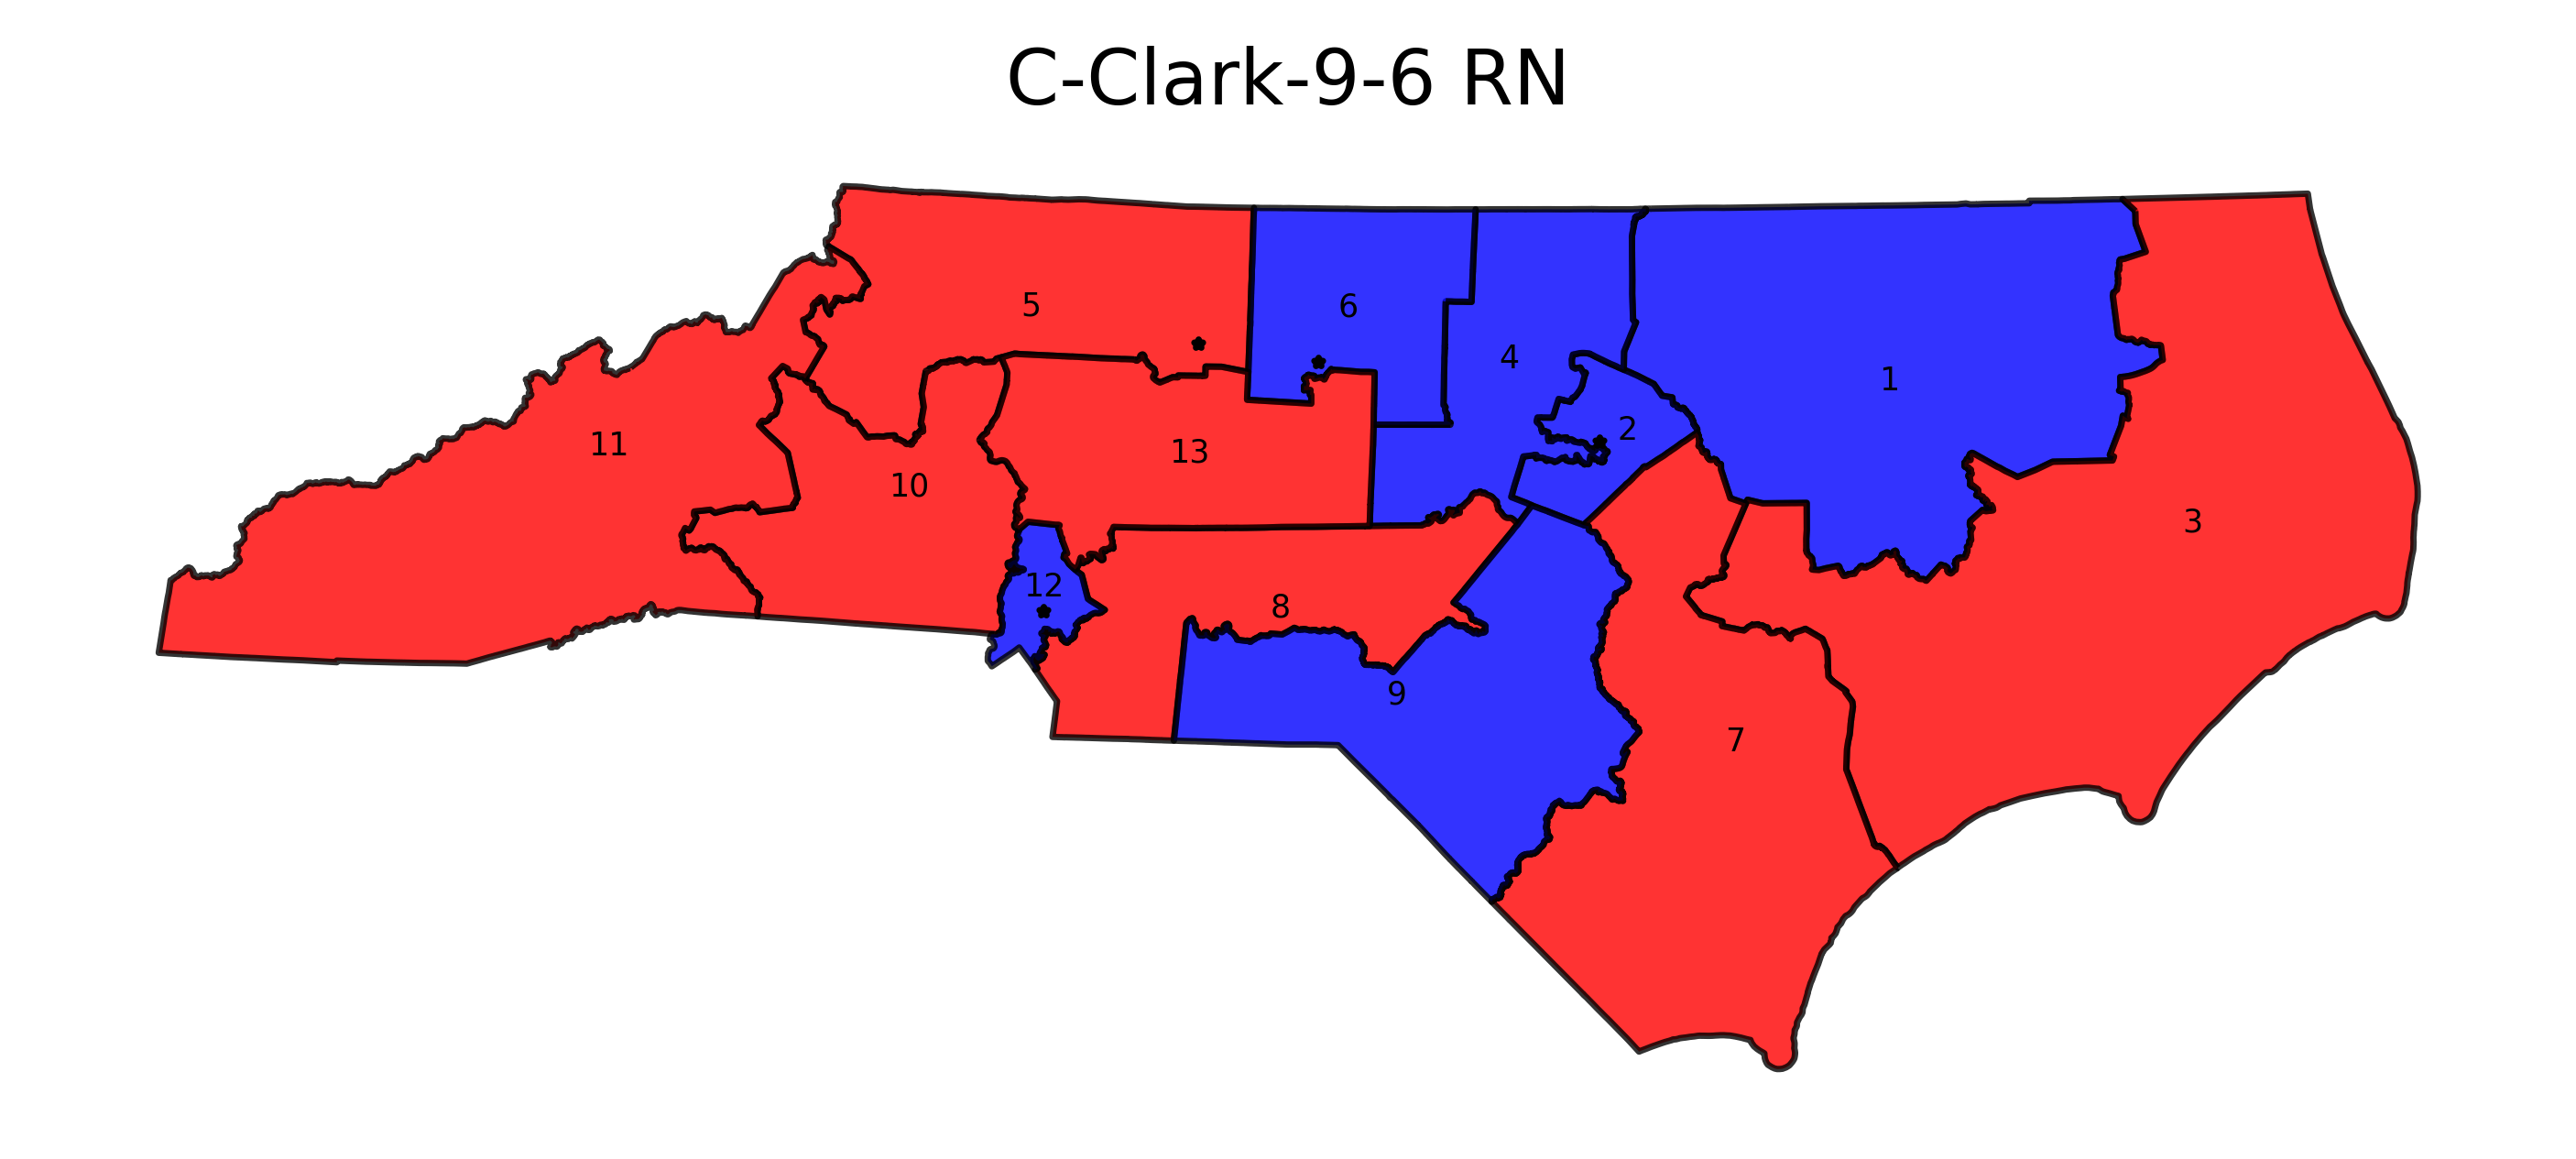

In [26]:
plan['coords'] = plan['geometry'].apply(lambda x: x.representative_point().coords[:])
plan['coords'] = [coords[0] for coords in plan['coords']]

f, ax = plt.subplots(1)
ax.set_axis_off()
plan.plot(column="predicted_outcome", ax=ax, edgecolor='black', cmap=thiscmap, norm=norm, alpha=.8)
for idx, row in plan.iterrows():
    plt.annotate(s=row['DISTRICT'], xy=row['coords'], horizontalalignment='center', size=5) #str(row['predicted_outcome'])+"%"

cities_gdf.plot(ax=ax, marker='*', color='k', markersize=2)

plt.title(planName)
plt.show()